# CO<sub>2</sub>R Technoeconomics Figures and Analysis
Date updated: 2024/06/30 \
Update notes: Reordered and updated optimization \
Contact: Shashwati da Cunha, [shashwati.dacunha@austin.utexas.edu](mailto:shashwati.dacunha@austin.utexas.edu)

### What is this notebook?
This Jupyter notebook is only an integrator - no actual modeling is built in here. It is written to interactively generate plots seen in our <span style = 'color:red'> publications </span>. 

### Instructions
0. Download and locate the entire folder associated with this notebook, including the `Supplementary Workbook.xlsx` Excel template for constants and parameters (data). Please use the associated template and units, since this notebook will directly import the variable names in there as values, and look for those header and product names for model data.
1. Update the Excel sheet with constants, assumptions about efficiencies, and assumptions about costs. To make any changes in how this code calculates process costs (e.g. changing Tafel slopes, changing the cost of deionized water) please change data in the Excel file only. Note that changes in the process itself will require a change in the associated downstream model (see *How does it work?* below).
2. Run this code! Look at the `Run` menu > `Run all`. Enter simulation details when prompted. Please walk through the outputs cell by cell, since not everything is prompted through a user input. In particular, to change electricity prices, there is no user input.

### How does it work?
Constants, assumptions and empirical data are imported from `Supplementary Workbook.xlsx`, mostly directly into global variables. An evaluation of the technoeconomic assessment and emissions is carried out in other `.ipynb` notebook files that contain the model and are imported here. In particular, the file titled `"<version>_SingleRun.ipynb"` contains a function called `singlerun()`, which takes all inputs about the model as arguments, and generates a comprehensive TEA. This function returns information on cost breakdown, emissions, energy requirements etc in dataframes. `singlerun()` calls several other functions, which are split across `"<version>_ElectrolyzerModel.ipynb"` (electrolyzer model - voltage, currents and streams), `"<version>_DownstreamProcessModel.ipynb"` (process stream table and separations requirements), and `"<version>_ProcessEconomics.ipynb"` (all process costing.)

There is no actual modeling in this file. In any file, you can import the product data from `Supplementary Workbook.xlsx`, and `%run` `"<version>_ElectrolyzerModel.ipynb"`, `"<version>_DownstreamProcessModel.ipynb"`, `"<version>_ProcessEconomics.ipynb"`, and `<version>_SingleRun.ipynb` (or `import *` from them as packages). Then just call the `singlerun()` function with all its inputs to run the model.

### Requirements
File naming conventions are written for Windows; other operating systems may require adjustments to file names throughout.

This code was written in Python 3 and tested in Jupyter 7. It uses the following packages:
- `python 3.11.7`
- `numpy 1.26.4`
- `pandas 2.1.4`
- `scipy 1.11.4`
- `matplotlib 3.8.4`
- `openpyxl 3.0.10`
- Jupyter 7 (`notebook 7.0.8`, which includes `ipywidgets 7.6.5`, `ipython 8.20.0`, `jupyter_core 5.5.0` etc)


# 0. Imports and setup

## 0.1. Imports and styling

In [1]:
### Import packages
import pandas as pd
import numpy as np

import matplotlib as mp
from matplotlib import ticker
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# import csv

from datetime import datetime
# import timeit

from functools import reduce

from os.path import exists
import os

import openpyxl
from openpyxl.worksheet.dimensions import ColumnDimension, DimensionHolder
import openpyxl.utils.cell
from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font

from scipy import optimize

from IPython.display import display, HTML, clear_output

### 0.1.1 Import functions from other notebooks

In [2]:
%run "20240701_0_ElectrolyzerModel.ipynb"
%run "20240701_1_DownstreamProcessModel.ipynb"
%run "20240701_2_ProcessEconomics.ipynb"
%run "20240701_3_TEA_SingleRun.ipynb"

## 0.2. Matplotlib formatting

In [3]:
# All options at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
# mp.style.use('bmh')

In [4]:
# Plot formatting for Matplotlib - rcParams. All options at https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams

# All fonts and font sizes
SMALL_SIZE = 20 # set smallest font size
MEDIUM_SIZE = 24 # set medium font size
BIGGER_SIZE = 27 # set
mp.rc('font', family = 'Arial') # font group is sans-serif
mp.rc('font', size=MEDIUM_SIZE)     # controls default text sizes if unspecified
mp.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title; I think this is for subplots 
mp.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mp.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
mp.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
mp.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mp.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# text padding
mp.rc('axes', labelpad= 18) # padding between axis label and axis
mp.rc('axes', titlepad= 22) # padding between axis title and labels; might be for subplots
mp.rc('legend', handletextpad = 0.3) # padding between each legend entry's icon and text
mp.rc('legend', borderaxespad = 1) # padding between legend border and axes
TICK_PADDING = 8
mp.rcParams['xtick.major.pad'] = TICK_PADDING
mp.rcParams['xtick.minor.pad'] = TICK_PADDING
mp.rcParams['ytick.major.pad'] = TICK_PADDING
mp.rcParams['ytick.minor.pad'] = TICK_PADDING
mp.rcParams['axes.xmargin'] = 1
mp.rcParams['axes.ymargin'] = 1

# figure settings
aspect_ratio = 1/1 # 3/4
mp.rc('figure', figsize = (5, 5*aspect_ratio)) # figure size
mp.rc('figure', dpi = 250) # figure dpi/ pix per inch
mp.rcParams['axes.spines.right'] = True # right border
mp.rcParams['axes.spines.top'] = True # top border

# legend
mp.rc('legend', loc = 'upper left') # legend location 
mp.rc('legend', frameon = False) # legend border - yes or no?
mp.rc('legend', markerscale = 1) # scale up markers in legend

# axes
mp.rc('axes', linewidth = 2) # linewidth of axes

# default axes
mp.rc('axes', autolimit_mode = 'round_numbers') # set default axis limits to be "round" numbers rather than data

# major x-ticks
mp.rcParams['xtick.top'] = False  # top or bottom of plot
mp.rcParams['xtick.direction'] = 'out' # ticks in or out of plot
mp.rcParams['xtick.major.width'] = 2 # linewidth of ticks
mp.rcParams['xtick.major.size'] = 12 # length of ticks

# minor x-ticks
mp.rcParams['xtick.minor.visible'] = True
mp.rcParams['xtick.minor.width'] = 2  # linewidth of ticks
mp.rcParams['xtick.minor.size'] = 6   # length of ticks

# major y-ticks
mp.rcParams['ytick.right'] = False  # right or left of plot
mp.rcParams['ytick.direction'] = 'out' # ticks in or out of plot
mp.rcParams['ytick.major.width'] = 2   # linewidth of ticks
mp.rcParams['ytick.major.size'] = 12  # length of ticks

# minor y-ticks
mp.rcParams['ytick.minor.visible'] = True
mp.rcParams['ytick.minor.right'] = False # right or left of plot
mp.rcParams['ytick.minor.width'] = 2 # linewidth of ticks
mp.rcParams['ytick.minor.size'] = 6  # length of ticks

# format for saving figures
mp.rcParams['savefig.format'] = 'tiff'
mp.rcParams['savefig.bbox'] = 'tight' # 'tight' # or standard; tight may break ffmpeg
# If using standard, be sure to use bbox_inches="tight" argument in savefig

# defaults for scatterplots
mp.rcParams['scatter.marker'] = 'o' # round markers unless otherwise specified
mp.rcParams['lines.markersize'] = 6 # sets the scatter/line marker size; roughly equivalent to s = 40 in my experience

# defaults for lines
mp.rcParams['lines.linestyle'] = '-' # solid lines unless otherwise specified
mp.rcParams['lines.linewidth'] = 2 # default linewidth

# defaults for errorbars
mp.rcParams['errorbar.capsize'] = 4

### Fix random state for reproducibility
np.random.seed(19680801)

### Some options for ticks:
# np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
# np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
# np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
# axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                             #n within the data range


## 0.3 Input file locations

In [5]:
# Prompt user to enter file path
# file_imports = r"{}".format(input('Enter filepath for costs of utilities and raw materials \
#                   \n \n').replace('"', '')

file_imports = r"Supplementary Workbook.xlsx"

In [6]:
# sheet_cost_imports = input('Enter sheet name for costs of utilities \
#                   \n \n')
# Prompt user to enter sheet name for utility costs

sheet_utility_imports = 'Utilities'

In [7]:
# sheet_constants = input('Enter sheet name for constants \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for constants

sheet_constants =  'Constants and assumptions'

In [8]:
# sheet_products = input('Enter sheet name for products \
#                   \n \n').replace('"', '') 
# Prompt user to enter sheet name for product data

sheet_products =  'Products'

## 0.4 Output file locations

In [9]:
root_folder = r'D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R'

In [10]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

# Output folder - must be written as r"path/folder"; the r at the front indicates a raw string literal
# root_folder = file_imports[::-1].split('\\', 1)[1][::-1] # Take the imports filepath, reverse it and split on the last \ character, and re-reverse it 
OP_folder = root_folder + '\LCA TEA results on ' + current_date
if not os.path.exists(OP_folder): # check if OP_folder path exists
    os.mkdir(OP_folder) # if path doesn't exist, create the folder
    
# Manually set OP_folder if desired:
# OP_folder = # r"D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R"

## 0.5 Import Excel data

### 0.5.1 Import constants and product data

In [11]:
df_constants = pd.DataFrame # Create dataframe for constants
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_constants = xlsx.parse(sheet_name = sheet_constants) # Read the sheet with the constants
df_constants.set_index('Variable name', drop = True, inplace = True) # Reset index to variable name
xlsx.close() # close xlsx file

## Update constants as variables 
## NOTE: Modifying globals() is a very frowned on practice in Python - be VERY careful implementing this, it's easy to say 
# overwrite variables that are carelessly named. Consider indexing directly from df_constants (set its index to 'variable name')
# and df_utilities instead

for index, row in df_constants.iterrows(): # for each row in df_constants
    globals()[index] = row['Value'] # save its 'value' to a new variable called the 'variable name' column

df_constants

,Name,Value,Unit,References,Unnamed: 5
Variable name,,,,,
electrolyte_conc,Concentration: neutral electrolyte,1.000000e+00,M,NaN,NaN
CO2_cost_USD_tCO2,Cost: CO2,7.500000e+01,$/t CO2,"Baylin-Stern, Berghout (IEA, 2021)",Average for power generation; assumes zero tra...
water_cost_USD_kg,Cost: DI water,1.450000e-02,$/kg,"Alerte, Sargent (ACS Sust. Chem. Eng. 2023): $...",Seider et al 2017: $0.27/m3 for process water ...
electrolyzer_capex_USD_m2,Cost: Electrolyzer,5.000000e+03,$/m2,"Badgett, Cortright (J. Cleaner Prod. 2022)",NaN
crossover_acid,Crossover: acidic electrolyte,0.000000e+00,mol CO2/mol e-,NaN,NaN
crossover_alkaline,Crossover: alkaline electrolyte,6.500000e-01,mol CO2/mol e-,NaN,NaN
crossover_neutral,Crossover: neutral electrolyte,5.000000e-01,mol CO2/mol e-,NaN,NaN
density_kgm3,Density: salt solutions,1.000000e+03,kg/m3,NaN,NaN
carbon_capture_efficiency,Efficiency: carbon capture,9.000000e-01,NaN,"Brandl, Mac Dowell (Int. J. Greenhouse Gas Con...",NaN


In [12]:
df_products = pd.DataFrame # Create dataframe for product data
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_products = xlsx.parse(sheet_name = sheet_products) # Read the sheet with the product data
df_products.set_index('Product', drop = True, inplace = True) # reset index to product name
xlsx.close() # close xlsx file
    
df_products

,Phase,Molecular weight (g/mol),n (mol e-/ mol product),z (mol CO2/ mol product),LHV (kJ/kg product),Cost ($/kg product),"Standard potential, pH = 0 (V vs SHE)",Standard potential (V vs RHE),Reference overpotential (V),Tafel slope (mV/dec),Reference current density (mA/cm2),FECO2R at SPC = 0,"Optimal SPC @ 7.6 c/kWh, Hawks model","Optimal j @ 7.6 c/kWh, Hawks model",References,References 2
Product,,,,,,,,,,,,,,,,
H2,gas,2.015894,2,0,120087,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO,gas,28.0101,2,1,10160,0.6,-0.06,-0.1,-0.44,-230,10,0.95,0.11480,472.1,"Shin, Jiao (Nat. Sust. 2021)",George (Kirk-Othmer Encyclopedia 2001); but $0...
Ethylene,gas,28.054,12,2,47741,1.3,0.09,0.08,-0.306,-426,1,0.70,0.02655,435.9,"Shin, Jiao (Nat. Sust. 2021)","Jouny, Jiao (Ind. & Eng. Chem. 2019) - but $0...."
References,-,-,"Nitopi, Jaramillo (Chem. Rev. 2019)",-,"Engineering Toolbox, Engineering Toolbox",See References 2 col,"Bui, Weber (Chem. Rev. 2022)","Nitopi, Jaramillo (Chem. Rev. 2019)",See References col,See References col,See References col,NaN,NaN,NaN,NaN,NaN


### 0.5.2 Import utility cost and LCA database

In [13]:
df_utility_imports = pd.DataFrame # Create dataframe for costs
xlsx = pd.ExcelFile(file_imports) # Read each data Excel file
df_utility_imports = xlsx.parse(sheet_name = sheet_utility_imports) # Read the sheet with the costing
df_utility_imports.set_index('Utility', drop = True, inplace = True) # reset index to utility name
xlsx.close() # close xlsx file
    
df_utility_imports

,Cost ($/kWh),CO2 emissions (g CO2/kWh),References,Unnamed: 4,Unnamed: 5
Utility,,,,,
NaN,NaN,NaN,NaN,NaN,NaN
Electricity - solar,0.024000,50.000000,Lazard (April 2023); NREL (2021),https://www.nrel.gov/analysis/life-cycle-asses...,"75th percentile, harmonized"
Electricity - onshore wind,0.024000,20.000000,Lazard (April 2023); NREL (2021),NaN,NaN
Electricity - wind + storage,0.042000,NaN,Lazard (April 2023); GREET (2022),NaN,NaN
Electricity - current California mix,0.016050,230.930614,U.S. Energy Information Administration (April ...,NaN,NaN
Electricity - current US mix,0.076200,414.104338,U.S. Energy Information Administration (April ...,NaN,NaN
Heat - NG,0.007569,254.376000,Henry Hub (via U.S. Energy Information Adminis...,NaN,NaN
"Shin, Jiao assumption",0.030000,NaN,"Shin, Jiao (Nat. Sust. 2021)",NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN


## 0.6 Manually adjust inputs

### 0.6.1 Check results

In [14]:
# Extract constants to use for costing and emissions calculations
electricity_cost_USD_kWh = df_utility_imports.loc['Electric utility chosen', 'Cost ($/kWh)'] 
heat_cost_USD_kWh = df_utility_imports.loc['Heat utility chosen', 'Cost ($/kWh)']

electricity_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Electric utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2
heat_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Heat utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2

battery_capex_USD_kWh = df_utility_imports.loc['Battery storage', 'Cost ($/kWh)']

In [15]:
# Have user verify electricity costs and say if they want to modify
print('Costs of utilities: \n    \
        Electricity ${:.3f}/kWh \n   \
         Heat ${:.3f}/kWh '.format(electricity_cost_USD_kWh, heat_cost_USD_kWh))
print('Carbon intensity of utilities: \n    \
        Electricity {:.3f} kg CO2/kWh \n   \
         Heat {:.3f} kg CO2/kWh '.format(electricity_emissions_kgCO2_kWh, heat_emissions_kgCO2_kWh))
display(df_utility_imports)

answer = input('Do you want to manually modify any of these? y/n \n \n')

if answer.lower() == 'y':
    clear_output()
    print('Uncomment the next code block as you need!')
else:
    print('Using chosen utility prices and carbon intensity')

Costs of utilities: 
            Electricity $0.076/kWh 
            Heat $0.008/kWh 
Carbon intensity of utilities: 
            Electricity 0.414 kg CO2/kWh 
            Heat 0.254 kg CO2/kWh 


,Cost ($/kWh),CO2 emissions (g CO2/kWh),References,Unnamed: 4,Unnamed: 5
Utility,,,,,
NaN,NaN,NaN,NaN,NaN,NaN
Electricity - solar,0.024000,50.000000,Lazard (April 2023); NREL (2021),https://www.nrel.gov/analysis/life-cycle-asses...,"75th percentile, harmonized"
Electricity - onshore wind,0.024000,20.000000,Lazard (April 2023); NREL (2021),NaN,NaN
Electricity - wind + storage,0.042000,NaN,Lazard (April 2023); GREET (2022),NaN,NaN
Electricity - current California mix,0.016050,230.930614,U.S. Energy Information Administration (April ...,NaN,NaN
Electricity - current US mix,0.076200,414.104338,U.S. Energy Information Administration (April ...,NaN,NaN
Heat - NG,0.007569,254.376000,Henry Hub (via U.S. Energy Information Adminis...,NaN,NaN
"Shin, Jiao assumption",0.030000,NaN,"Shin, Jiao (Nat. Sust. 2021)",NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN


Using chosen utility prices and carbon intensity


In [16]:
# Adjust utility costs if desired

if answer.lower() == 'y':
    print('Manually entering inputs')
#     Uncomment lines below as needed

    # electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)'] 
#     electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - onshore wind', 'Cost ($/kWh)'] 
    electricity_cost_USD_kWh = df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)'] # 0.02 # $/kWh

    # electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - wind + storage','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']
#     electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - onshore wind','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']
    electricity_emissions_kgCO2_kWh = 0.001 *df_utility_imports.loc['Electricity - solar','CO2 emissions (g CO2/kWh)']  # df_utility_imports.loc['Electricity - current California mix','CO2 emissions (g CO2/kWh)']

#     heat_emissions_kgCO2_kWh = 0.001 * df_utility_imports.loc['Heat utility chosen', 'CO2 emissions (g CO2/kWh)'] # convert g CO2 to kg CO2

#     heat_cost_USD_kWh =  df_utility_imports.loc['Heat utility chosen', 'Cost ($/kWh)'] 

    print('Costs of utility_imports: \n    \
            Electricity ${:.3f}/kWh \n   \
             Heat ${:.3f}/kWh '.format(electricity_cost_USD_kWh, heat_cost_USD_kWh))
    print('Carbon intensity of utility_imports: \n    \
            Electricity {:.3f} kg CO2/kWh \n   \
             Heat {:.3f} kg CO2/kWh '.format(electricity_emissions_kgCO2_kWh, heat_emissions_kgCO2_kWh))


### 0.6.2 Set defaults for 'override' commands and modeling options

In [17]:
override_one = False
override_onebyone = False
overridde_multivbl = False
override_optimization = False
override_animation = False
override_single = False
cell_E_V = np.NaN
BV_eta_cat_V = np.NaN
BV_eta_an_V = np.NaN
model_FE = 'Kas'
is_battery = False

# 1. Output file setup

## 1.1 Excel file formatting

In [18]:
# Function to format sheets once written, otherwise they are hard to read

def book_format(writer):
        book  = writer.book # Get workbook
        for i in writer.sheets:
            sheet = writer.sheets[i] # Get worksheet

            # Note that when reading, openpyxl indexes from 1

            # General column and cell formatting
            for i in range(1, 100): # (1, df_expt.shape[1]+2) # Iterate through columns
                col = openpyxl.utils.cell.get_column_letter(i) # Get column's letter index (openpyxl col indexing starts at 1 = 'A')
                # Column formatting              
                sheet.column_dimensions[col].width = 25         

                # Cell formatting
                for row in range(1,200): # Iterate through rows; this takes a lot of time in large output files 
                    sheet[col + str(row)].alignment= Alignment(horizontal='center',
                                         vertical='center',
                                         text_rotation=0,
                                         wrap_text=True) # Format cell contents

    #         # Row formatting - text wrapping will take care of this so not necessary
    #         for row in range(1,50): # Iterate through rows, add 2 because indexing at 0 + range stops 1 before end; row 1 defined above
    #             sheet.row_dimensions[row].height = 15 # Set row height ## TODO: throws error on indexing

            # Specific formatting

    #         First 2 column widths
            sheet.column_dimensions['A'].width = 10
            sheet.column_dimensions['B'].width = 40

## 1.2 Define color scheme

In [19]:
## Theme colors 
theme_colors = ['#bf5700',  '#ffc919', '#8f275d', '#73a3b3', '#193770', '#e35555', '#191f24' ] #ffffff (white)

## Import colormaps
summer = mp.colormaps['summer']
summer_r = mp.colormaps['summer_r']
PuOr = mp.colormaps['PuOr']
viridis = mp.colormaps['viridis']
viridis_r = mp.colormaps['viridis_r']
# wistia = mp.colormaps['Wistia']
# greys = mp.colormaps['gist_yarg'] # 'Gray'
RdBu = mp.colormaps['RdBu'] # seismic
RdYlBu = mp.colormaps['RdYlBu']
# inferno = mp.colormaps['inferno_r']
Blues = mp.colormaps['Blues']
# winter = mp.colormaps['winter_r']
# cool = mp.colormaps['cool_r']

## 1.3 Choose product

In [20]:
# Choose a product
answer = input('Enter product number of choice: \n \
                (1) CO \n \
                (2) ethylene \n \
                (3) formic acid \n \
                (4) ethanol \n '        
)

if answer != '1' and answer != '2' and answer != '3' and answer != '4' :
    print('Using default product, CO')
    answer = 1
               
product_name = ['CO', 'Ethylene', 'Formic acid', 'Ethanol'][int(answer)-1] # fix indexing from 0 to extract product name from this list

### 1.3.1. Extract product costs

In [21]:
# Extract product costs
product_cost_USD_kgprod = df_products.loc[product_name, 'Cost ($/kg product)']
H2_cost_USD_kgH2 =  df_products.loc['H2', 'Cost ($/kg product)'] # assume H2 is not sold

# Electricity cost can also be varied;  it is defined above in the file imports 
# Water and CO2 costs are usually imported

In [22]:
# Set default inputs for TEA. These can always be modified later
crossover_ratio = crossover_neutral
FE_product_specified = np.NaN # df_products.loc[product_name, 'FECO2R at SPC = 0']  # 0.9 # 0.90 # %/100
FE_CO2R_0 = df_products.loc[product_name, 'FECO2R at SPC = 0']
j_total_mA_cm2 = df_products.loc[product_name, 'Optimal j @ 7.6 c/kWh, Hawks model'] # 300 # mA/cm2
SPC = df_products.loc[product_name, 'Optimal SPC @ 7.6 c/kWh, Hawks model']  #0.3 # 0.5 # %/100

# Save variables that may be adjusted
SPC_original = SPC

avbl_renewables = 0

scaling = 4.7306 ## TODO: Move this option for modeling elsewhere
exponent = 5.4936 ## TODO: Move this option for modeling elsewhere

## 1.4 Function for generating variable ranges

In [23]:
def generate_range(vbl):
    
        print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')
        vbl_min = float(input('Minimum {}: ({})\n'.format(vbl_name, vbl_unit)))
        vbl_max = float(input('Maximum {}: ({}) \n'.format(vbl_name, vbl_unit)))

        # Reorder potential limits defined and generate a range of the chosen independent variable
        vbl_limits = [vbl_min, vbl_max]
        vbl_min = min(vbl_limits)
        vbl_max = max(vbl_limits)

        # Generate range
        answer_range = int(input('How should the points be spaced: \n \
                    (1) linear, defined step size \n \
                    (2) linear, defined number of points \n \
                    (3) logspace \n '
        ))

        # Linearly space points based on step size
        if answer_range == 1:
            vbl_step = float(input('Step for {}: ({}) \n'.format(vbl_name, vbl_unit)))
            vbl_range = np.arange(start = vbl_min, stop = vbl_max+vbl_step, step = vbl_step) # include the last point as close as possible

        # Linearly space points based on defined # of points
        elif answer_range == 2:
            vbl_num = int(
                input('Number of points: \n'))
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = vbl_num, endpoint = True)

        # Log space points
        elif answer_range == 3:
            vbl_num = int(input('Number of points: \n'))
            vbl_range = np.logspace(start = np.log10(vbl_min), stop = np.log10(vbl_max), num = vbl_num, base = 10, endpoint = True)

        return vbl_min, vbl_max, vbl_range, answer_range

#### 1.4.1 Flags for variables

In [24]:
# Create flags for selecting variable
dict_flags = {   # Formatted as 'override_parameter': 'parameter name', 'unit', 'variable name', 'default value', 'minimum value', 'maximum value'
    'override_cell_voltage':[ 'Cell voltage', 'V', 'cell_E_V',                                   cell_E_V, 1.34, 5 ],
    'override_eta_cat': ['Cathodic overpotential', 'V', 'BV_eta_cat_V',                          BV_eta_cat_V, 0, -2.5],
    'override_eta_an': ['Anodic overpotential', 'V', 'BV_eta_an_V',                              BV_eta_an_V, 0, 2.5 ],
    'override_ohmic' : ['Specific resistance', '$\Omega$.cm$^2$', 'R_ohmcm2',               R_ohmcm2, 0, 25],

    'override_j': ['Current density', 'mA/cm$^2$', 'j_total_mA_cm2',                             df_products.loc[product_name, 'Optimal j @ 7.6 c/kWh, Hawks model'], 25, 1275],
    # 'override_FE': ['FE$_{{{}}}$'.format(product_name), '', 'FE_product_specified',              df_products.loc[product_name, 'FECO2R at SPC = 0'], 1e-3, 1 ],
    'override_FE_CO2R_0': ['FE$_{CO_2R,0}$', '', 'FE_CO2R_0',                                    df_products.loc[product_name, 'FECO2R at SPC = 0'], 1e-3, 1 ],
    'override_SPC':['Single-pass conversion' , '', 'SPC',                                        df_products.loc[product_name, 'Optimal SPC @ 7.6 c/kWh, Hawks model'], 1e-4, 0.5],
    'override_crossover': ['Crossover' , 'mol CO$_2$ per mol e$^-$', 'crossover_ratio',          crossover_ratio, 1e-4, 0.5],
    
    'override_rate': ['{} production rate'.format(product_name), 'kg/day', 'product_rate_kg_day', product_rate_kg_day, 1e-3, 1.25e6],
    'override_capacity': ['Capacity factor' , '', 'capacity_factor',                             capacity_factor, 1e-4, 1 ],
    'override_lifetime': ['Plant lifetime' , 'years', 'lifetime_years',                          lifetime_years, 1e-3, 50],
    'override_stack_lifetime': ['Stack lifetime' , 'years', 'stack_lifetime_years',              stack_lifetime_years, 1e-3, 30],
    'override_separation': ['Second-law separation efficiency', '', 'PSA_second_law_efficiency',   PSA_second_law_efficiency, 0.01, 0.1],
    
    'override_electricity_cost':[ 'Electricity cost' , '$/kWh', 'electricity_cost_USD_kWh',      electricity_cost_USD_kWh, 0, 0.1 ],
    'override_CO2_cost': ['CO$_2$ cost'  , '\$/t CO$_2$', 'CO2_cost_USD_tCO2',                   CO2_cost_USD_tCO2, 0, 200],
    'override_H2_cost': ['H$_2$ cost'  , '\$/kg H$_2$', 'H2_cost_USD_kgH2',                   H2_cost_USD_kgH2, 0, 10],
    'override_water_cost': ['Water cost' , '\$/kg', 'water_cost_USD_kg',                      water_cost_USD_kg, 0, 0.30],
    'override_electrolyzer_capex': ['Electrolyzer capital cost' , '\$/m$^2$', 'electrolyzer_capex_USD_m2', electrolyzer_capex_USD_m2, 3000, 10000],
    'override_carbon_intensity': ['Grid CO$_2$ intensity', 'kg CO$_2$/kWh', 'electricity_emissions_kgCO2_kWh',electricity_emissions_kgCO2_kWh, 0, 0.5],
    
    'override_battery_capacity': ['Renewables capacity factor' , '', 'avbl_renewables',        avbl_renewables, 1e-4, 1 ],
    }
# Note that percentages here are expressed directly as decimals. E.g. entering 0.01 above for default FE will result in default FE = 1%

df_flags = pd.DataFrame(dict_flags).T
df_flags.reset_index(inplace = True, drop = False)
df_flags.set_index(0, inplace = True, drop = True) # Set independent variable name as index
df_flags.index.name = 'Independent variable'
df_flags.columns = ['Old flag name', 'Unit', 'Python variable', 'Default value', 'Range min', 'Range max']

----

# 2. Single model run

In [25]:
## Run single TEA? 

answer = input('Do you want to run a single TEA with default settings? y/n \n \n')
if answer == 'y':
    override_single = True
    print('Running single TEA')
else:
    override_single = False

In [26]:
## Make decisions about FE-SPC tradeoff
if override_single:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')
        # SPC = 0.418 # Uncomment for Fig 4i
        
        # SPC = 0.369 # Uncomment for Fig 4f
        # j_total_mA_cm2 = 111 # Uncomment for Fig 4f, S_d-f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i
        
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

In [27]:
## Make decisions about battery

if override_single:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))

    else:
        is_battery = False
        battery_capacity = 0

In [28]:
# Single run of electrolyzer model    

if override_single:
    ### Generate modeling results 

    ### Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0
 
    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, model_FE = model_FE,  
                                                                        overridden_vbl = '', overridden_value = np.NaN, overridden_unit = '', 
                                                                        override_optimization =  override_optimization, P = P, T_streams = T_streams, 
                                                                        R_ohmcm2 = R_ohmcm2, an_E_eqm = an_E_eqm,MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        an_eta_ref = an_eta_ref, 
                                                                        an_Tafel_slope = an_Tafel_slope, 
                                                                        an_j_ref = an_j_ref, 
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        electrolyte_conc = electrolyte_conc, 
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        capacity_factor = capacity_factor,battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity, 
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, scaling=scaling,
                                                                        R = R,
                                                                        F = F)
    df_emissions = pd.concat([ df_energy['Emissions (kg CO2/kg {})'.format(product_name)],pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value']) ])
    df_emissions.index = np.append(df_energy.index, 'Carbon capture')
    opex_USD_kg = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    capex_USD = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
    levelized_USD_kg = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]

    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))
    
    CO2_captured_ton_yr = df_streams.loc['Fresh CO2 feed', 'Mass flow rate (kg/day)'] *  capacity_factor * 365 / 1000
    CO2_captured_ton_total = CO2_captured_ton_yr * lifetime_years

## 2.1 Cost breakdowns

In [29]:
### Define colors
## WARNING: HARDCODED!

if override_single == True:
    if is_battery:
        # Capex colors for bare modules
        BM_capex_colors = [summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM.index)-1)] # battery gets its own color, so 1 less than capex length for other units
        BM_capex_colors.append((0.65, 0.65, 0.65, 1)) # add in battery 
    else:
        # Capex colors
        BM_capex_colors = [summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM.index))]
        
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    # Opex colors
    opex_colors = [PuOr(i) for i in np.linspace(0, 0.85, len(df_opex.index))]
    levelized_colors = opex_colors + BM_capex_colors
    #PuOr okay but low contrast at ends
    
    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials.iloc[2:7])[0] )  ] # last rows are totals

    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy['Emissions (kg CO2/kg {})'.format(product_name)].isnull()) + 1)  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals
    
    # Energy colors
    # energy_colors = [RdYlBu(i) for i in np.linspace(0, 1,  sum(~df_energy['Energy (kJ/kg {})'.format(product_name)].isnull()) - 3)  ] # last rows are totals
    energy_colors = emissions_colors # energy is 1 shorter than emissions

In [30]:
def opex_pie_label(cost):
    percentage = cost/df_opex_totals.loc[ 'Production cost', 'Cost ($/kg {})'.format(product_name)] / 100
    if percentage >= 0.03:
        text_percentage = '{:.1%}'.format(percentage)
    else:
        text_percentage = ''
    return text_percentage

### 2.1.1 Capex pie chart

In [31]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot

    axs.pie(df_capex_BM.loc[:, 'Cost ($)'], 
            labels = df_capex_BM.index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.7,
            colors = BM_capex_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
              )   
    axs.text(0, 0,  
     'Capex: \n ${:.2f} million'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='center', va='center', 
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    capex_pie_fig_name = os.path.join(OP_folder, '{} Capex breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(capex_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + capex_pie_fig_name)
    
    plt.show()

### 2.1.2 Opex pie chart

In [32]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    axs.pie(df_opex.loc[:, 'Cost ($/kg {})'.format(product_name)], 
            labels = df_opex.index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = opex_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
              )   
    axs.text(0, 0,  
     'Opex: \n \${:.2f}/kg$_{{{}}}$'.format(df_opex_totals.loc[ 'Production cost', 'Cost ($/kg {})'.format(product_name)], product_name), # All capex except working capital, which is recovered during operation
     ha='center', va='center', 
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    opex_pie_fig_name = os.path.join(OP_folder, '{} Opex breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(opex_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + opex_pie_fig_name)
    
    plt.show()

### 2.1.3 Levelized cost pie chart

In [33]:
if override_single == True:
    alternating = 1
    flag = False
    far_near = {1: 2.3, -1: 4.0}
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    full_list_of_costs = pd.concat([df_opex.loc[:, 'Cost ($/kg {})'.format(product_name)],
                          df_capex_BM.loc[:,'Cost ($)']/(365*capacity_factor*lifetime_years*product_rate_kg_day)], axis = 0)

    wedges, __, __ = axs.pie(full_list_of_costs, 
                    # labels = full_list_of_costs.index, 
                    # labeldistance = 1.1,
                    autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
                    pctdistance = 0.8,
                    colors = levelized_colors, startangle = 0, 
                    textprops = {'fontsize' : SMALL_SIZE}, 
                    radius = 2, wedgeprops= {'width' : 1}, # donut
                    counterclock = False,
                    # explode = 0.2*np.ones(len(df_opex.index),
                    )   
    axs.text(0, 0,  
    'Levelized cost: \n \${:.2f}/kg$_{{{}}}$'.format(df_opex_totals.loc[ 'Levelized cost', 'Cost ($/kg {})'.format(product_name)], product_name), # All capex except working capital, which is recovered during operation
    ha='center', va='center', 
    fontsize = MEDIUM_SIZE)
    
    box_properties = dict(boxstyle="square,pad=0.3", fc="none", lw=0)
    label_properties_away = dict(arrowprops=dict(arrowstyle="-"),
                        bbox=box_properties, zorder=0, va="center")
    label_properties_near = dict(arrowprops=dict(arrowstyle="-",alpha = 0),
                        bbox=box_properties, zorder=0, va="center")
    for i, wedge in enumerate(wedges):
        middle_angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1 # in degrees
        y_posn = np.sin(np.deg2rad(middle_angle))
        x_posn = np.cos(np.deg2rad(middle_angle))
        verticalalignment = {-1: "bottom", 1: "top"}[int(np.sign(y_posn))]
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
        if (wedge.theta2 - wedge.theta1) <22:
            alternating = -alternating
            connectionstyle = f"angle,angleA=0,angleB={middle_angle}"
            label_properties_away["arrowprops"].update({"connectionstyle": connectionstyle})
            axs.annotate(full_list_of_costs.index[i], xy=(x_posn, y_posn), 
                        xytext=(far_near[alternating]*1*x_posn, 3.7*y_posn),
                        horizontalalignment=horizontalalignment, 
                        **label_properties_away)
        else:                            
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
            axs.text(2.3*x_posn, 2.3*y_posn,
                    full_list_of_costs.index[i],
                    horizontalalignment=horizontalalignment, 
                    verticalalignment = verticalalignment)
 
    ## Save figure 
    levelized_pie_fig_name = os.path.join(OP_folder, '{} Levelized breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(levelized_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + levelized_pie_fig_name)
    
    plt.show()

### 2.1.4 Emissions pie chart

In [34]:
if override_single == True:
    alternating = 1
    flag = False
    far_near = {1: 3.5, -1: 4.5}
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    wedges, __, __ = axs.pie(df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)], 
                  labels = df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index, 
                  labeldistance = 1.1,
                  autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
                  pctdistance = 0.8,
                  colors = emissions_colors, startangle = 0, 
                  textprops = {'fontsize' : SMALL_SIZE}, 
                  radius = 2, wedgeprops= {'width' : 1}, # donut
                  counterclock = False,
                  # explode = 0.2*np.ones(len(df_opex.index),
                  )   
    axs.text(0, 0,  
    'Emissions: \n {:.2f} kg$_{{CO_2}}$/kg$_{{{}}}$'.format(sum(df_emissions.fillna(0).drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore')), product_name), # All capex except working capital, which is recovered during operation
    ha='center', va='center', 
    fontsize = MEDIUM_SIZE)  
                            
    # Label pie chart with arrows
    # box_properties = dict(boxstyle="square,pad=0.3", fc="none", lw=0)
    # label_properties_away = dict(arrowprops=dict(arrowstyle="-"),
    #                     bbox=box_properties, zorder=0, va="center")
    # for i, wedge in enumerate(wedges):
    #     middle_angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1 # in degrees
    #     y_posn = np.sin(np.deg2rad(middle_angle))
    #     x_posn = np.cos(np.deg2rad(middle_angle))
    #     verticalalignment = {-1: "bottom", 1: "top"}[int(np.sign(y_posn))]
    #     if (wedge.theta2 - wedge.theta1) < 15:
    #         alternating = -alternating
    #         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
    #         connectionstyle = f"angle,angleA=0,angleB={middle_angle}"
    #         label_properties_away["arrowprops"].update({"connectionstyle": connectionstyle})
    #         axs.annotate(df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index[i], xy=(x_posn, y_posn), 
    #                       xytext=(far_near[alternating]*0.7*np.sign(x_posn), 3.5*y_posn),
    #                     horizontalalignment=horizontalalignment, verticalalignment = 'center',
    #                     **label_properties_away)
    #     else:                            
    #         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x_posn))]
    #         axs.text(2.3*x_posn, 2.3*y_posn,
    #                     df_emissions.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').loc[~np.isnan(df_emissions)].index[i],
    #                     horizontalalignment=horizontalalignment,
    #                     verticalalignment=verticalalignment)
                     
    ## Save figure 
    emissions_pie_fig_name = os.path.join(OP_folder, '{} Emissions breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(emissions_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + emissions_pie_fig_name)
    
    plt.show()

### 2.1.5 Energy pie chart

In [35]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot

    axs.pie((abs(df_energy.iloc[2:-3].loc[:, 'Energy (kJ/kg {})'.format(product_name)])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'],
            labels = df_energy.iloc[2:-3].index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = energy_colors, startangle = 0, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
          )   
    axs.text(0, 0,  
            'Energy: \n {:.0f} kJ/mol$_{{{}}}$'.format(df_energy.loc['Total', 'Energy (kJ/kg {})'.format(product_name)]*(df_products.loc[product_name, 'Molecular weight (g/mol)']/1000), product_name),
            ha='center', va='center', 
            fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    energy_pie_fig_name = os.path.join(OP_folder, '{} Energy breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(energy_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + energy_pie_fig_name)
    
    plt.show()

### 2.1.5 Potentials pie chart

In [36]:
if override_single == True:
  
    fig, axs = plt.subplots(figsize = (5, 5)) # Set up plot
    
    ## WARNING: HARDCODED!
    axs.pie(abs(df_potentials.iloc[2:7].loc[:,'Value']),
            labels = df_potentials.iloc[2:7].index, labeldistance = 1.1,
            autopct = lambda val: '{:.1f}%'.format(val) if val > 2 else '', 
            pctdistance = 0.8,
            colors = potentials_colors, startangle = 90, 
            textprops = {'fontsize' : SMALL_SIZE}, 
            radius = 2, wedgeprops= {'width' : 1}, # donut
            counterclock = False,
            # explode = 0.2*np.ones(len(df_opex.index),
              )   
    axs.text(0, 0,  
     'Cell potential: \n {:.2f} V'.format(df_potentials.loc['Cell potential', 'Value']),
     ha='center', va='center', 
      fontsize = MEDIUM_SIZE)  
         
    ## Save figure 
    potentials_pie_fig_name = os.path.join(OP_folder, '{} Potential breakdown single run {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(potentials_pie_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(potentials_pie_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(potentials_pie_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + potentials_pie_fig_name)
    
    plt.show()

## 2.2 Profitability metrics

### 2.2.1 Plot formatting

In [37]:
if override_single == True:
    x_axis_max = lifetime_years # round to nearest 0.01)
    x_axis_min = 0 # round to nearest 0.01)
#     x_axis_step = 0.02
    x_axis_num = 6
#     x_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     x_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) 
    barwidth = 1/(2.5*lifetime_years) * (x_axis_max - x_axis_min)
    

### 2.2.2 Discounted cash flow

In [38]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Discounted cash flow'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(30 # max(10
    y_axis_min = np.floor(min(df_cashflows['Discounted cash flow'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 10 # 30
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    # y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Discounted cash flow\n(million \$/year)  ')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Discounted cash flow']/1e6,  
                width = barwidth, color = theme_colors[0],
               )
    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.45 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.3 + y_axis_min,  
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(product_cost_USD_kgprod, product_name),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.2 + y_axis_min,  
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.1 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)  

    ## Save figure 
    DCF_fig_name = os.path.join(OP_folder, '{} Discounted cash flow {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(DCF_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + DCF_fig_name)
    
    plt.show()

### 2.2.3 Cumulative value

In [39]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Cumulative'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(30 # max(10
    y_axis_min = np.floor(min(df_cashflows['Cumulative'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 30 # 10
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Cumulative value \n (million \$/year)   ', fontsize = MEDIUM_SIZE, va = 'bottom')
    axs.yaxis.label.set_va('center')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Cumulative']/1e6, 
                width = barwidth, color = theme_colors[2],
               )
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.98 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='bottom', 
      fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.88 + y_axis_min, 
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(product_cost_USD_kgprod, product_name),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.78 + y_axis_min, 
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.68 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='top', 
      fontsize = SMALL_SIZE)  
         
    ## Save figure 
    cumulative_fig_name = os.path.join(OP_folder, '{} Cumulative cash flow {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(cumulative_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + cumulative_fig_name)
    
    plt.show()

## 2.3 Profitability measures at breakeven price

In [40]:
if override_single == True:
    # Calculate NPV at 15% interest rate
    df_cashflows, cashflows, NPV = cashflow_years(    
        plant_lifetime = int(lifetime_years),
        depreciation_schedule = 'linear', # 'MACRS' or 'linear'
        D = 0, # optional, used for MACRS only - depreciation%
        depreciation_lifetime = 12, # at roughly 8% depreciation per year, used elsewhere. optional, used for linear only - total time before salvage value is recovered
        salvage_value = 0, # conservative assumption. optional, used for linear only - fraction of original capital that is recovered
        interest = 0.15, # typical assumption
        f = 0.03, # typical inflation %
        sales = product_rate_kg_day * capacity_factor * 365 * breakeven_price_USD_kgprod,
        production_cost = df_opex_totals.loc['Production cost', 'Cost ($/yr)'], 
        C_TDC = df_capex_totals.loc['Total depreciable capital', 'Cost ($)'], # df_capex_totals.loc['Total permanent investment', 'Cost ($)'], # df_capex_totals.loc['Total permanent investment plant+battery', 'Cost ($)']
        C_WC = 0.15 * df_capex_totals.loc['Working capital', 'Cost ($)'],
        t = 0.2, # tax in % per year,
        )

### 2.3.1 Discounted cash flow

In [41]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Discounted cash flow'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(20 # max(10
    y_axis_min = np.floor(min(df_cashflows['Discounted cash flow'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 20 # 10
    # y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_sticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Discounted cash flow\n(million \$/year)  ')
    axs.set_xlabel('Year')

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Discounted cash flow']/1e6, 
                width = barwidth, color = theme_colors[0],
               )
    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.45 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.3 + y_axis_min,  
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(breakeven_price_USD_kgprod, product_name),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.2 + y_axis_min,  
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='right', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 0.98, (y_axis_max - y_axis_min )* 0.1 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='right', va='top', 
      fontsize = SMALL_SIZE)    
    
    ## Save figure 
    DCF_breakeven_fig_name = os.path.join(OP_folder, '{} Discounted cash flow at breakeven cost {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(DCF_breakeven_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_breakeven_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(DCF_breakeven_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + DCF_breakeven_fig_name)
    
    plt.show()

### 2.3.2 Cumulative cash flow

In [42]:
if override_single == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max = max(10, (np.ceil(max(df_cashflows['Cumulative'])/10e6) * 10e6) / 1e6) # round to nearest 0.01) # max(20 # max(10
    y_axis_min = np.floor(min(df_cashflows['Cumulative'])/10e6) * 10e6 / 1e6 # round to nearest 0.01)
    y_axis_step = 10 # 20 # 10
    # y_axis_num = 5
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    # y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Cumulative value \n (million \$/year)   ', fontsize = MEDIUM_SIZE, va = 'bottom')
    axs.yaxis.label.set_va('center')
    axs.set_xlabel('Year')

    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.98 + y_axis_min,  
     'NPV: ${:.2f} million'.format(NPV/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='bottom', 
      fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.88 + y_axis_min, 
         'Sale at \${:.2f}/kg$_{{{}}}$'.format(breakeven_price_USD_kgprod, product_name),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)        
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.78 + y_axis_min, 
         '{:.0f} t$_{{CO_2}}$ utilized'.format(CO2_captured_ton_total),
         ha='left', va='top', 
          fontsize = SMALL_SIZE)   
    axs.text(x_axis_max * 1.02, (y_axis_max - y_axis_min )* 0.68 + y_axis_min,  
     '${:.2f} million capex'.format(df_capex_totals.loc[ 'Total permanent investment', 'Cost ($)']/1e6 ), # All capex except working capital, which is recovered during operation
     ha='left', va='top', 
      fontsize = SMALL_SIZE) 
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    axs.bar(df_cashflows['Year'], df_cashflows['Cumulative']/1e6, 
                width = barwidth, color = theme_colors[2],
               )
        
    ## Save figure 
    cumulative_breakeven_fig_name = os.path.join(OP_folder, '{} Cumulative cash flow at breakeven price {}'.format(current_date, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(cumulative_breakeven_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_breakeven_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(cumulative_breakeven_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    
    print('Saved at ' + cumulative_breakeven_fig_name)
    
    plt.show()

# 3. Coarse optimization framework

In [43]:
## Run optimization? 

answer = input('Do you want to run an optimization? y/n \n \n')
if answer == 'y':
    override_optimization = True
    print('Running optimization')
else:
    override_optimization = False

## 3.1 Setup

In [44]:
## Make decisions about FE-SPC tradeoff
if override_optimization:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')


In [45]:
## Make decisions about battery

if override_optimization:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        
    else:
        is_battery = False
        battery_capacity = 0

## 3.2 Cost functions

### 3.2.1 Levelized cost 

In [46]:
def levelized_vs_j(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = SPC, 
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)    
    
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down

In [47]:
def levelized_vs_SPC(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = j_total_mA_cm2, 
                                                                SPC = X[0], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down

In [48]:
def levelized_vs_multi(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = X[1], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
    # return X[0]**2 + X[1]**3

### 3.2.2 Opex

In [49]:
def opex_vs_j(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = SPC, 
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization,
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [50]:
def opex_vs_SPC(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = j_total_mA_cm2, 
                                                                SPC = X[0], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [51]:
def opex_vs_multi(X):
    __, __, __, __, __, __,\
    __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = X[1], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return 1e3*df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
    else:
        return X[1]*1e12 # large number, but linearly dependent on X - this will bring it down
    

### 3.2.3 Capex

In [52]:
def capex_vs_j(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __ = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = SPC,
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [53]:
def capex_vs_SPC(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                SPC = X[0], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization,
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
    

In [54]:
def capex_vs_multi(X):
    __, df_capex_totals, __, __, __, __,\
    __, __, __, __, __, __, __, df_outlet_assumptions,\
    __, __, __, __, __, __, __, __, \
    __, __, __, __  = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = X[1], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization,
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
    if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
        return df_capex_totals.loc['Total permanent investment', 'Cost ($)']
    else:
        return X[1]*1e12 # large number, but linearly dependent on X - this will bring it down

## 3.3 Optimization

### 3.3.1 Define constraints, bounds and initial guess

In [55]:
if override_optimization == True:
    j0 = [j_total_mA_cm2] # Initial guess on current density
    SPC0 = [SPC] # Initial guess on single-pass conversion
    multi0 = [j_total_mA_cm2,
              SPC]

In [56]:
if override_optimization == True:
    j_bounds = [
          (1, 2000), # SPC,
         ]
    SPC_bounds = [ 
          (1e-5, 0.5), # SPC,
         ]
    multi_bounds = [
          (1, 2000), # j_total_mA_cm2, 
          (5e-3, 0.5), # SPC,
         ]

### 3.3.2 Run univariate minimization

In [57]:
## Get optimal current density
if override_optimization == True:
    j_optim_result = optimize.minimize(fun = levelized_vs_j, # opex_vs_j # capex_vs_j # levelized_vs_j
                                        x0 = j0,
                                        bounds = j_bounds)
    print(j_optim_result)

    j_total_mA_cm2_optim = j_optim_result.x[0]
    j_total_mA_cm2_optim

In [58]:
## Get optimal single-pass conversion
if override_optimization == True:
    SPC_optim_result = optimize.minimize(fun = levelized_vs_SPC,  # opex_vs_SPC # capex_vs_SPC # levelized_vs_SPC
                                        x0 = SPC0,
                                        bounds = SPC_bounds)
    print(SPC_optim_result)

    SPC_optim = SPC_optim_result.x[0]
    SPC_optim

### 3.3.3 Run bivariate minimimization

In [59]:
## Get optimal single-pass conversion
if override_optimization == True:
    multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
                                        x0 = multi0,
                                        bounds = multi_bounds)
    print(multi_optim_result)

    j_total_mA_cm2_optim = multi_optim_result.x[0]
    SPC_optim = multi_optim_result.x[1]

## 3.4 Testing optimization against a single variable change

In [60]:
# # Test optimization over a range of values 
# if override_optimization:
#         # Clear flags
#     df_flags['T/F?'] = False # add column for truth value of given override
    
#     display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

#     vbl_row = input('Enter a row number from the below table: \n ')
#     vbl_row = int(vbl_row) # convert input into integer
#     vbl_name = df_flags.index[vbl_row] # set vbl_name from that row
#     vbl_unit = df_flags['Unit'].iloc[vbl_row] # set vbl_unit from that row
#     df_flags.iloc[vbl_row, 6] = True # set that flag to be True
    
#     override_one = True # are you varying any basis? set to true by default, below will falsify if needed

In [61]:
# ### Get user to input variables to calculate process costs over

# if override_optimization == True:
#     answer = input('Change from default range? (y/n) \n \n')
    
#     default_vbl_num = 41 # Number of datapoints to generate in general. In paper, this is 41
    
#     if answer.lower() != 'y':
#         vbl_min = df_flags.loc[vbl_name, 'Range min']
#         vbl_max = df_flags.loc[vbl_name, 'Range max']
#         vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
#         vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
#         answer_range = 2

#     else:  
#         vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
#     vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
#     print(vbl_range_text)

In [62]:
# ### Generate modeling results for variable range 

# if override_optimization == True:
#     #### Create empty variables     
#     # # Storage for individual runs
#     dict_stream_tables = {}
#     dict_econ_tables = {}

#     # Storage for summary results across varied independent variable
#     df_potentials_vs_vbl = pd.DataFrame()
#     df_energy_vs_vbl = pd.DataFrame()
#     df_emissions_vs_vbl = pd.DataFrame()
#     df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
#     df_outlet_assumptions_vs_vbl = pd.DataFrame()
#     df_opex_vs_vbl = pd.DataFrame()
#     df_opex_totals_vs_vbl = pd.DataFrame()
#     df_capex_BM_vs_vbl = pd.DataFrame()
#     df_capex_totals_vs_vbl = pd.DataFrame()
#     df_costing_assumptions_vs_vbl = pd.DataFrame()
#     df_sales_vs_vbl = pd.DataFrame()

#     #### Loop through variable
  
#     for vbl in vbl_range:
        
#         ### Update variable in its place
#         if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
#             value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable
#             globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

#         ### Generate physical and costing model
        
#         # Handle battery to flatten curve
#         if is_battery:
#             battery_capacity = 1 - avbl_renewables # assumes daily storage battery
#             capacity_factor = 350/365 # capacity is re-maximized
#         else:
#             battery_capacity = 0

#         # TODO: give these as arguments rather than redefining the function itself
#         def levelized_vs_multi(X):
#             df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
#             df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
#             df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
#             cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
#                                                                 product_rate_kg_day = product_rate_kg_day, 
#                                                                 df_products = df_products, 
#                                                                 FE_CO2R_0 = FE_CO2R_0, 
#                                                                 FE_product_specified = FE_product_specified, 
#                                                                 j_total_mA_cm2 = X[0], # MODIFIED
#                                                                 SPC = X[1], # MODIFIED
#                                                                 crossover_ratio = crossover_ratio, 
#                                                                 model_FE = model_FE, 
#                                                                 overridden_vbl = '', 
#                                                                 overridden_value = np.NaN, overridden_unit = '', 
#                                                                 override_optimization = override_optimization, 
#                                                                 P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
#                                                                 an_E_eqm = an_E_eqm,
#                                                                 an_eta_ref = an_eta_ref,
#                                                                 an_Tafel_slope = an_Tafel_slope,
#                                                                 an_j_ref = an_j_ref,
#                                                                 MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
#                                                                 MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
#                                                                 cathode_outlet_humidity = cathode_outlet_humidity,
#                                                                 excess_water_ratio = excess_water_ratio, 
#                                                                 electrolyte_conc = electrolyte_conc, 
#                                                                 density_kgm3 = density_kgm3,
#                                                                 PSA_second_law_efficiency = PSA_second_law_efficiency, 
#                                                                 T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
#                                                                 heat_cost_USD_kWh = heat_cost_USD_kWh,
#                                                                 electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
#                                                                 heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
#                                                                 product_cost_USD_kgprod = product_cost_USD_kgprod,
#                                                                 H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
#                                                                 water_cost_USD_kg = water_cost_USD_kg,
#                                                                 CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
#                                                                 lifetime_years = lifetime_years,
#                                                                 stack_lifetime_years = stack_lifetime_years,
#                                                                 electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
#                                                                 capacity_factor = capacity_factor,
#                                                                 battery_capex_USD_kWh = battery_capex_USD_kWh,               
#                                                                 battery_capacity = battery_capacity,
#                                                                 carbon_capture_efficiency = carbon_capture_efficiency,
#                                                                 exponent=exponent, 
#                                                                 scaling=scaling,
#                                                                 R = R,
#                                                                 F = F)
#             if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
#                 return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
#             else:
#                 return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
#             # return X[0]**2 + X[1]**3

#         # Extract optimal jtotal and SPC
#         multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
#                                         x0 = multi0,
#                                         bounds = multi_bounds)

#         j_total_mA_cm2_optim = multi_optim_result.x[0]
#         SPC_optim = multi_optim_result.x[1]
        
#         ### Generate physical and costing model
#         df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
#             df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
#             df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
#             cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
#                                                                         product_rate_kg_day = product_rate_kg_day, 
#                                                                         df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
#                                                                         FE_product_specified = FE_product_specified, 
#                                                                         j_total_mA_cm2 = j_total_mA_cm2_optim,
#                                                                         SPC = SPC_optim, 
#                                                                         crossover_ratio = crossover_ratio, 
#                                                                         model_FE = model_FE, 
#                                                                         overridden_vbl = vbl_name, 
#                                                                         overridden_value = vbl, overridden_unit = vbl_unit, 
#                                                                         override_optimization =  override_optimization, 
#                                                                         P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
#                                                                         an_E_eqm = an_E_eqm,
#                                                                         an_eta_ref = an_eta_ref,
#                                                                         an_Tafel_slope = an_Tafel_slope,
#                                                                         an_j_ref = an_j_ref,
#                                                                         MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
#                                                                         MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
#                                                                         cathode_outlet_humidity = cathode_outlet_humidity,
#                                                                         excess_water_ratio = excess_water_ratio,
#                                                                         electrolyte_conc = electrolyte_conc, 
#                                                                         density_kgm3 = density_kgm3,
#                                                                         PSA_second_law_efficiency = PSA_second_law_efficiency, 
#                                                                         T_sep = T_sep, 
#                                                                         electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
#                                                                         heat_cost_USD_kWh = heat_cost_USD_kWh,
#                                                                         electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
#                                                                         heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
#                                                                         product_cost_USD_kgprod = product_cost_USD_kgprod,
#                                                                         H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
#                                                                         water_cost_USD_kg = water_cost_USD_kg,
#                                                                         CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
#                                                                         electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
#                                                                         lifetime_years = lifetime_years,
#                                                                         stack_lifetime_years = stack_lifetime_years,
#                                                                         capacity_factor = capacity_factor,
#                                                                         battery_capex_USD_kWh = battery_capex_USD_kWh,               
#                                                                         battery_capacity = battery_capacity,
#                                                                         carbon_capture_efficiency = carbon_capture_efficiency,
#                                                                         exponent=exponent, 
#                                                                         scaling=scaling,
#                                                                         R = R,
#                                                                         F = F)
        
#         ### Store results of models                             
#         dict_stream_tables[vbl] = {
#             df_streams_formatted.index.name: df_streams_formatted, 
#             df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
#             df_outlet_assumptions.index.name: df_outlet_assumptions, 
#             df_energy.index.name: df_energy,
#             df_potentials.index.name: df_potentials
#             }
        
#         dict_econ_tables[vbl] = {
#              df_costing_assumptions.index.name: df_costing_assumptions, 
#              df_capex_BM.index.name: df_capex_BM,
#              df_capex_totals.index.name: df_capex_totals, 
#              df_opex.index.name: df_opex, 
#              df_opex_totals.index.name: df_opex_totals, 
#              df_sales.index.name: df_sales, 
#              df_feedstocks.index.name: df_feedstocks, 
#              df_utilities.index.name: df_utilities, 
#              df_operations.index.name: df_operations, 
#              df_maintenance.index.name: df_maintenance, 
#              df_overhead.index.name: df_overhead,
#              df_taxes.index.name: df_taxes, 
#              df_depreciation.index.name: df_depreciation, 
#              df_general.index.name: df_general,
#             }
        
#         df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
#                                           df_potentials['Value']], axis = 1)  # Store cell voltages
#         df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
#                                     df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
#         df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
#                                          pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
#                                         axis = 1) # Store emissions for plotting
#         df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
#                                                         df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
#         df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
#                                                   df_outlet_assumptions['Value']], axis = 1) # Store assumptions
#         df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
#                                     df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
#         df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
#                                     df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
#         df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
#                                     df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
#         df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
#                                     df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
#         df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
#                                     df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
#         df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
#                                     df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

#         ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
#         if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
#             globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            
#         FE_product = FE_product_specified
#         SPC = SPC_original

#         print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))


In [63]:
# # Format completed "summary" dataframes

# if override_one == True:
    
#     for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
#                    df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
#                    df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, 
#                    df_sales_vs_vbl
#                   ]:
#         df.columns = vbl_range_text # rename columns
    
#     ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
#     ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
#     df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
#     df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
#     df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

#     df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
#     df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
#     df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

#     df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
#     df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
#     df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

#     df_potentials_vs_vbl.index = df_potentials.index
#     df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
#     df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])
    
#     df_opex_vs_vbl.index = df_opex.index
#     df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#     df_opex_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
    
#     df_sales_vs_vbl.index = df_sales.index
#     df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
#     df_sales_vs_vbl_2.insert(0, 'Units', '$/yr')

#     try:
#         df_capex_BM_vs_vbl.index = df_capex_BM.index 
#     except:
#         df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
#     df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
#     df_capex_BM_vs_vbl_2.insert(0, 'Units', '$')

#     df_opex_totals_vs_vbl.index = df_opex_totals.index
#     df_opex_totals_vs_vbl_2 = df_opex_totals_vs_vbl.copy()
#     df_opex_totals_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
   
#     df_capex_totals_vs_vbl.index = df_capex_totals.index
#     df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
#     df_capex_totals_vs_vbl_2.insert(0, 'Units', '$')
    
#     df_energy_vs_vbl.index = df_energy_vs_vbl.index    
#     df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
#     df_energy_vs_vbl_2.index.name  = 'Energy'
#     df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))
    
#     df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
#     df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
#     df_emissions_vs_vbl_2.index.name  = 'Emissions'
#     df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

----

# 4. Single independent variable analysis

## 4.1 Choose independent variable

In [64]:
# Choose a variable to vary independently

answer = input('Do you want to vary a single assumption? y/n \n \n')

if answer.lower() == 'y':
    override_one = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_one = False

In [65]:
if override_one:
    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override
    
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    vbl_row = input('Enter a row number from the below table: \n ')
    vbl_row = int(vbl_row) # convert input into integer
    vbl_name = df_flags.index[vbl_row] # set vbl_name from that row
    vbl_unit = df_flags['Unit'].iloc[vbl_row] # set vbl_unit from that row
    df_flags.iloc[vbl_row, 6] = True # set that flag to be True
    
    override_one = True # are you varying any basis? set to true by default, below will falsify if needed

,Independent variable,Old flag name,Unit,Python variable,Default value,Range min,Range max,T/F?
0,Cell voltage,override_cell_voltage,V,cell_E_V,NaN,1.34,5,False
1,Cathodic overpotential,override_eta_cat,V,BV_eta_cat_V,NaN,0,-2.5,False
2,Anodic overpotential,override_eta_an,V,BV_eta_an_V,NaN,0,2.5,False
3,Specific resistance,override_ohmic,$\Omega$.cm$^2$,R_ohmcm2,1.0,0,25,False
4,Current density,override_j,mA/cm$^2$,j_total_mA_cm2,435.9,25,1275,False
5,"FE$_{CO_2R,0}$",override_FE_CO2R_0,,FE_CO2R_0,0.7,0.001,1,False
6,Single-pass conversion,override_SPC,,SPC,0.02655,0.0001,0.5,False
7,Crossover,override_crossover,mol CO$_2$ per mol e$^-$,crossover_ratio,0.5,0.0001,0.5,False
8,Ethylene production rate,override_rate,kg/day,product_rate_kg_day,50000.0,0.001,1250000.0,False
9,Capacity factor,override_capacity,,capacity_factor,0.958904,0.0001,1,False


## 4.2 Define variable range

In [66]:
### Get user to input variables to calculate process costs over

if override_one == True:
    answer = input('Change from default range? (y/n) \n \n')
    
    default_vbl_num = 41 # Number of datapoints to generate in general. In paper, this is 41
    
    if answer.lower() != 'y':
        vbl_min = df_flags.loc[vbl_name, 'Range min']
        vbl_max = df_flags.loc[vbl_name, 'Range max']
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
        answer_range = 2

    else:  
        vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
    vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
    print(vbl_range_text)

['25.0 mA/cm$^2$', '56.25 mA/cm$^2$', '87.5 mA/cm$^2$', '118.75 mA/cm$^2$', '150.0 mA/cm$^2$', '181.25 mA/cm$^2$', '212.5 mA/cm$^2$', '243.75 mA/cm$^2$', '275.0 mA/cm$^2$', '306.25 mA/cm$^2$', '337.5 mA/cm$^2$', '368.75 mA/cm$^2$', '400.0 mA/cm$^2$', '431.25 mA/cm$^2$', '462.5 mA/cm$^2$', '493.75 mA/cm$^2$', '525.0 mA/cm$^2$', '556.25 mA/cm$^2$', '587.5 mA/cm$^2$', '618.75 mA/cm$^2$', '650.0 mA/cm$^2$', '681.25 mA/cm$^2$', '712.5 mA/cm$^2$', '743.75 mA/cm$^2$', '775.0 mA/cm$^2$', '806.25 mA/cm$^2$', '837.5 mA/cm$^2$', '868.75 mA/cm$^2$', '900.0 mA/cm$^2$', '931.25 mA/cm$^2$', '962.5 mA/cm$^2$', '993.75 mA/cm$^2$', '1025.0 mA/cm$^2$', '1056.25 mA/cm$^2$', '1087.5 mA/cm$^2$', '1118.75 mA/cm$^2$', '1150.0 mA/cm$^2$', '1181.25 mA/cm$^2$', '1212.5 mA/cm$^2$', '1243.75 mA/cm$^2$', '1275.0 mA/cm$^2$']


In [67]:
## Make decisions about FE-SPC model
if override_one:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')
        # SPC = 0.418 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i        
        
        # SPC = 0.369 # Uncomment for Fig 4f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 111 # Uncomment for Fig 4f, S_d-f
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

Using Hawks and Baker model for FE-SPC tradeoff


In [68]:
## Make decisions about battery

if override_one:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        #  0.23625
        
    else:
        is_battery = False
        battery_capacity = 0

## 4.3 Generate model over variable range

In [69]:
### Generate modeling results for variable range 

if override_one == True:
    #### Create empty variables
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    # Storage for summary results across varied independent variable
    df_potentials_vs_vbl = pd.DataFrame()
    df_energy_vs_vbl = pd.DataFrame()
    df_emissions_vs_vbl = pd.DataFrame()
    df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
    df_outlet_assumptions_vs_vbl = pd.DataFrame()
    df_opex_vs_vbl = pd.DataFrame()
    df_opex_totals_vs_vbl = pd.DataFrame()
    df_capex_BM_vs_vbl = pd.DataFrame()
    df_capex_totals_vs_vbl = pd.DataFrame()
    df_costing_assumptions_vs_vbl = pd.DataFrame()
    df_sales_vs_vbl = pd.DataFrame()

    #### Loop through variable

    for vbl in vbl_range:
        
        ### Update variable in its place
        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable
            globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

        ### Generate physical and costing model
        
        # Handle battery to flatten curve
        if is_battery:
            battery_capacity = 1 - avbl_renewables # assumes daily storage battery
            capacity_factor = 350/365 # capacity is re-maximized
        else:
            battery_capacity = 0
        
        ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, 
                                                                        overridden_vbl = vbl_name, 
                                                                        overridden_value = vbl, overridden_unit = vbl_unit, 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        electrolyte_conc = electrolyte_conc, 
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)
        
        ### Store results of models                             
        dict_stream_tables[vbl] = {
            df_streams_formatted.index.name: df_streams_formatted, 
            df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
            df_outlet_assumptions.index.name: df_outlet_assumptions, 
            df_energy.index.name: df_energy,
            df_potentials.index.name: df_potentials
            }
        
        dict_econ_tables[vbl] = {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }
        
        df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
        df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                    df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
        df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
        df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                        df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
        df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                  df_outlet_assumptions['Value']], axis = 1) # Store assumptions
        df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                    df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                    df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                    df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
        df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                    df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
        df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                    df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
        df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

        ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            
        FE_product = FE_product_specified
        SPC = SPC_original

        print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))

        ### End loop through variable value

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.972788800330667e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 25.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7870472436326585e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 56.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647212% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3159471192362838e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 87.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8790164424166958e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 118.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3303383509642403e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 150.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647212% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.11402704142056e+34 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 181.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647218% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.894009263708522e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 212.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.3536277523973315e+31 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 243.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.630269550538265e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 275.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.251675353585037e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 306.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.565563409450814e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 337.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.645180776671171e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 368.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0014772129449524e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 400.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.151692748750577e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 431.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1105109393239674e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 462.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647218% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.303412747180903e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 493.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647215% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8082032497163426e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 525.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.144464304614683e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 556.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5091809413011235e+41 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 587.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.769162359144866e+41 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 618.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647212% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.340529898694327e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 650.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647212% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.5684317699384015e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 681.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647212% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.764826725532997e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 712.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.45139969495456e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 743.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.744435501191688e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 775.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.146762179944298e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 806.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.1562474633491865e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 837.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.934747682401534e+38 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 868.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.059158560706553e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 900.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.299397559579163e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 931.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.893015496268825e+37 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 962.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6290166205219162e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 993.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.039208355639642e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1025.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.334460145703328e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1056.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1951072748908244e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1087.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.925720835829098e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1118.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1766819924717577e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1150.00 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.376290937435531e+35 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1181.25 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.666177385397468e+35 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1212.50 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0259042408885933e+35 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Current density = 1243.75 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647217% 

Done testing Current density = 1275.00 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9752083080778842e+35 reached.
  warnings.warn(msg, RuntimeWarning)


In [70]:
# Format completed "summary" dataframes

if override_one == True:
    
    for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                   df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                   df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, 
                   df_sales_vs_vbl
                  ]:
        df.columns = vbl_range_text # rename columns
    
    ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
    ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
    df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
    df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

    df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
    df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

    df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
    df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

    df_potentials_vs_vbl.index = df_potentials.index
    df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
    df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])
    
    df_opex_vs_vbl.index = df_opex.index
    df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
    df_opex_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
    
    df_sales_vs_vbl.index = df_sales.index
    df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
    df_sales_vs_vbl_2.insert(0, 'Units', '$/yr')

    try:
        df_capex_BM_vs_vbl.index = df_capex_BM.index 
    except:
        df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    df_capex_BM_vs_vbl_2.insert(0, 'Units', '$')

    df_opex_totals_vs_vbl.index = df_opex_totals.index
    df_opex_totals_vs_vbl_2 = df_opex_totals_vs_vbl.copy()
    df_opex_totals_vs_vbl_2.insert(0, 'Units', '$/kg {}'.format(product_name))
   
    df_capex_totals_vs_vbl.index = df_capex_totals.index
    df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
    df_capex_totals_vs_vbl_2.insert(0, 'Units', '$')
    
    df_energy_vs_vbl.index = df_energy_vs_vbl.index    
    df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
    df_energy_vs_vbl_2.index.name  = 'Energy'
    df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))
    
    df_emissions_vs_vbl.index = np.append( df_energy.index, 'Carbon capture')
    df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
    df_emissions_vs_vbl_2.index.name  = 'Emissions'
    df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

In [71]:
# vbl_range_text.insert(0, 'Units')

## 4.4. Plot formatting

### 4.4.1 Colors

In [72]:
### Define colors
## WARNING: HARDCODED!

if override_one == True:
    if is_battery:
        # Capex colors for bare modules
        BM_capex_colors = [summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM_vs_vbl.index)-1)] # battery gets its own color, so 1 less than capex length for other units
        BM_capex_colors.append((0.65, 0.65, 0.65, 1)) # add in battery 
    else:
        # Capex colors
        BM_capex_colors = [summer_r(i) for i in np.linspace(0, 1, len(df_capex_BM_vs_vbl.index))]
        
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    # Opex colors
    opex_colors = [PuOr(i) for i in np.linspace(0, 0.85, len(df_opex_vs_vbl.index))]
    #PuOr okay but low contrast at ends
    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_emissions_vs_vbl.T.isnull().all()) )  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals

    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials_vs_vbl.iloc[2:7])[0] )  ] # last rows are totals

    # Energy colors
    energy_colors = emissions_colors # energy is 1 shorter than emissions because of carbon capture

    # # Emissions colors
    # emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy['Emissions (kg CO2/kg {})'.format(product_name)].isnull()) + 1)  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals
   

### 4.4.2 x-axis ticks

In [73]:
if override_one == True:
    ## Define axis limits and ticks - see note below for options
    x_axis_max = max(vbl_range)
    x_axis_min = min(vbl_range)

    if answer_range != 3:
        if len(vbl_range) < 7:
            x_axis_major_ticks = vbl_range
        else:
            x_axis_step = (x_axis_max - x_axis_min) / 5 # Generate 6 linearly spaced ticks
            x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, step = x_axis_step)
            x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            x_axis_major_ticks = vbl_range
        else:
            x_axis_major_ticks = np.logspace(np.log10(x_axis_min), np.log10(x_axis_max), 6, endpoint = True)

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range


In [74]:
# Manually override ranges - if yes, then code in next block will be executed
if override_one == True:
    answer = input('Do you want to change axis parameters? y/n \n')

In [75]:
if override_one == True:
    if answer.lower() == 'y':
        x_axis_min = 0 #1 # 0 
        x_axis_max = 1200 # 50000 #0.1 # 1200 # 1000 # 0.9 #  0.5 # 1
        x_axis_step = 300 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
        x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
        x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    


### 4.4.3 x-axis labels

In [76]:
if override_one == True:
    if vbl_unit == '':
        x_axis_label = vbl_name
    else:
        x_axis_label = '{} ({})'.format(vbl_name, vbl_unit)

### 4.4.4 Bar width for bar charts

In [77]:
if override_one == True:
    barwidth = 1/(1.5*len(vbl_range)) * (x_axis_max - x_axis_min)
    # To get a target of 1/(2.5) spacing, calculate linewidth, which will be drawn on top of bars
    #linewidth_calc = (0.2*barwidth) * (0.8 / 1) * (mp.rcParams['figure.figsize'][0]/(x_axis_max - x_axis_min)) * 72 # convert barwidth fraction in x-data units into points
    # Fix linewidth to be uniform in all plots
linewidth_calc = 1.4769 

### 4.4.5 Current timestamp

In [78]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

## 4.5 Plot SPC-FE tradeoff

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 SPC vs FE Ethylene 06-09PM


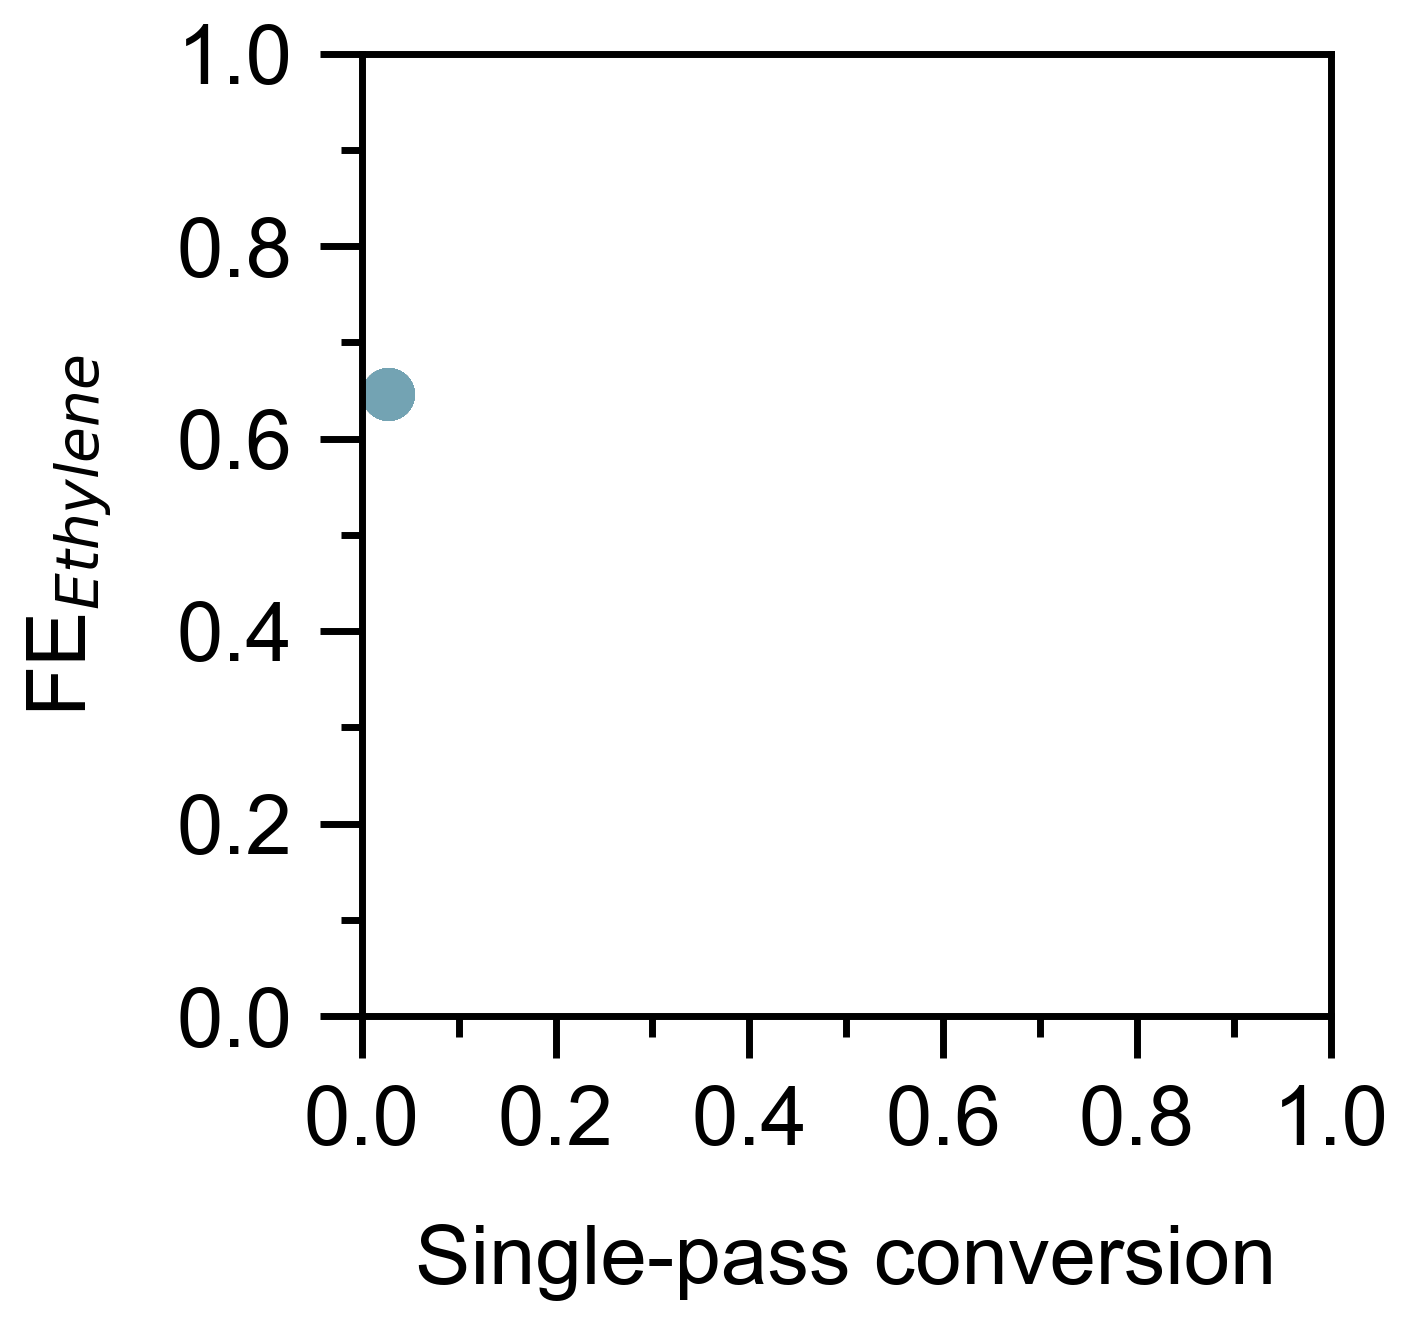

In [79]:
## Define axis limits and ticks

if override_one == True:
    fig, axs = plt.subplots() # Set up plot
    
    ## Axis labels
    axs.set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs.set_xlabel('Single-pass conversion') 

    ## Draw axis ticks
    axs.xaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs.yaxis.set_major_locator(mp.ticker.MultipleLocator(0.2))
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)

    ## Apply axis limits
    axs.set_xlim([0,1])
    axs.set_ylim([0,1])

    # Plot FE vs SPC
    axs.scatter(df_outlet_assumptions_vs_vbl.loc['Single-pass conversion'],
                df_outlet_assumptions_vs_vbl.loc['FE {}'.format(product_name)],
                            color = theme_colors[3], 
                            label = 'FE$_{{CO_2R, 0}}$ > {}'.format(min(df_electrolyzer_assumptions_vs_vbl.loc['FE {} at 0% SPC'.format(product_name)])),
                            s = 200, 
                            alpha = 1, marker = 'o') 
#     axs.scatter(df_products.loc[product_name, 'Typical SPC']*100, df_products.loc[product_name, 'FECO2R at SPC = 0']*100, 
#                 marker = 'X', c = 'k', s = 200, alpha = 1, label = 'Limits')
    
    # axs.legend(loc= 'lower right') # bbox_to_anchor = (1,1)
    
    ## Save figure 
    SPC_FE_fig_name = os.path.join(OP_folder,'{} SPC vs FE {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(SPC_FE_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(SPC_FE_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + SPC_FE_fig_name)
    
    plt.show()

## 4.6 Generate cost plots

### 4.6.1 Opex ($/kg) vs variable

C:\Users\shash\AppData\Local\Temp\ipykernel_13184\2824885939.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]],


Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Opex per kg vs Current density 06-09PM


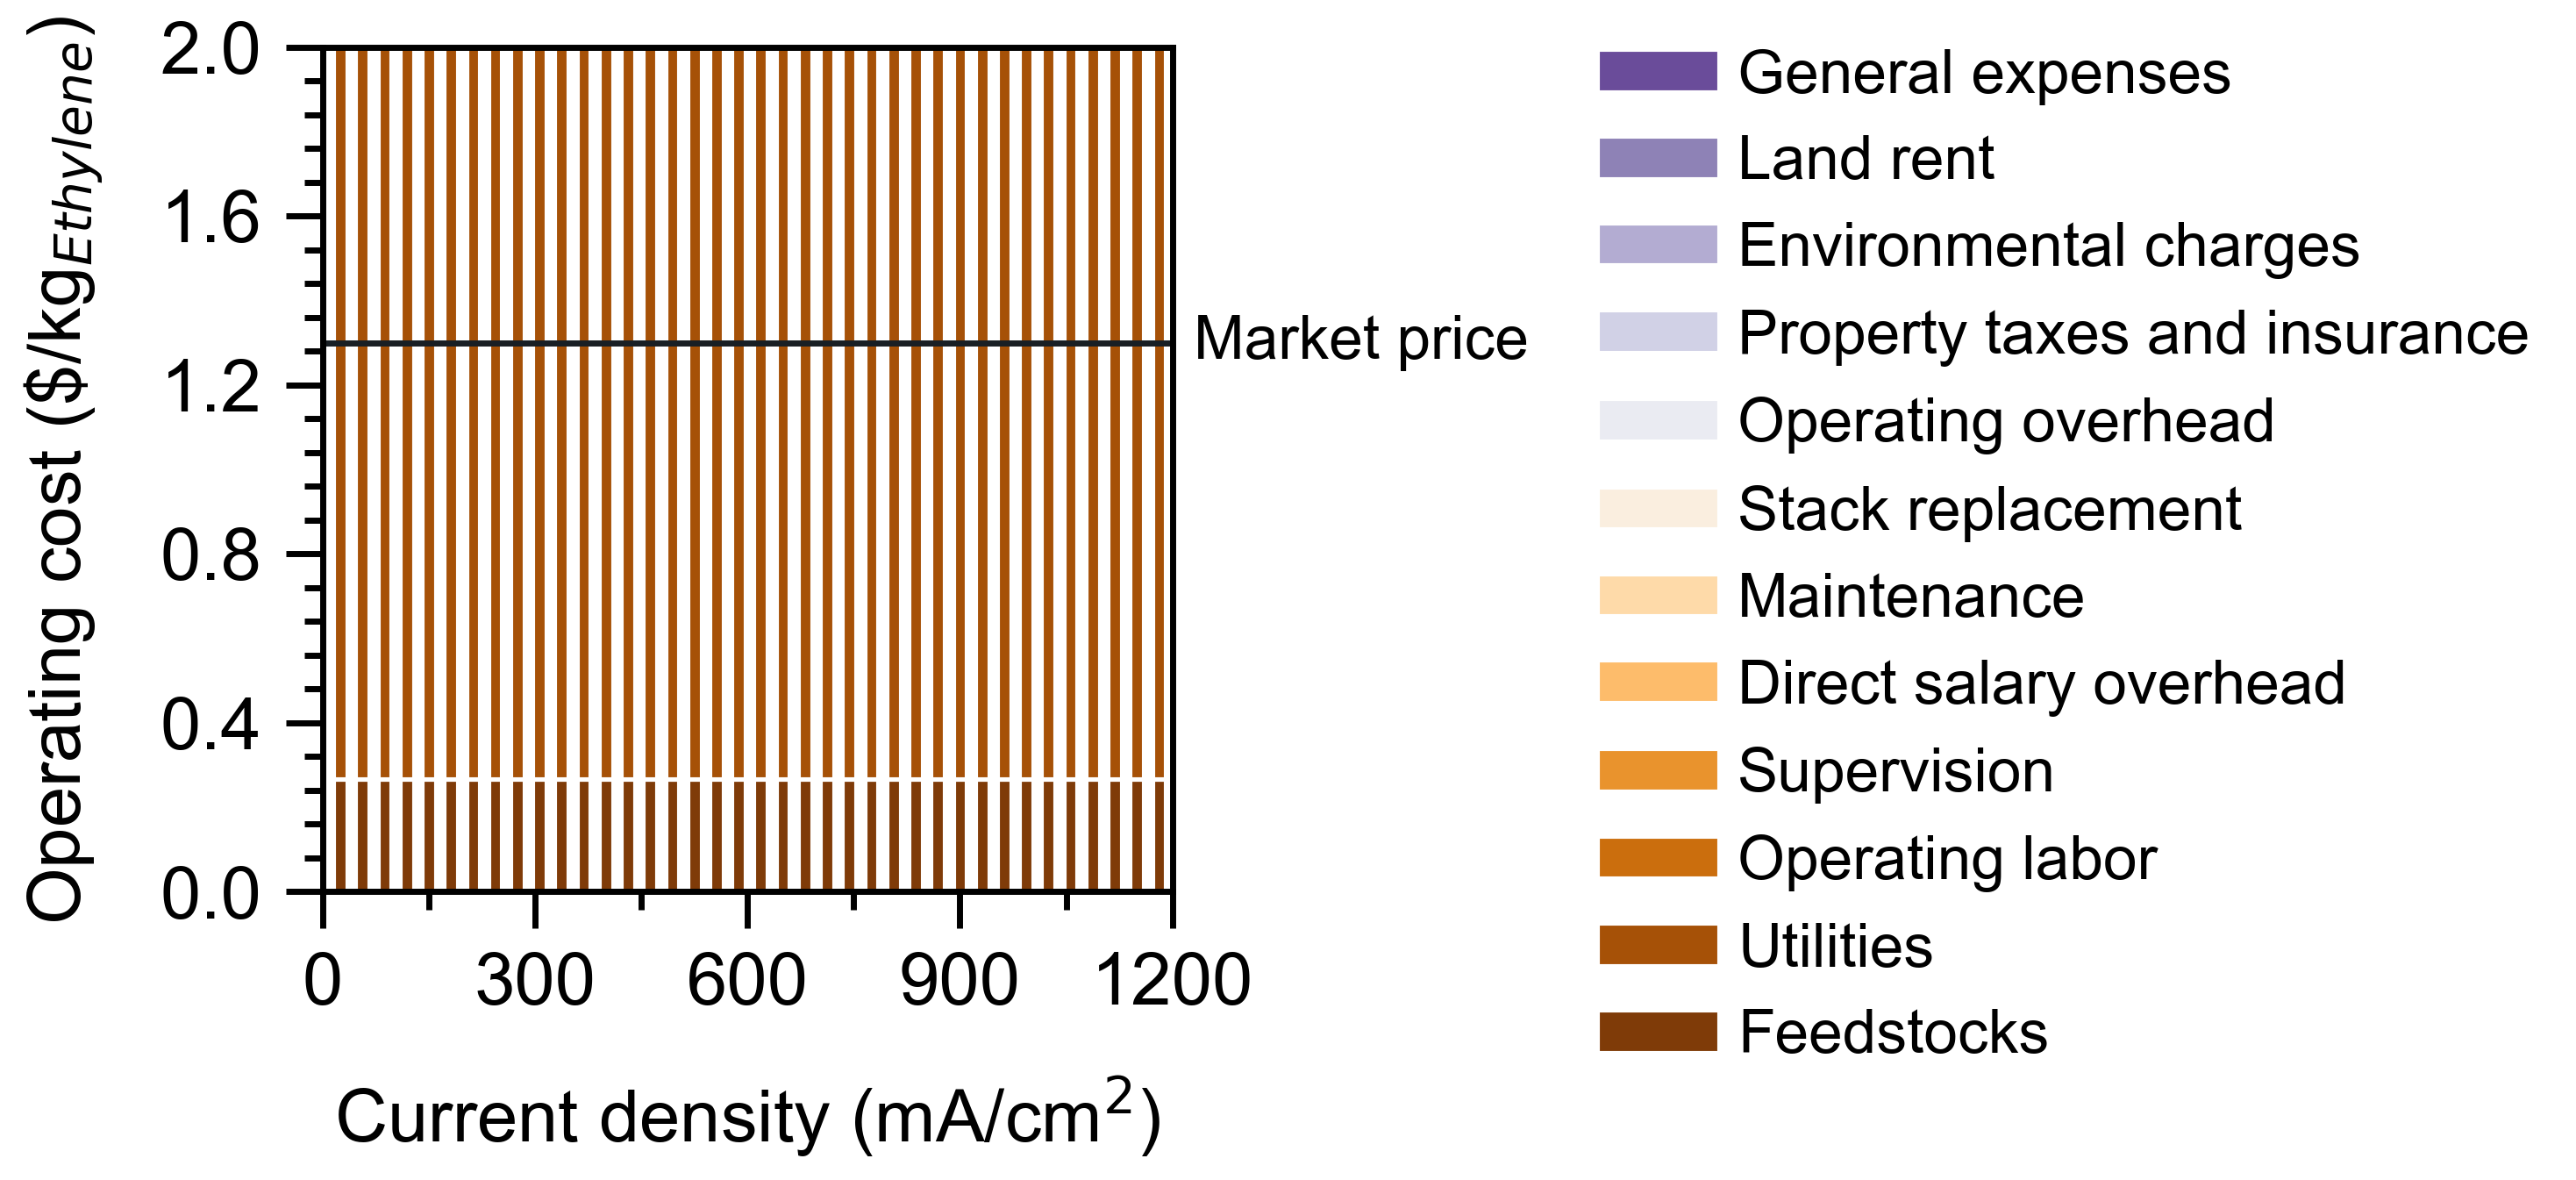

In [80]:
if override_one == True:
    # Plot operating costs per product over voltage range - bar chart. Not designed for variable product cost

    fig, axs = plt.subplots() # Set up plot

    y_axis_max =  min(2, np.ceil(max(np.sum(df_opex_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)], axis = 0))/0.5) * 0.5) # round to nearest 0.01)
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Operating cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    
    ## Plot series
    axs.plot([x_axis_min, x_axis_max], 
             [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]], 
             alpha = 1, c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)
    
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.loc[category]

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*0.975, 'U.S. average', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels

    ## Legend
    axs.legend(bbox_to_anchor=(1.4, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_fig_name = os.path.join(OP_folder, '{} Opex per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(opex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
     
    print('Saved at ' + opex_fig_name)
    
    plt.show()

### 4.6.2 Opex ($/day) vs variable

C:\Users\shash\AppData\Local\Temp\ipykernel_13184\226250946.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [df_costing_assumptions_vs_vbl.loc[product_name][0]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][0]/1000,
C:\Users\shash\AppData\Local\Temp\ipykernel_13184\226250946.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_costing_assumptions_vs_vbl.loc[product_name][-1]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][-1]/1000],


Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Opex per day vs Current density 06-09PM


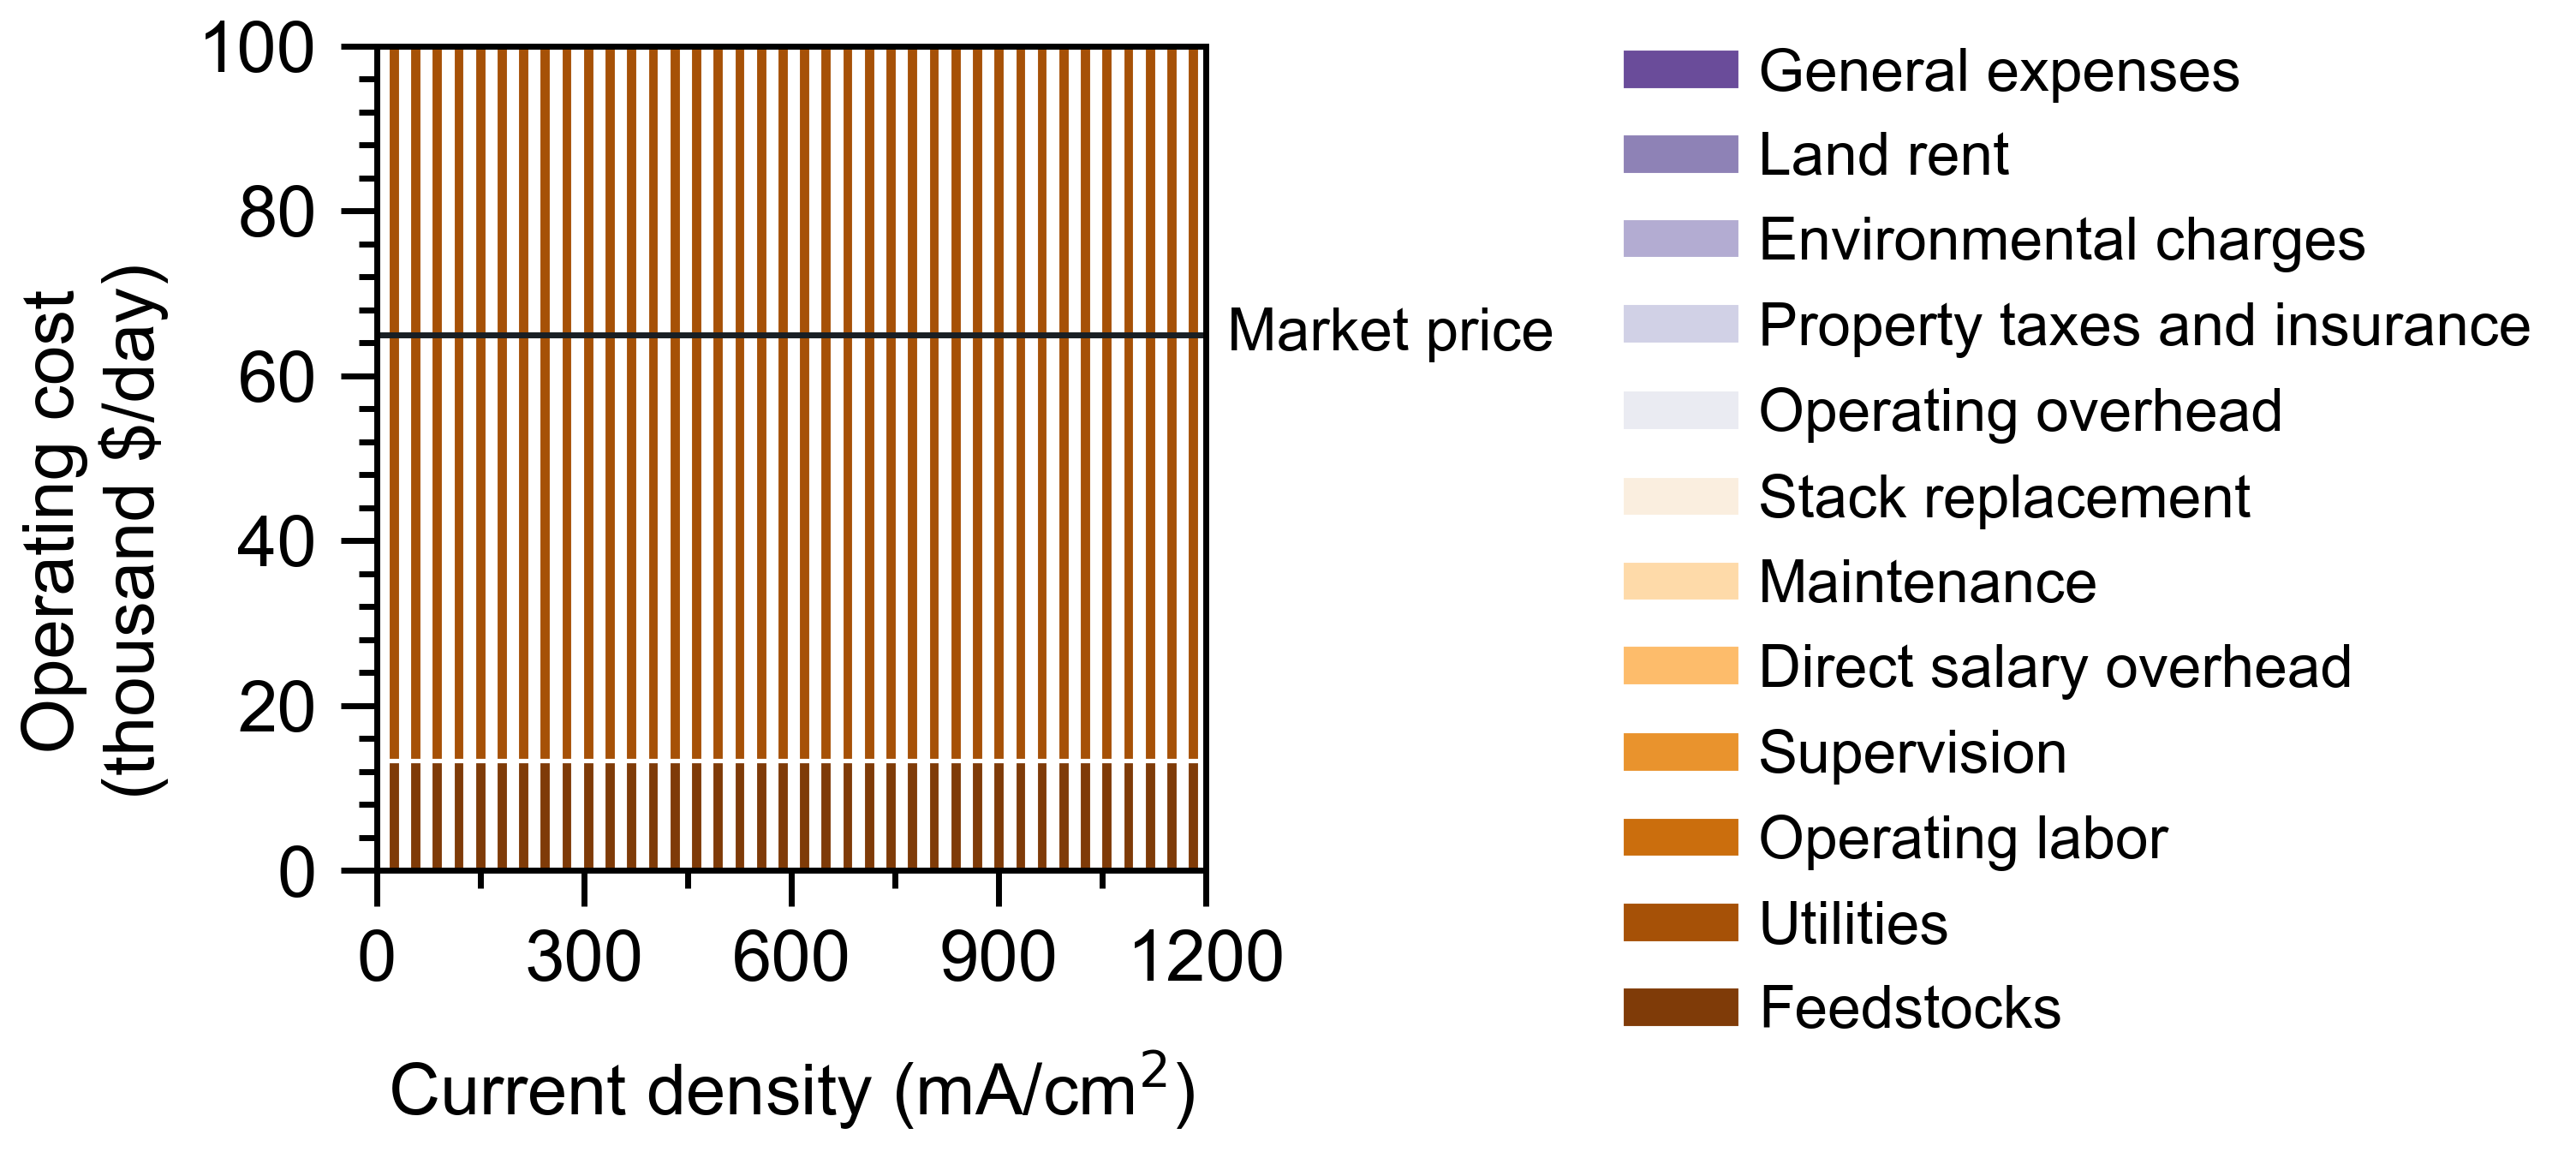

In [81]:
if override_one == True:
    # Plot operating costs per day over voltage range - bar chart. Not designed for variable product cost or production rate

    fig, axs = plt.subplots() # Set up plot 
    
    y_axis_max = 100 #  np.ceil(max(np.sum(df_opex_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'], axis = 0))/1000 / 10) * 10  # round to nearest 10
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 20
    y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    # if y_axis_max // 10 == y_axis_max/10:
    #     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('   Operating cost \n (thousand \$/day)')
    axs.yaxis.set_label_coords(-0.25, 0.4) # WARNING: manually placed y-label may cause misalignment issues
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min, y_axis_max])

    ## Plot series   
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.fillna(0).loc[category]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']/1000, label=category , bottom = cumsum, 
                width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.loc[category]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']/1000

    axs.plot([x_axis_min, x_axis_max], 
             [df_costing_assumptions_vs_vbl.loc[product_name][0]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][0]/1000,
             df_costing_assumptions_vs_vbl.loc[product_name][-1]*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'][-1]/1000],
             alpha = 1, c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod*product_rate_kg_day/1000, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*0.975, 'U.S. average', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels
        
    ## Legend
    axs.legend(bbox_to_anchor=(1.4, 1.1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex2_fig_name = os.path.join(OP_folder, '{} Opex per day vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex2_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex2_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex2_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex2_fig_name)
    
    plt.show()

### 4.6.3 Bare-module capex vs variable

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Capex vs Current density 06-09PM


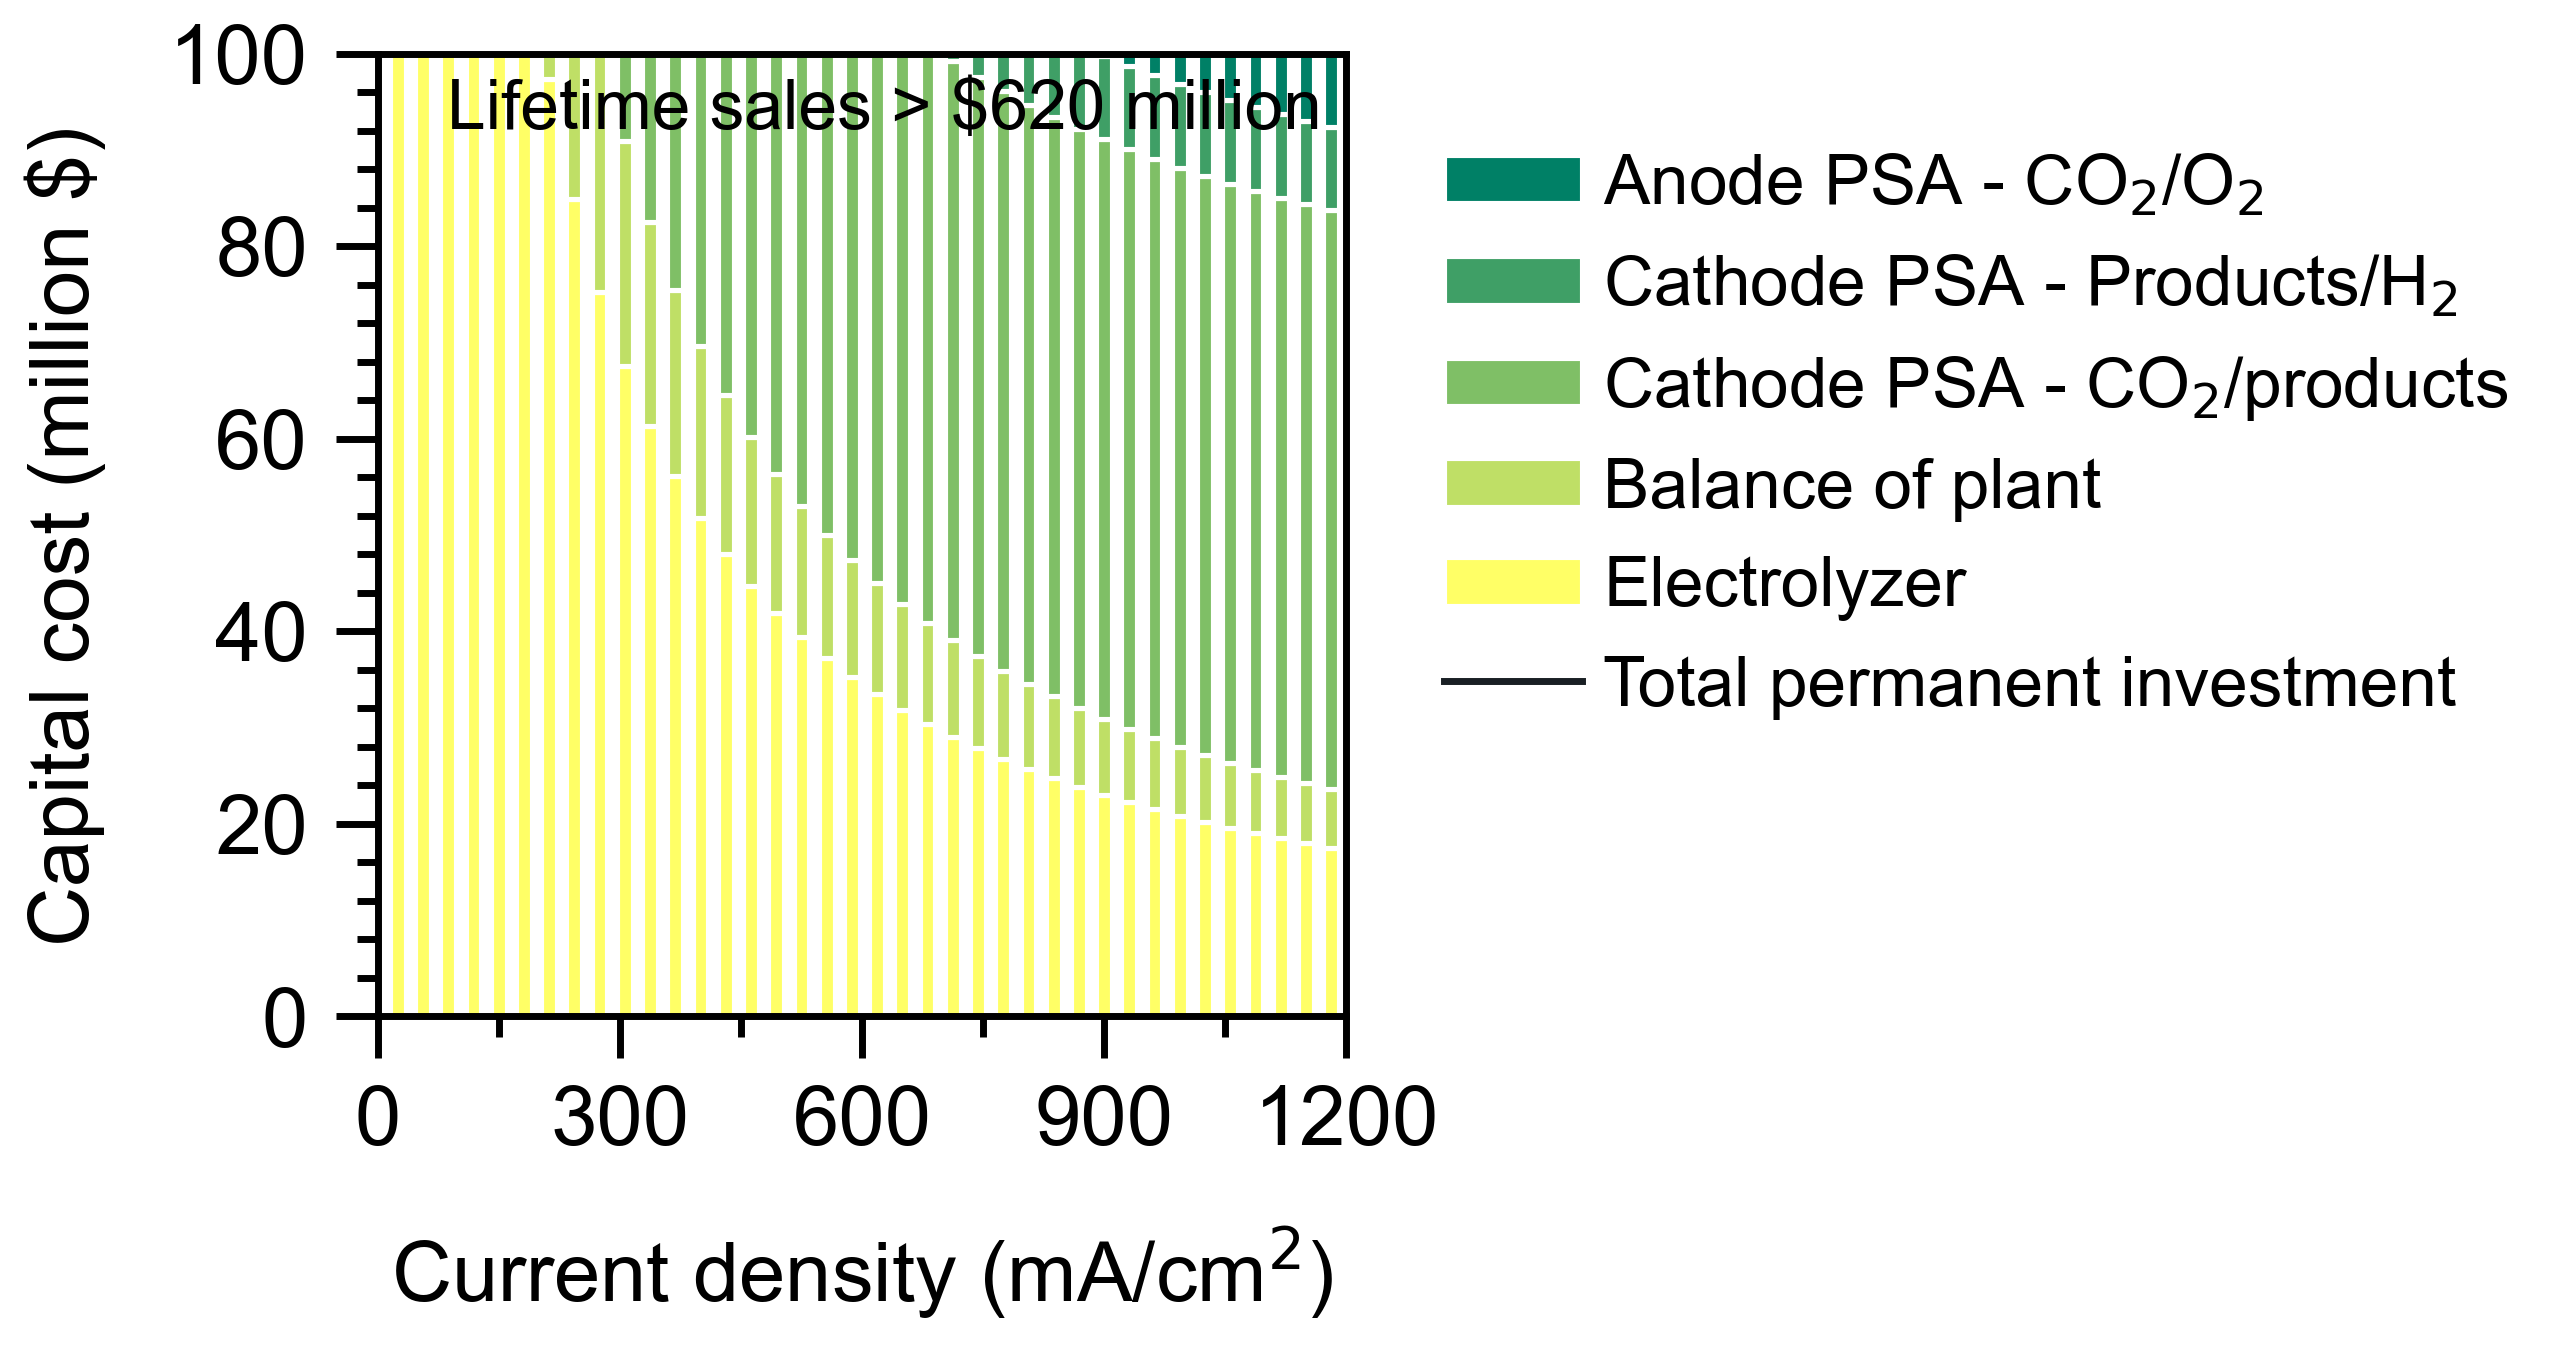

In [82]:
if override_one == True:
    # Plot capital costs for lifetime over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 100 #np.ceil(max(np.sum(df_capex_BM_vs_vbl.loc[:, ~np.isinf(df_opex_vs_vbl).any(axis=0)], axis = 0))/1e6 / 5) * 5  # round to nearest 5 million
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 20
#     y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    if y_axis_max // 10 == y_axis_max/10:
        y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
#     y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Capital cost (million \$)')
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    if df_flags.loc['Capacity factor', 'T/F?'] == True or df_flags.loc['Renewables capacity factor', 'T/F?'] == True:
        axs.plot([0.23625,0.23625], [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(0.23625, y_axis_min + (y_axis_max - y_axis_min)*0.025, 'Solar capacity', ha='right', va='bottom', #  (5.67 h/day)
              fontsize = SMALL_SIZE, rotation = 90)
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        axs.text(x_axis_max*0.1, y_axis_max*0.975, 'Lifetime sales', #.format(product_cost_USD_kgprod*product_rate_kg_day*capacity_factor*365*20/1e6), 
                 ha='left', va='top', 
              fontsize = SMALL_SIZE)
        axs.plot(vbl_range, df_sales_vs_vbl.loc['Total']*lifetime_years,
             alpha = 1, c = theme_colors[6]) # Plot line for cost 
        plt.xticks(rotation=35)  # Rotate text labels
    else:
        axs.text(x_axis_max*0.975, y_axis_max*0.975, 'Lifetime sales > ${:.0f} million'.format(min(df_sales_vs_vbl.loc['Total', df_sales_vs_vbl.loc['Total'] > 0]*lifetime_years)/1e6), ha='right', va='top', 
              fontsize = SMALL_SIZE)
    
    cumsum = 0
    for i, category in enumerate(df_capex_BM_vs_vbl.index):
        axs.bar(vbl_range, df_capex_BM_vs_vbl.fillna(0).loc[category]/1e6, label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/1e6
    axs.plot(vbl_range[df_capex_totals_vs_vbl.loc['Total permanent investment'] > 0], 
            df_capex_totals_vs_vbl.loc['Total permanent investment', df_capex_totals_vs_vbl.loc['Total permanent investment'] > 0]/1e6, # All capex except working capital, which is recovered during operation
            label = 'Total permanent investment', alpha = 1, c = theme_colors[6]) # Plot line for Total permanent investment cost 

    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    capex_fig_name = os.path.join(OP_folder, '{} Capex vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(capex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_fig_name + '.jpg', transparent = True,  dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_fig_name)

    plt.show()

### 4.6.4 Levelized capex and opex per kg vs variable

C:\Users\shash\AppData\Local\Temp\ipykernel_13184\3116239268.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]],


Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Opex and capex per kg vs Current density 06-09PM


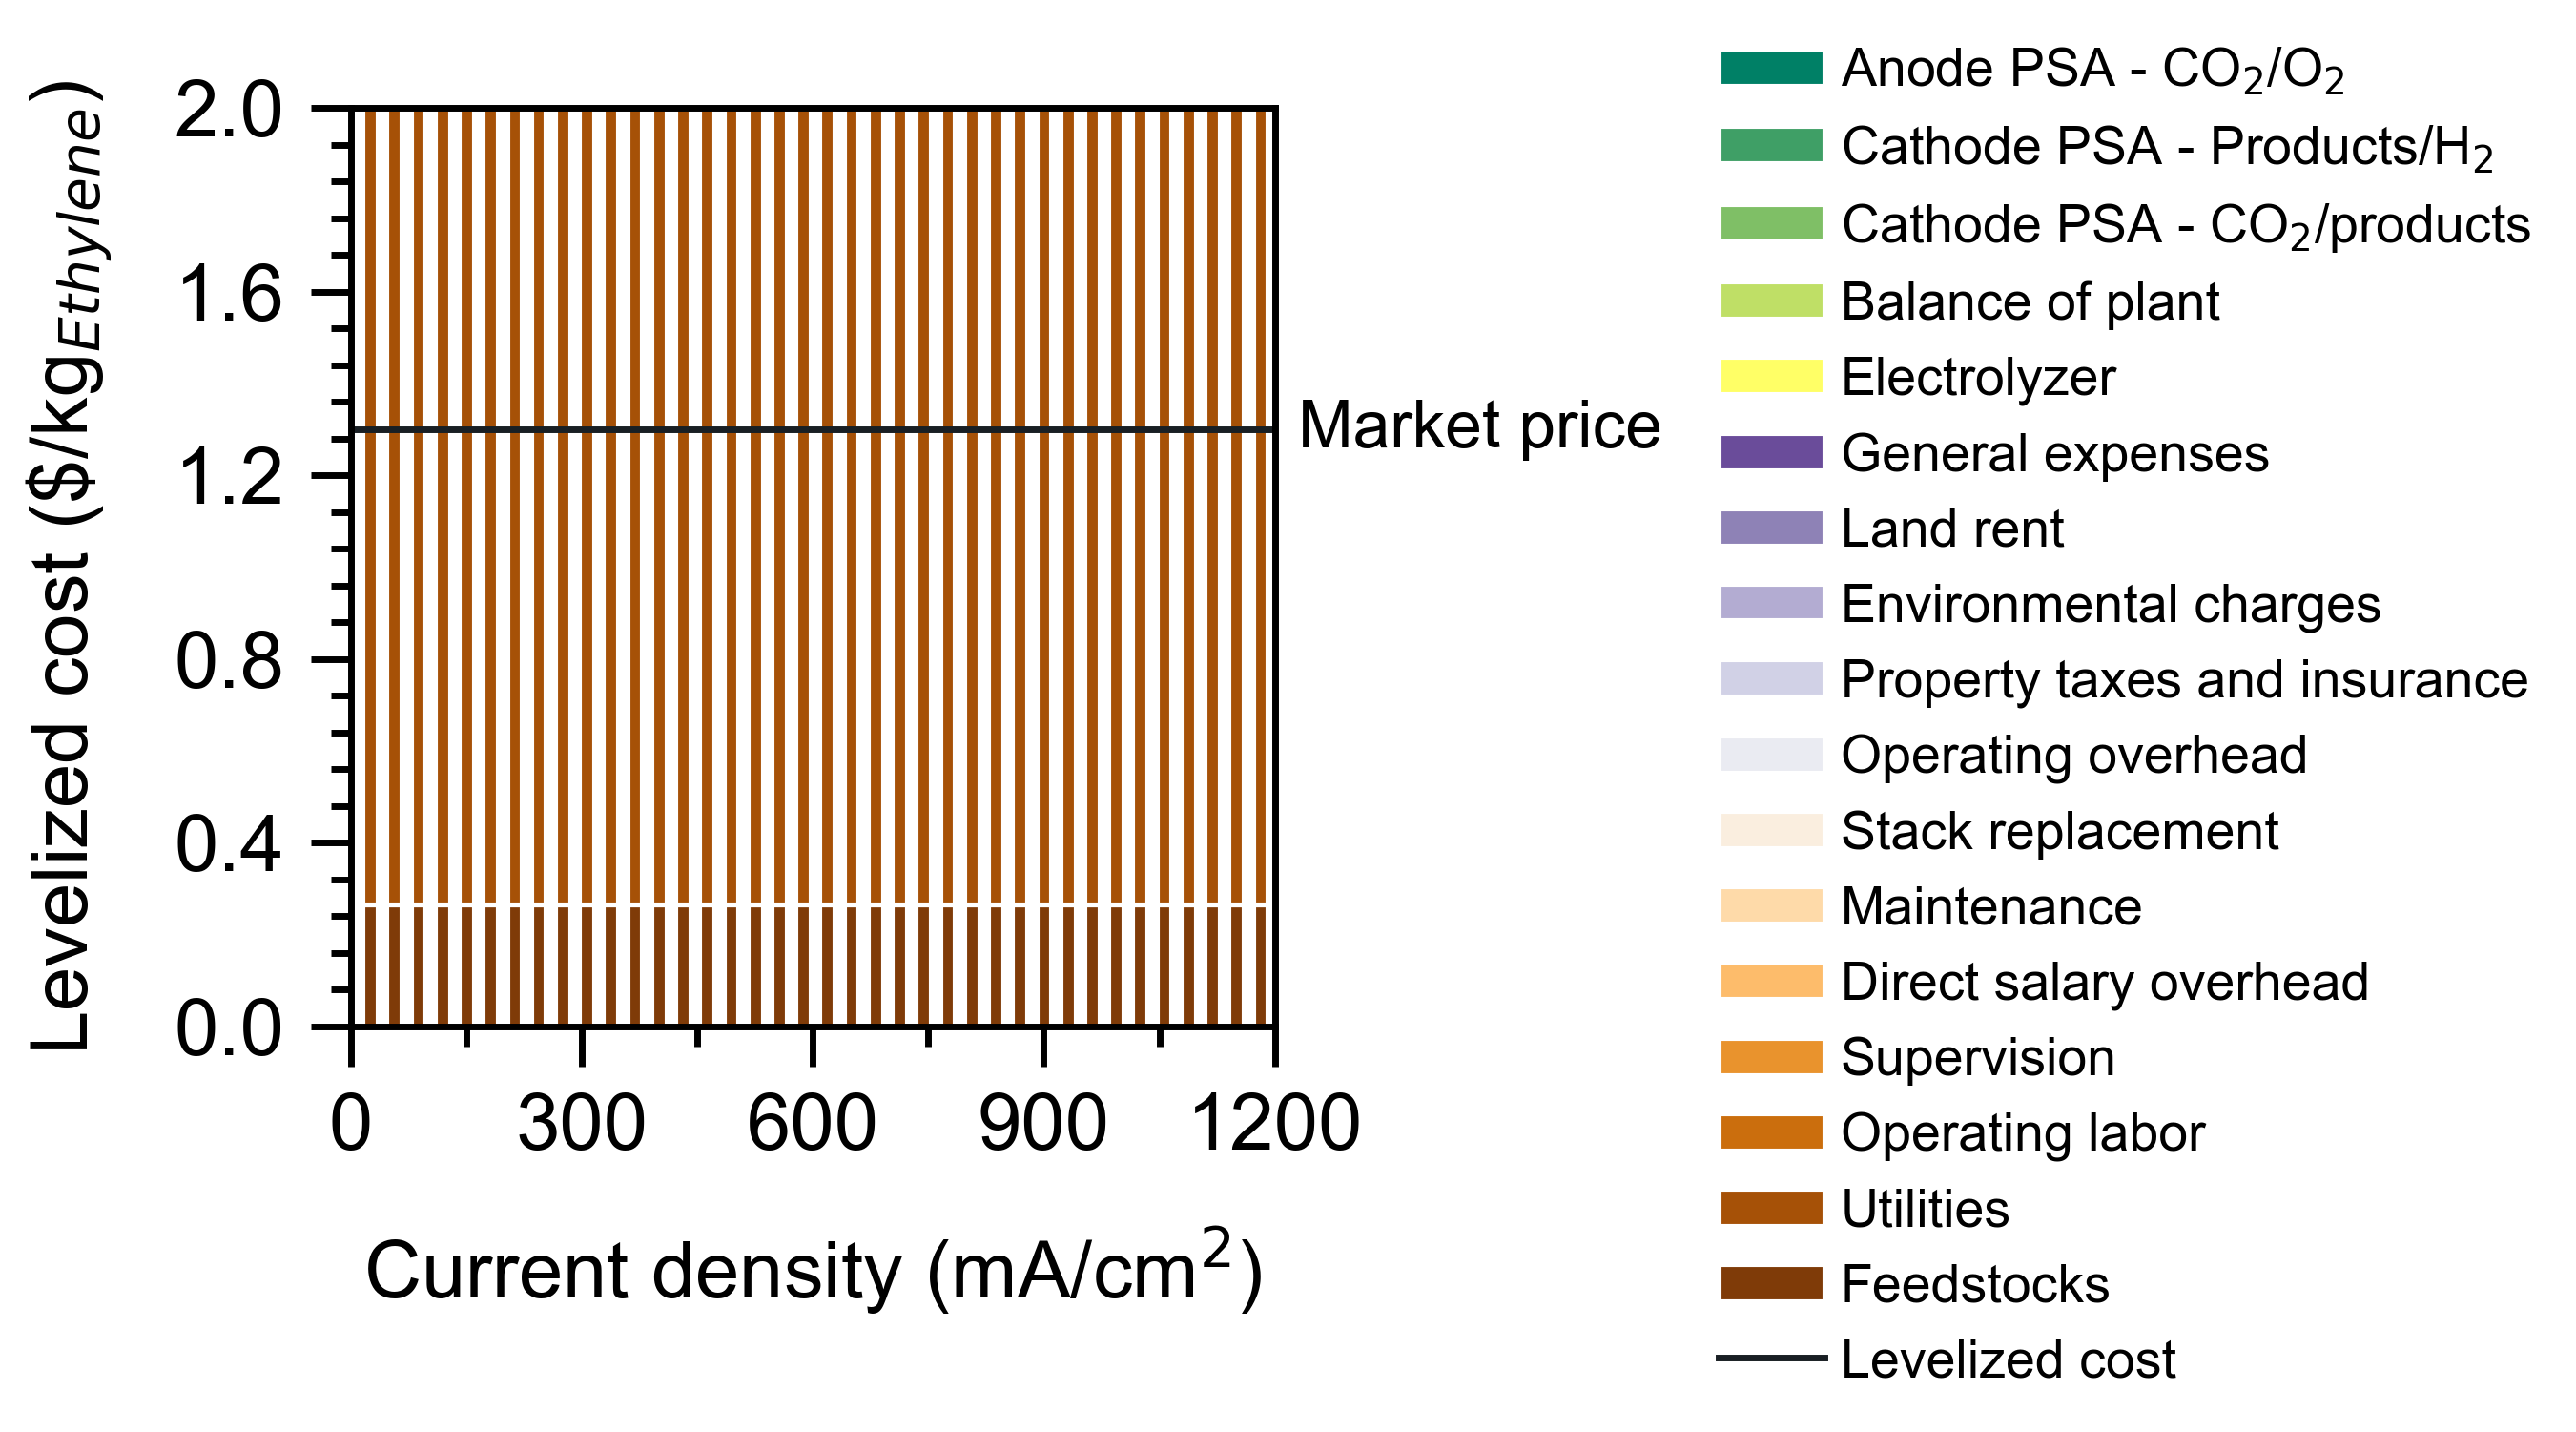

In [83]:
if override_one == True:
    # Plot capex and opex per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 2 # min ( 2, np.ceil( max(df_opex_totals_vs_vbl.loc['Levelized cost', ~np.isinf(df_opex_totals_vs_vbl).any(axis=0)]) / 0.5 ) * 0.5 ) # round to nearest 0.5

    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    axs.plot([x_axis_min, x_axis_max],
             [df_costing_assumptions_vs_vbl.loc[product_name][0],df_costing_assumptions_vs_vbl.loc[product_name][-1]],
             alpha = 1, 
             c = theme_colors[6]) # Plot line for cost 
    axs.text(x_axis_max * 1.025, product_cost_USD_kgprod, 'Market price', ha='left', va='center', 
              fontsize = SMALL_SIZE)
    
    # Additional lines
    if df_flags.loc['Capacity factor', 'T/F?'] == True or df_flags.loc['Renewables capacity factor', 'T/F?'] == True:
        axs.plot([0.23625,0.23625], [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for solar 
        axs.text(0.23625, y_axis_max*0.975, 'Average solar', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
#     axs.plot([0.0677,0.0677], [y_axis_min, y_axis_max], alpha = 1,
#              c = theme_colors[6]) # Plot line for solar 
#     axs.text(0.0677, y_axis_max*0.975, 'Texas (EIA, Jul 2023)', ha='right', va='top', 
#               fontsize = SMALL_SIZE, rotation = 90)

    axs.plot(vbl_range[df_opex_totals_vs_vbl.loc['Levelized cost'] > 0], 
             df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] > 0],
             label = 'Levelized cost', alpha = 1, c = theme_colors[6]) # Plot line for total levelized cost
            # Levelized cost includes all capex except working capital, which is recovered during operation
    
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs.bar(vbl_range, df_opex_vs_vbl.fillna(0).loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_opex_vs_vbl.fillna(0).loc[category]
        
    for i, category in enumerate(df_capex_BM_vs_vbl.index):
        axs.bar(vbl_range, df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']),
                label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i],
               edgecolor = 'w', linewidth = linewidth_calc)
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'])
    
    if df_flags.loc['{} production rate'.format(product_name), 'T/F?'] == True:
        plt.xticks(rotation=35)  # Rotate text labels

    if df_flags.loc['Electricity cost', 'T/F?'] == True:
        axs.text(df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                 y_axis_max*0.975, 'U.S. average industrial', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 

    ## Legend
    axs.legend(ncol = 1, bbox_to_anchor=(1.4, 1.15), loc='upper left', reverse = True, fontsize = 16) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    opex_capex_fig_name = os.path.join(OP_folder, '{} Opex and capex per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_capex_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_capex_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_capex_fig_name)
    
    plt.show()

## 4.7 Generate emissions plots

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Emissions per kg vs Current density 06-09PM


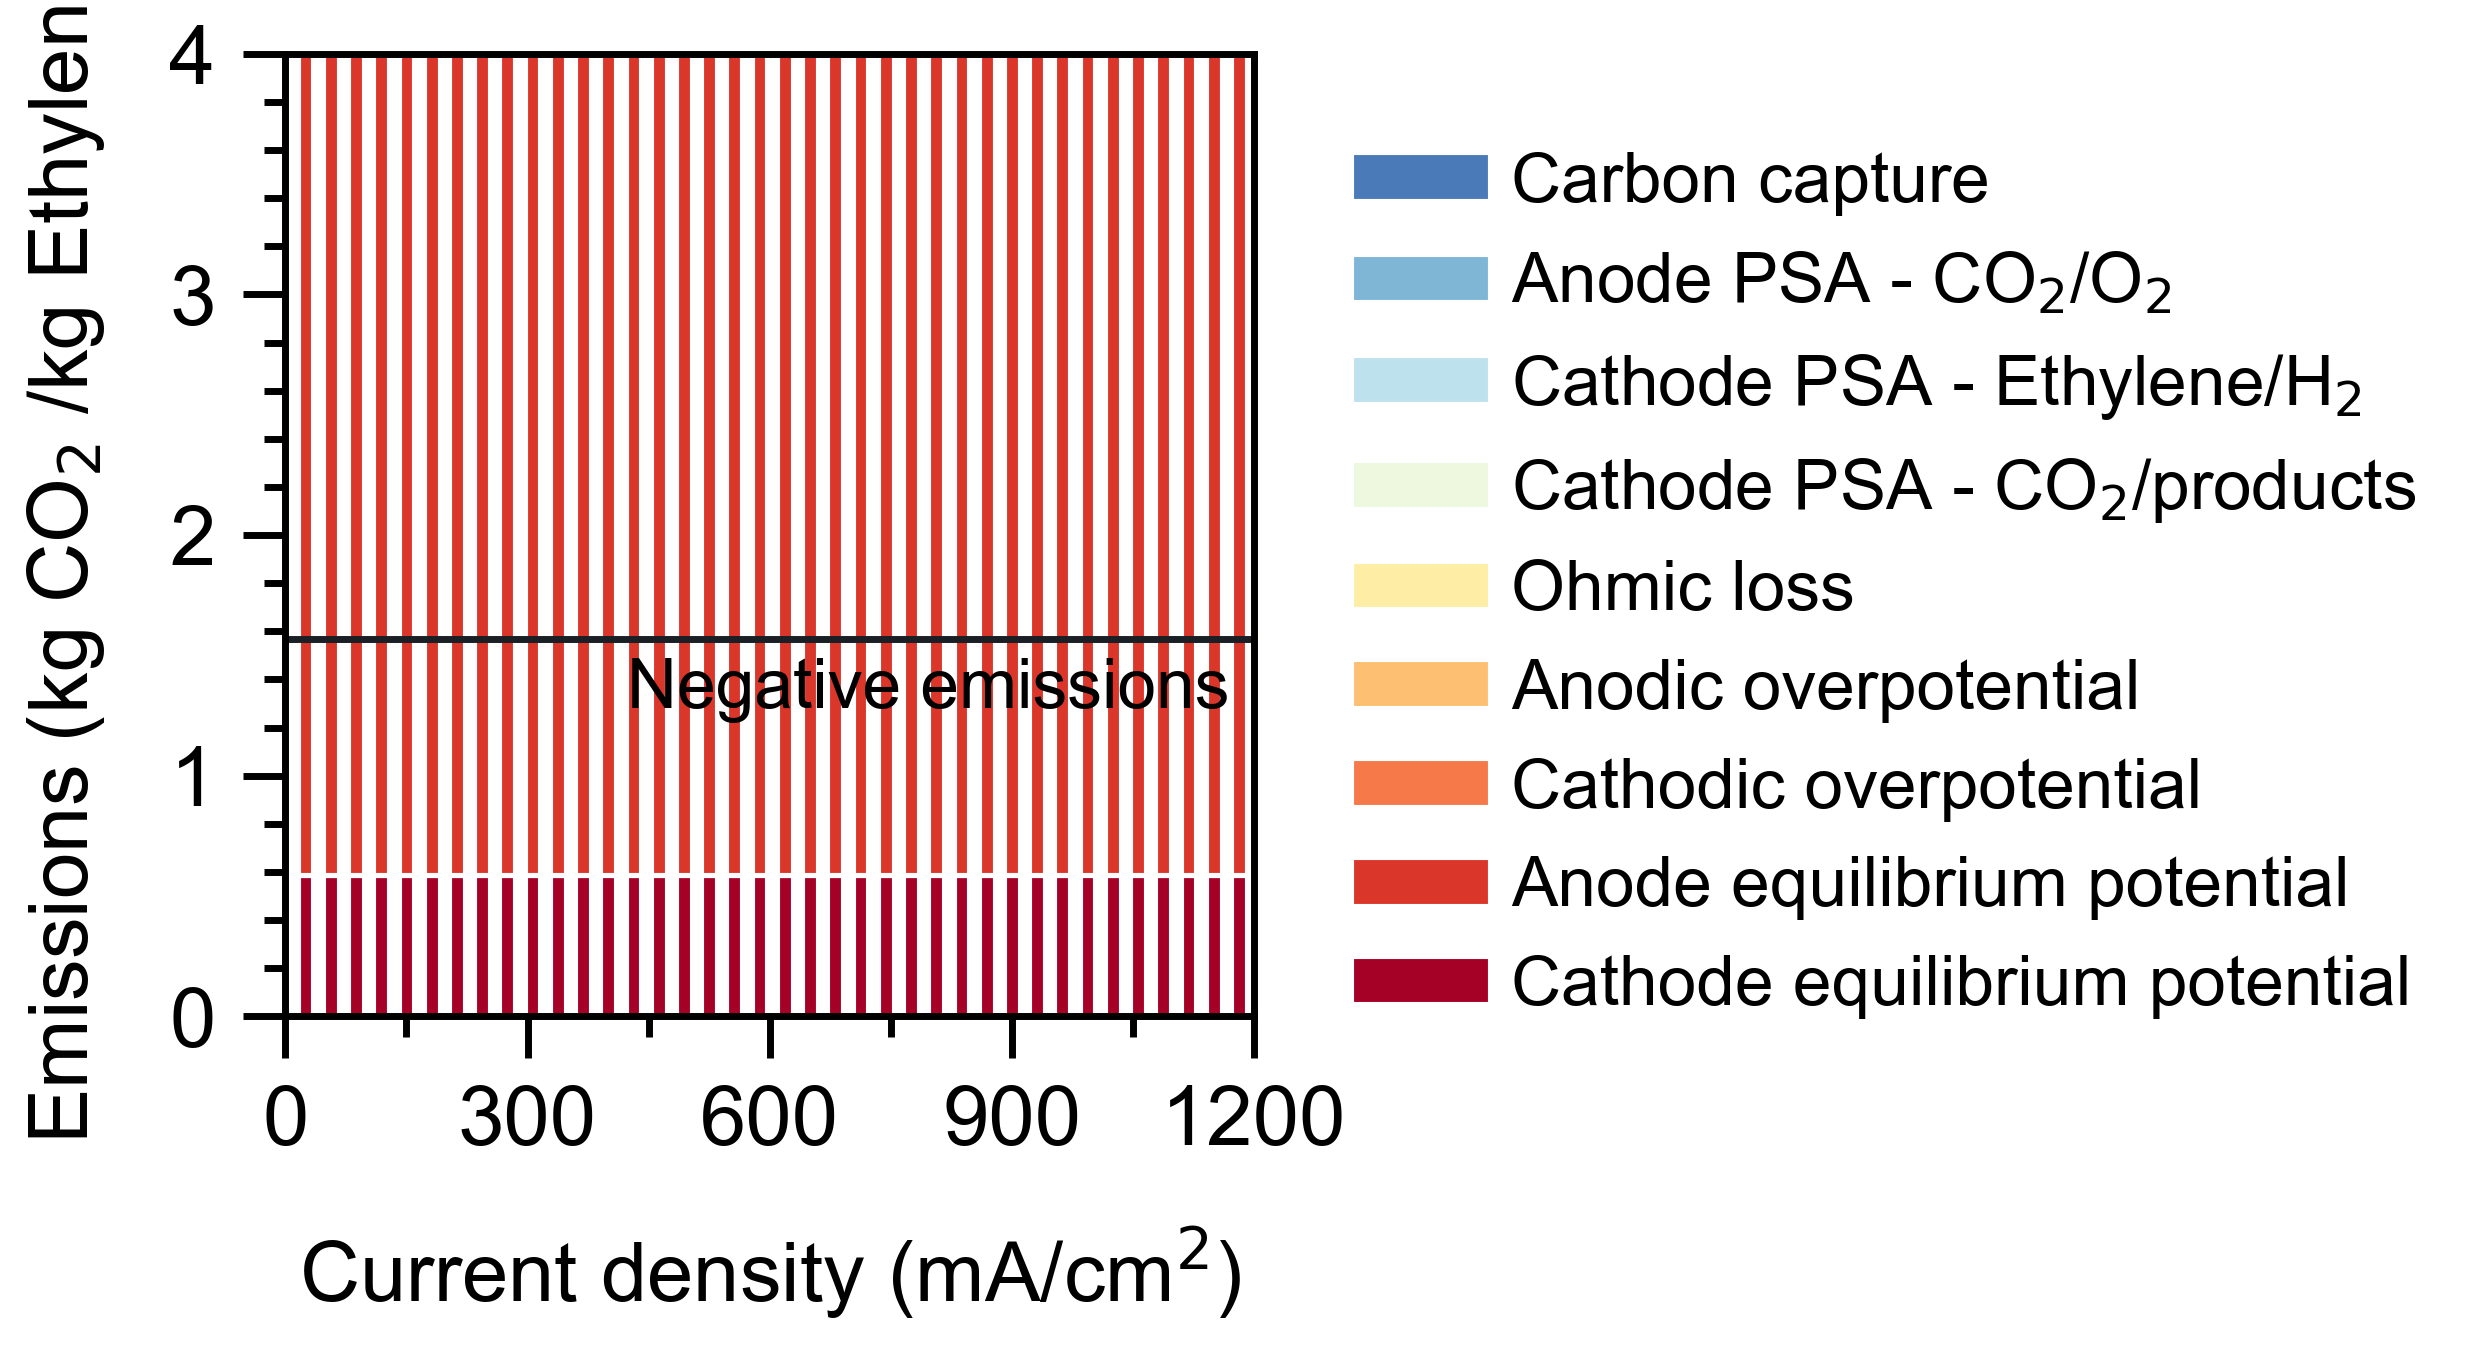

In [84]:
if override_one == True:
    # Plot emissions per kg product over voltage range - bar chart
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 4 # np.ceil(max(df_emissions_vs_vbl.loc['Total'])/1) * 1 # round to nearest 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 5
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Emissions (kg CO$_2$ /kg {})'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    axs.plot([x_axis_min, x_axis_max], [MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)'],MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)']], alpha = 1,
             c = theme_colors[6]) # Plot line for negative emissions
    axs.text(x_axis_max * 0.975, MW_CO2/df_products.loc[product_name, 'Molecular weight (g/mol)']*0.95, 'Negative emissions', ha='right', va='top', 
              fontsize = SMALL_SIZE)
    if df_flags.loc['Grid CO$_2$ intensity', 'T/F?'] == True:
        axs.plot([df_utility_imports.loc['Electricity - current US mix', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - current US mix', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - current US mix','CO2 emissions (g CO2/kWh)']/1000, 
                 y_axis_max*0.975, 'U.S. mix', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        
        axs.plot([df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - current California mix', 'CO2 emissions (g CO2/kWh)']/1000, 
                 y_axis_max*0.975, 'California mix', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
        
        axs.plot([df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000,df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000], 
                 [y_axis_min, y_axis_max], alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(df_utility_imports.loc['Electricity - solar', 'CO2 emissions (g CO2/kWh)']/1000, 
                         y_axis_max*0.975, 'Solar', ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 90)
   
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_emissions_vs_vbl.drop(['Total', 'Cell potential', 'Efficiency vs LHV'], inplace = False, errors = 'ignore').index):
        if not df_emissions_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_emissions_vs_vbl.fillna(0).loc[category]), label=category , 
                    bottom = cumsum, width = barwidth, color = emissions_colors[counter],
            edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_emissions_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    emissions_fig_name = os.path.join(OP_folder,'{} Emissions per kg vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(emissions_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(emissions_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + emissions_fig_name)
    
    plt.show()

## 4.8 Generate energy plots

### 4.8.1 Plot cell voltages vs variable

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Potentials vs Current density 06-09PM


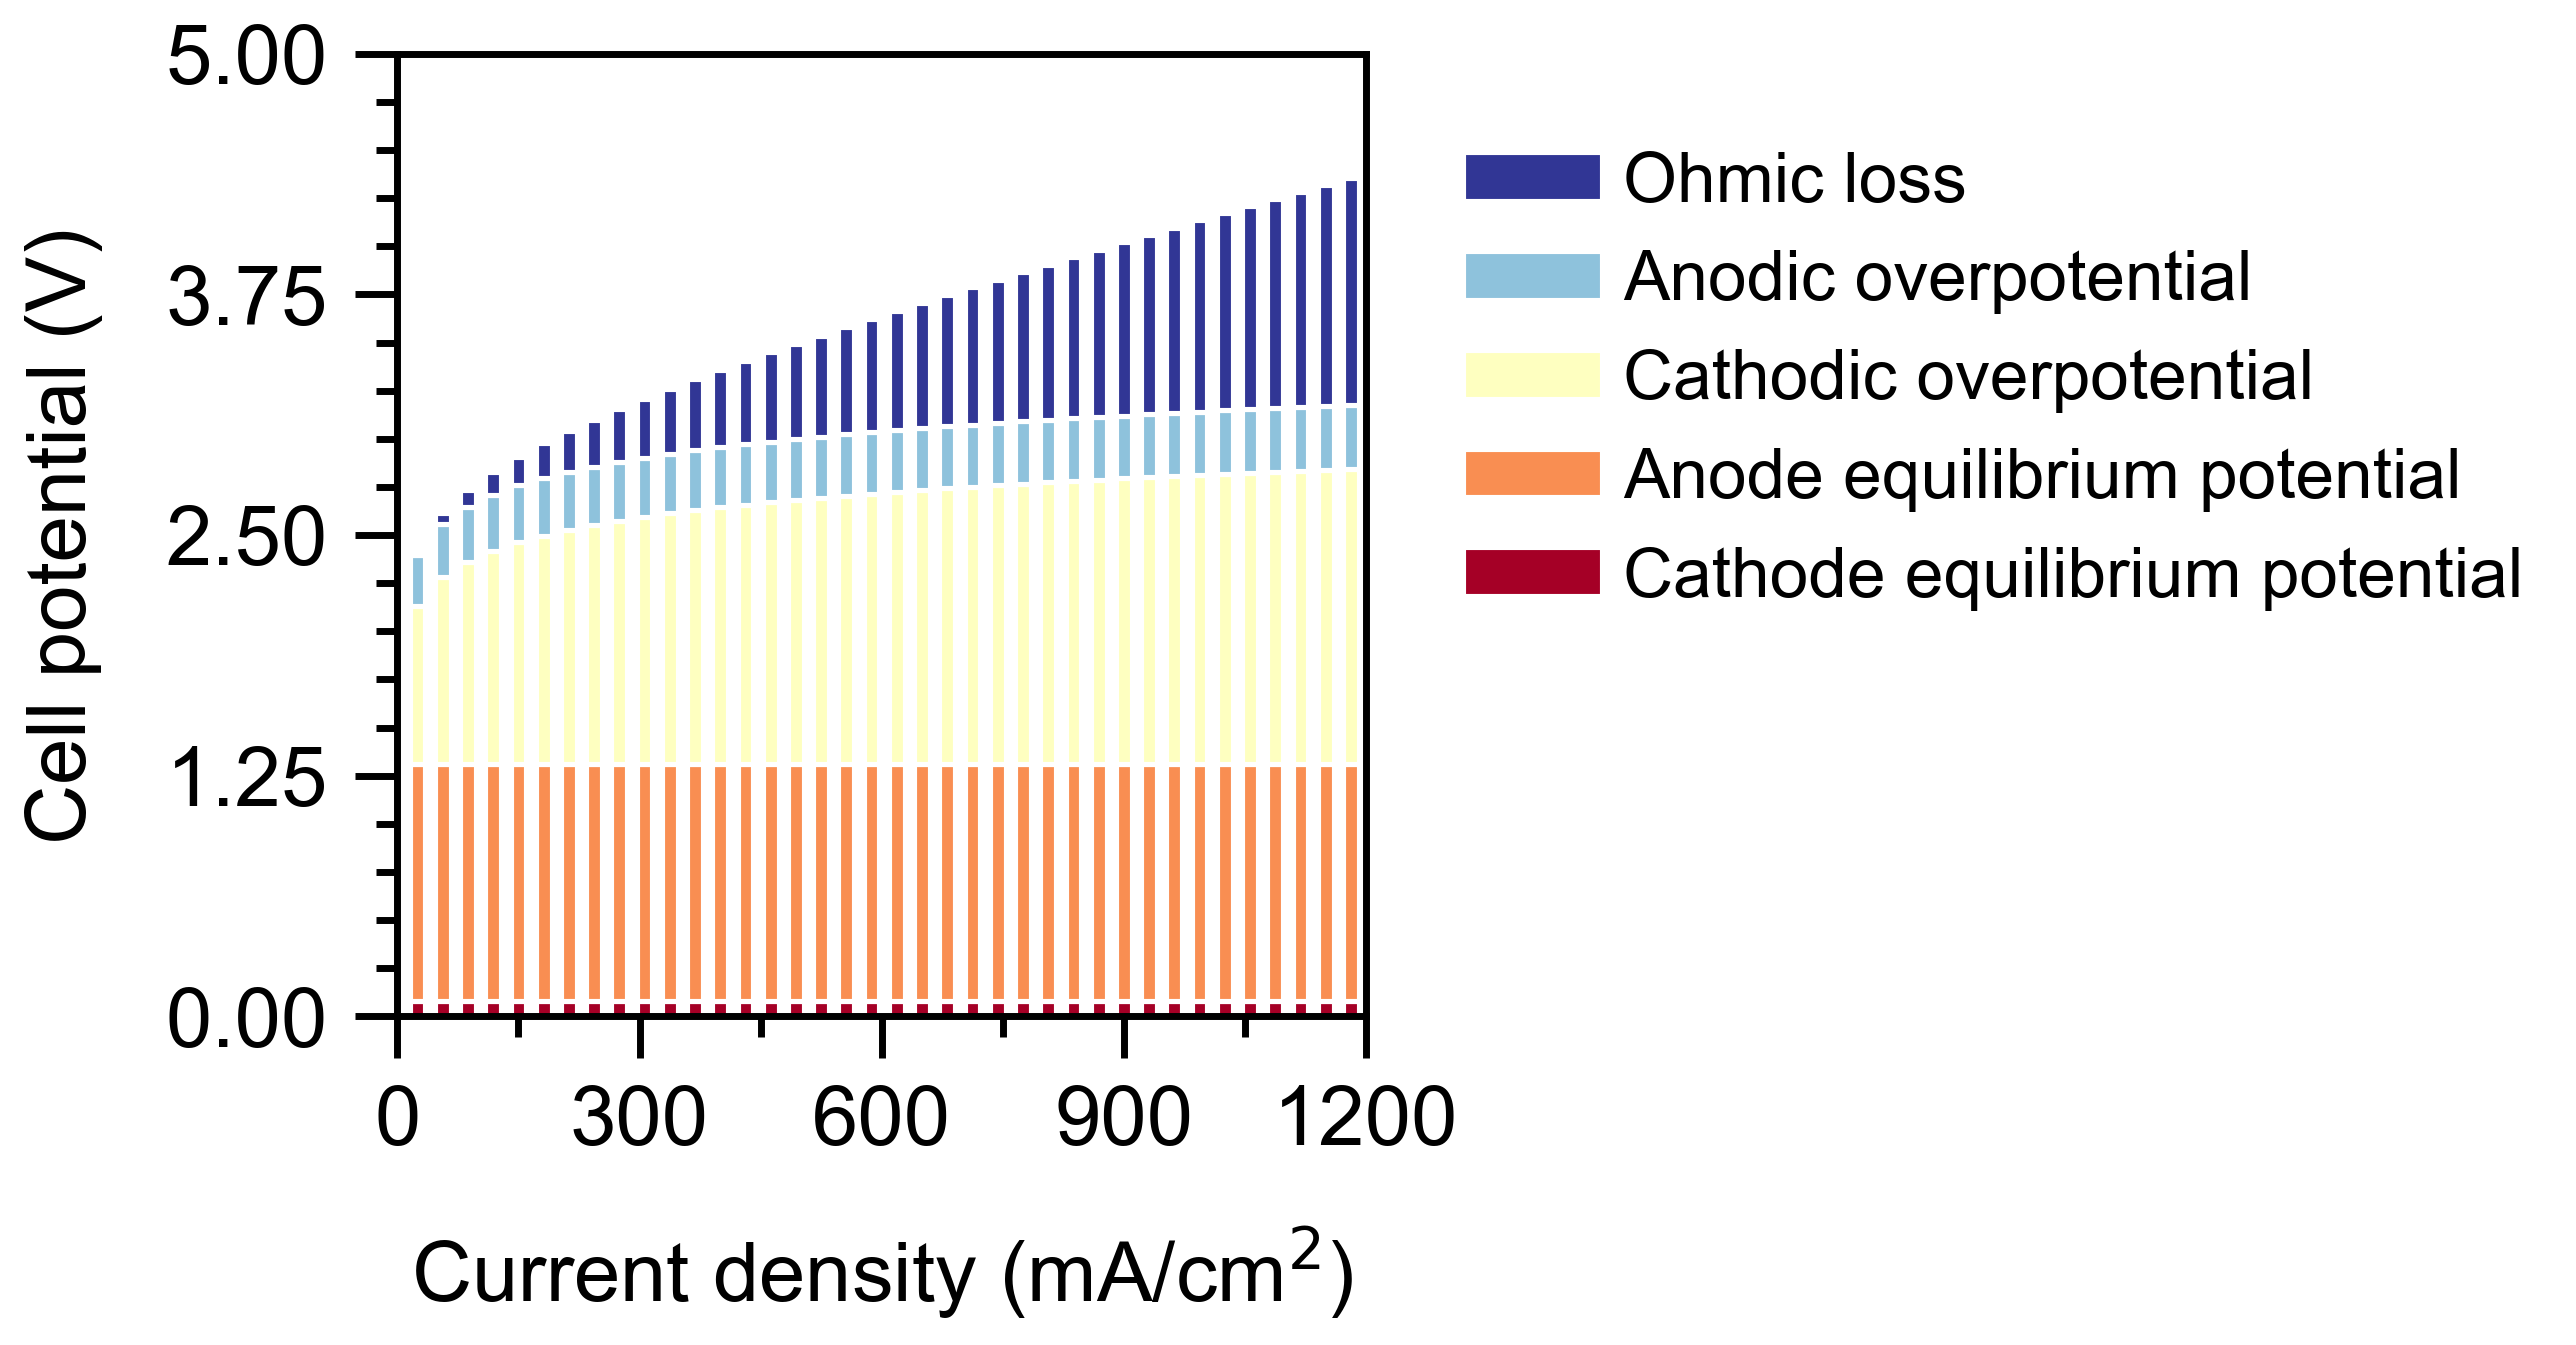

In [85]:
if override_one == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = np.ceil(max(abs(df_potentials_vs_vbl.fillna(0).loc['Cell potential']))/1) * 1 # round to nearest 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 5 # 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range

    ## Axis labels
    axs.set_ylabel('Cell potential (V)')
    axs.set_xlabel(x_axis_label)

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(True)
    axs.spines['top'].set_visible(True)

    ## Draw axis ticks
    plt.minorticks_on()
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])
    #axs.set_ylim([i_.iloc[:,0].min(axis=0),i_.iloc[:,0].max(axis=0)])

    ## Plot title
    # axs.set_title('Chronoamperometry at {:.3f} V for {:.2f} hrs'.format(vbl_we_avg, expt_time) )

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_potentials_vs_vbl.iloc[2:7].index):
        if not df_potentials_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_potentials_vs_vbl.fillna(0).loc[category]), label=category , bottom = cumsum, 
                    width = barwidth, color = potentials_colors[counter],
               edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_potentials_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    E_fig_name = os.path.join(OP_folder,'{} Potentials vs {} {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(E_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(E_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(E_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + E_fig_name)
    
    plt.show()

### 4.8.2 Generate energy plots

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Energy vs Current density, kg 06-09PM


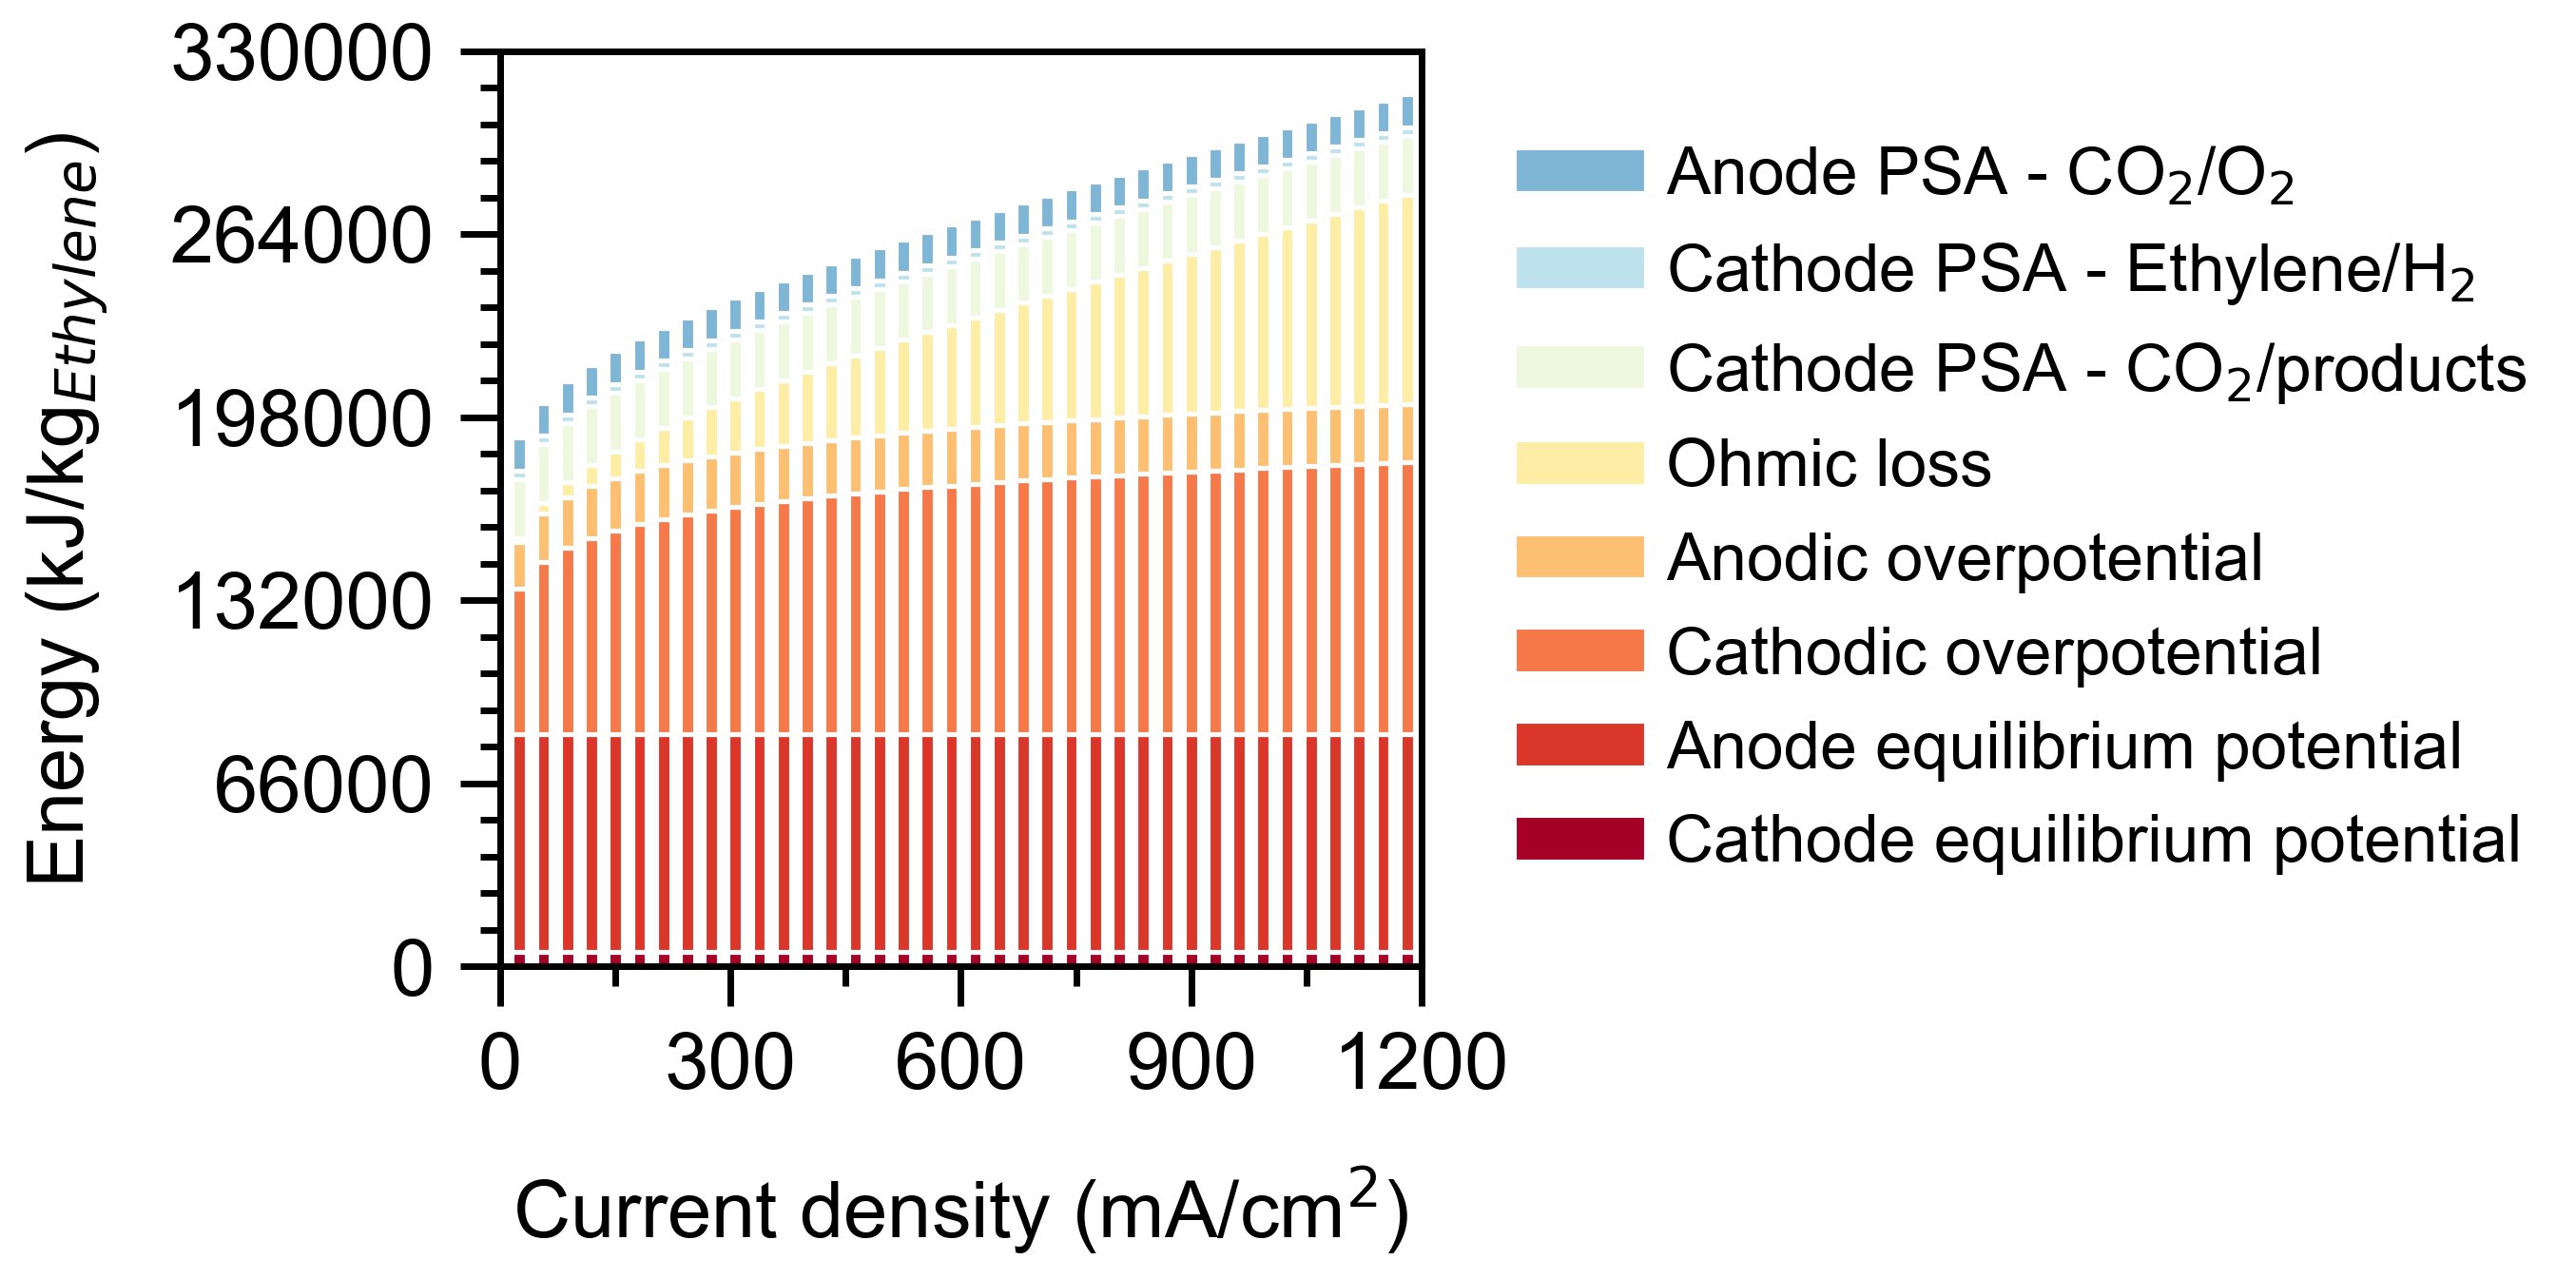

In [86]:
if override_one == True:
    
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = np.ceil(max(abs(df_energy_vs_vbl.loc['Total']))/1e4) * 1e4 # round to nearest 1e3
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Energy (kJ/kg$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_energy_vs_vbl.iloc[:-3].index):
        if not df_energy_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, abs(df_energy_vs_vbl.fillna(0).loc[category]), label=category , 
                    bottom = cumsum, width = barwidth, color = energy_colors[counter],
               edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += abs(df_energy_vs_vbl.fillna(0).loc[category])
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    energy_fig_name = os.path.join(OP_folder,'{} Energy vs {}, kg {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(energy_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + energy_fig_name)
    
    plt.show()

Saved at D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Energy vs Current density, mol 06-09PM


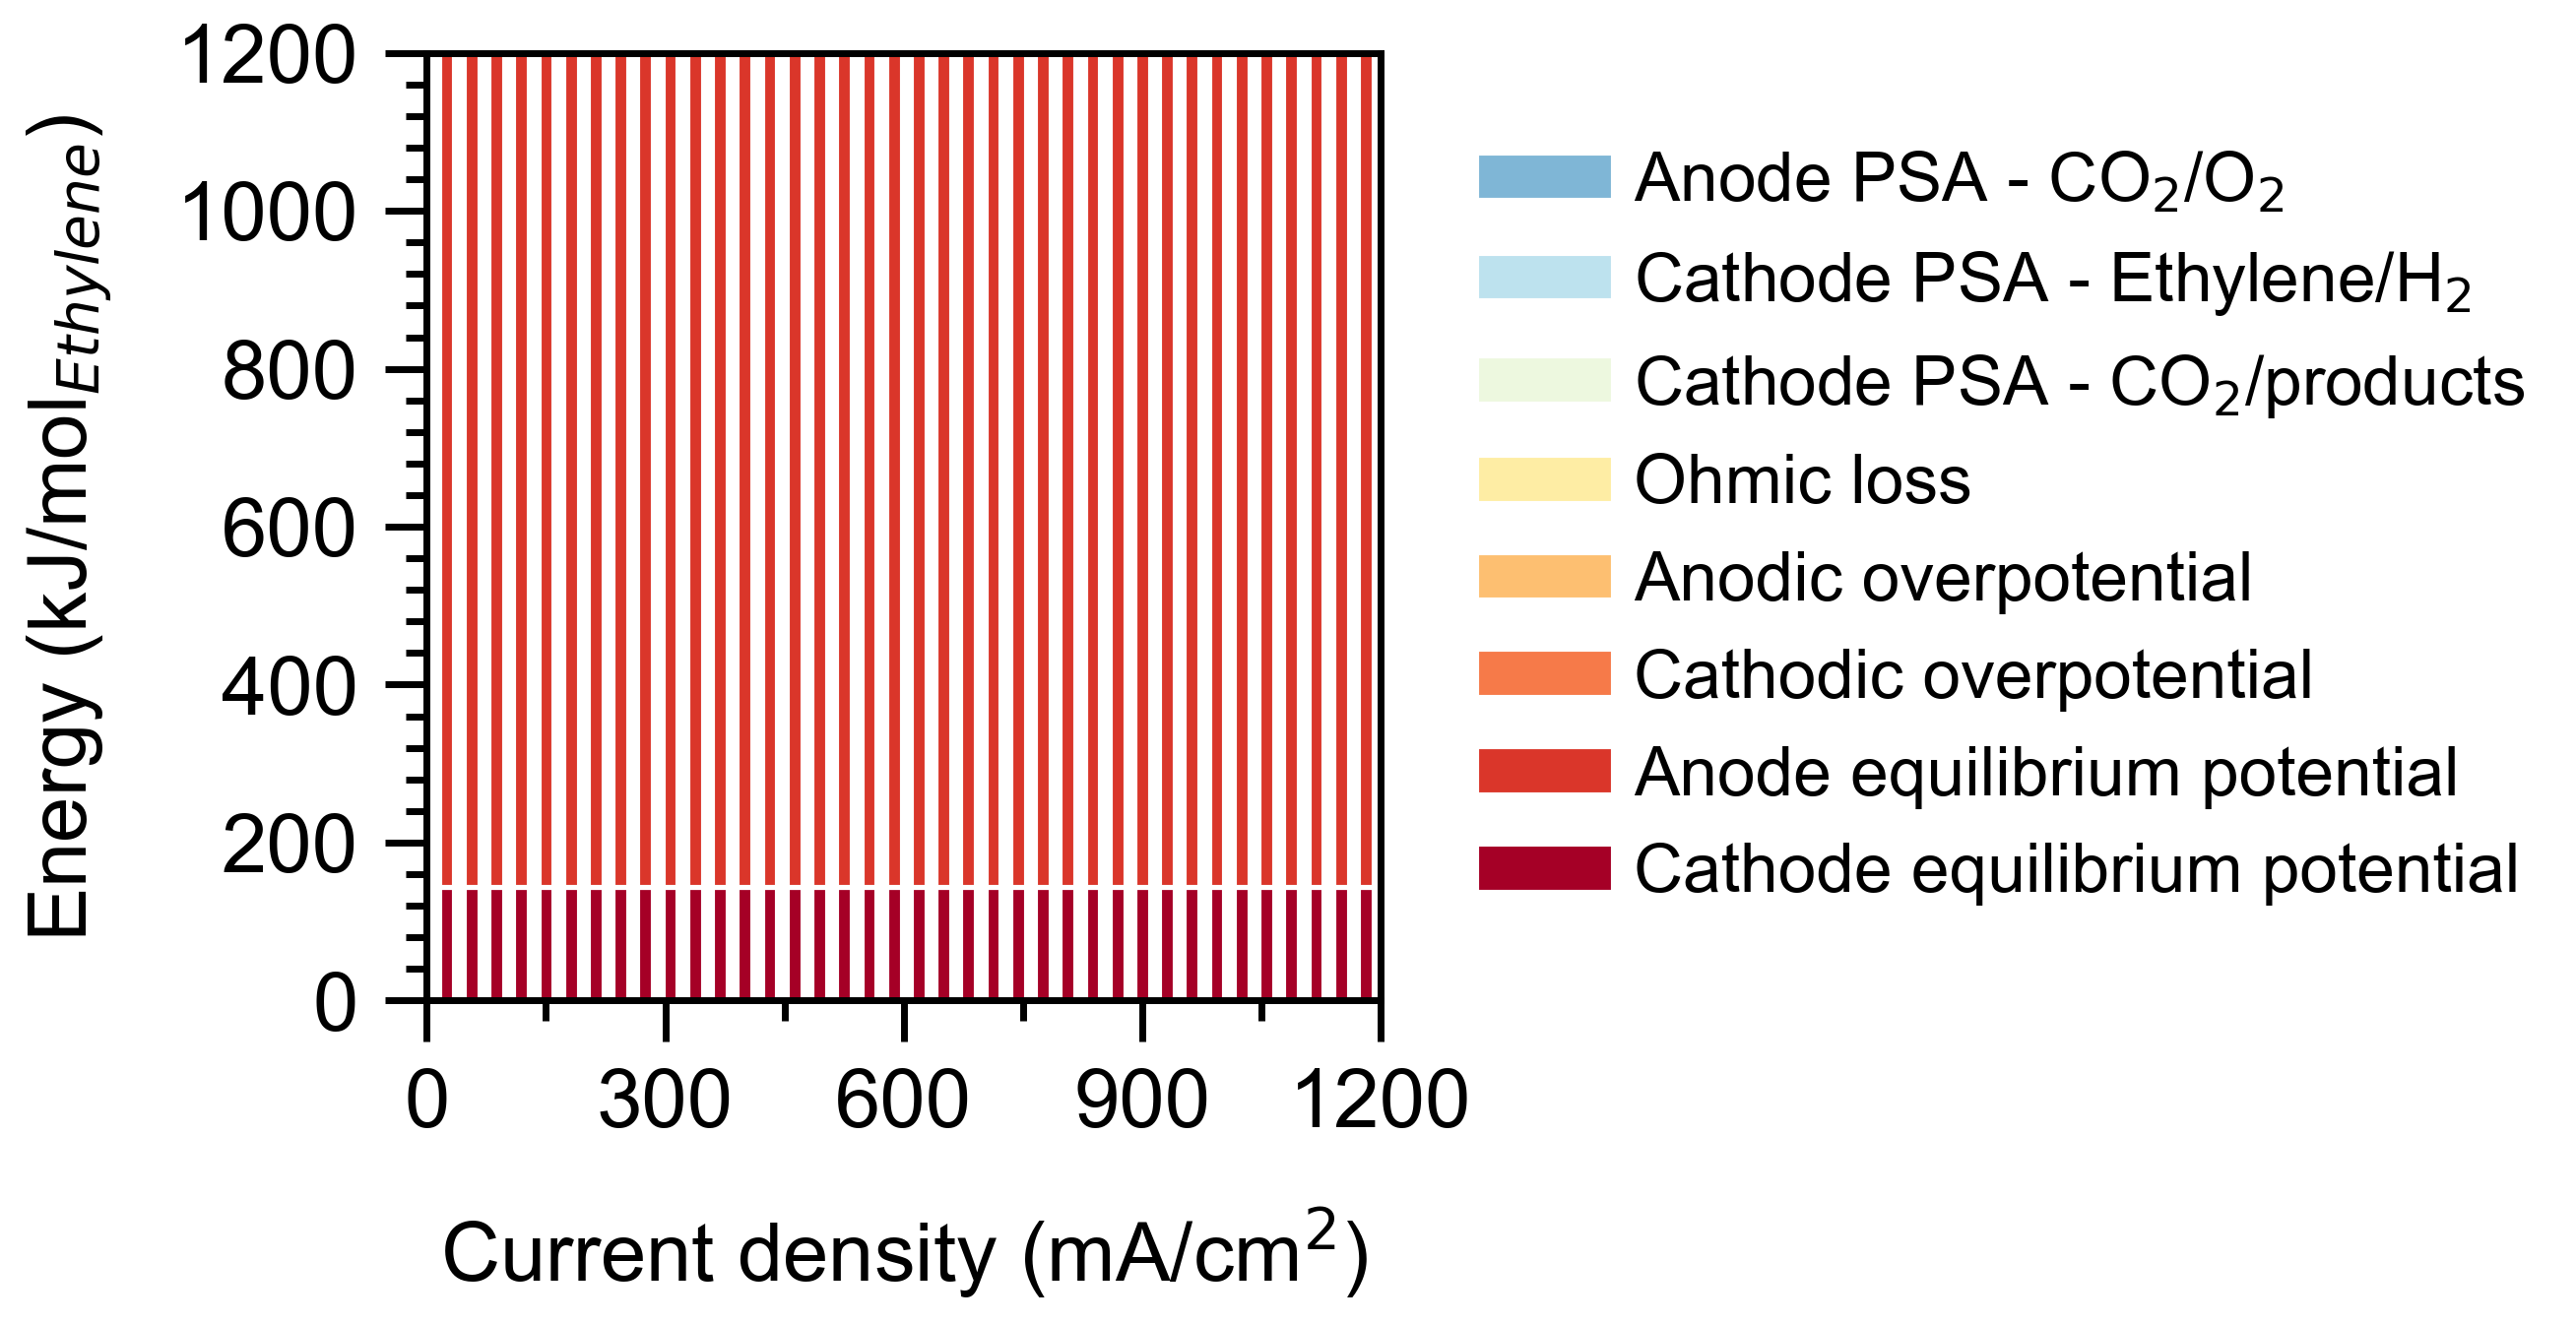

In [87]:
if override_one == True:
    
    ## TODO: figure out why this gives 0 when the SPC = np.NaN, FE = np.NaN
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    y_axis_max = 1200 # np.ceil(max(abs(df_energy_vs_vbl.loc['Total'])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)']/100) * 100 # round to nearest 1e3
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 7
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    ## Axis labels
    axs.set_ylabel('Energy (kJ/mol$_{{{}}}$)'.format(product_name))
    axs.set_xlabel(x_axis_label)

    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
    plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series
    cumsum = 0
    counter = 0
    for i, category in enumerate(df_energy_vs_vbl.iloc[:-3].index):
        if not df_energy_vs_vbl.loc[category].isnull().all():
            axs.bar(vbl_range, 
                    (abs(df_energy_vs_vbl.fillna(0).loc[category])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'], # energy kJ/kg * 0.001 g/kg * MW g/mol
                    label=category , 
                    bottom = cumsum, width = barwidth, color = energy_colors[counter],
                    edgecolor = 'w', linewidth = linewidth_calc)
            cumsum += (abs(df_energy_vs_vbl.fillna(0).loc[category])/1000)*df_products.loc[product_name, 'Molecular weight (g/mol)'] # energy kJ/kg * 0.001 g/kg * MW g/mol
            counter += 1
            
    ## Legend
    axs.legend(bbox_to_anchor=(1, 1), loc='upper left', reverse = True) 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    energy_fig_name = os.path.join(OP_folder,'{} Energy vs {}, mol {}'.format(current_date, vbl_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(energy_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(energy_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + energy_fig_name)
    
    plt.show()

## 4.9 Save results to Excel
Both compiled ('Results') and at each point in the range ('Economics' and 'Streams')

In [88]:
# # CHANGE the output file and sheet name below. {} will be replaced with variables in the format.
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format as string
current_time = time_now.strftime("%I-%M%p") # format as string

params_sheet_name = 'Parameters'
if override_one == True:
    excel_file_name = os.path.join(OP_folder, '{} {} {} at {}'.format(current_date, product_name, vbl_name, current_time) )

    # Sheet name skeletons
    results_sheet_name = 'Results vs {}'.format(vbl_name)[:30]  # Name results sheet
    streams_sheet_name_skeleton = 'Streams {}'.format(vbl_unit).replace('.', ',').replace('/','_').replace('\\', '').replace('$', '')  
    econ_sheet_name_skeleton = 'Economics {}'.format(vbl_unit).replace('.', ',').replace('/','_').replace('\\', '').replace('$', '')    
    
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'


In [89]:
# # # Find location of minimum levelized cost
if override_one:   
    min_cost = df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] >0].min()
    display(df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost']==min_cost])
    display(df_opex_totals_vs_vbl.loc['Levelized cost'])

431.25 mA/cm$^2$    7.644693
Name: Levelized cost, dtype: float64

25.0 mA/cm$^2$       20.499376
56.25 mA/cm$^2$      12.398588
87.5 mA/cm$^2$       10.171876
118.75 mA/cm$^2$      9.165703
150.0 mA/cm$^2$       8.611584
181.25 mA/cm$^2$      8.273031
212.5 mA/cm$^2$       8.053466
243.75 mA/cm$^2$      7.906222
275.0 mA/cm$^2$       7.806050
306.25 mA/cm$^2$      7.738130
337.5 mA/cm$^2$       7.693207
368.75 mA/cm$^2$      7.665213
400.0 mA/cm$^2$       7.650013
431.25 mA/cm$^2$      7.644693
462.5 mA/cm$^2$       7.647144
493.75 mA/cm$^2$      7.655807
525.0 mA/cm$^2$       7.669502
556.25 mA/cm$^2$      7.687323
587.5 mA/cm$^2$       7.708562
618.75 mA/cm$^2$      7.732661
650.0 mA/cm$^2$       7.759171
681.25 mA/cm$^2$      7.787730
712.5 mA/cm$^2$       7.818041
743.75 mA/cm$^2$      7.849862
775.0 mA/cm$^2$       7.882988
806.25 mA/cm$^2$      7.917250
837.5 mA/cm$^2$       7.952504
868.75 mA/cm$^2$      7.988630
900.0 mA/cm$^2$       8.025524
931.25 mA/cm$^2$      8.063097
962.5 mA/cm$^2$       8.101272
993.75 mA/cm$^2$      8.139984
1025.0 m

In [90]:
### Save modeled results to Excel

if override_one == True:
    print('Writing new file {} \n'.format(excel_file_name)) # Print
    
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w', 
                    datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        # Open a writer object in mode write ('w'); it will close itself at the end of with loop
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        
        # Iterate through vbl range and save each stream and econ table
        for i in vbl_range:
            # Name sheets
            streams_sheet_name = '{:.2f} {}'.format(i, streams_sheet_name_skeleton).replace('.', ',')[:30]
            econ_sheet_name = '{:.2f} {}'.format(i, econ_sheet_name_skeleton).replace('.', ',')[:30]      
            
            # Economics writing
            row = 0 # row counter
            for df in [dict_econ_tables[i][df_costing_assumptions.index.name], 
                       dict_econ_tables[i][df_capex_BM.index.name], 
                       dict_econ_tables[i][df_capex_totals.index.name], 
                       dict_econ_tables[i][df_opex.index.name], 
                       dict_econ_tables[i][df_opex_totals.index.name], 
                       dict_econ_tables[i][df_sales.index.name],  
                       dict_econ_tables[i][df_feedstocks.index.name], 
                       dict_econ_tables[i][df_utilities.index.name], 
                       dict_econ_tables[i][df_operations.index.name], 
                       dict_econ_tables[i][df_maintenance.index.name], 
                       dict_econ_tables[i][df_overhead.index.name], 
                       dict_econ_tables[i][df_taxes.index.name], 
                       dict_econ_tables[i][df_depreciation.index.name], 
                       dict_econ_tables[i][df_general.index.name]]:

                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                        sheet_name = econ_sheet_name, 
                                                        startrow = row, 
                                                        startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])

            # Stream and energy table writing            
            row = 0 # row counter
            for df in [dict_stream_tables[i][df_streams_formatted.index.name], 
                       dict_stream_tables[i][df_electrolyzer_assumptions.index.name], 
                       dict_stream_tables[i][df_outlet_assumptions.index.name], 
                       dict_stream_tables[i][df_energy.index.name], 
                       dict_stream_tables[i][df_potentials.index.name]]:
                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = streams_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])
            print('Done writing sheets for {:.2f} {}'.format(i, vbl_unit))

        # Write completed "summary" dataframes
  
        row = 0 # row counter
        for df in [df_energy_vs_vbl_2, df_potentials_vs_vbl_2,  df_emissions_vs_vbl_2,
                   df_electrolyzer_assumptions_vs_vbl_2, df_outlet_assumptions_vs_vbl_2, df_costing_assumptions_vs_vbl_2, 
                   df_capex_BM_vs_vbl_2, df_capex_totals_vs_vbl_2, df_opex_vs_vbl_2, df_sales_vs_vbl_2
                  ]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                   sheet_name = results_sheet_name, 
                                                   startrow = row, 
                                                   startcol = 0) # write to Excel - output sheet
            row += (2 + df.shape[0])
                
        print('Done writing results sheet \n')
        
        # Format all sheets
        # book_format(writer = writer_obj) # apply sheet formatting
        
        # print('\n')
        # print('Done formatting sheets \n')
        
        ## Write figure to Excel
        book  = writer_obj.book # Get workbook
        try:
            sheet = writer_obj.sheets[results_sheet_name] # Get worksheet   
        except KeyError: 
            sheet = book.create_sheet(results_sheet_name) # Create worksheet
            
        counter = 1
        for fig_name in [opex_fig_name, capex_fig_name, opex_capex_fig_name, opex2_fig_name, 
                         E_fig_name, emissions_fig_name, energy_fig_name]:
                img = openpyxl.drawing.image.Image(fig_name + '.jpg') # Image cannot be a .svg
                img.width = 300*aspect_ratio #px
                img.height = 300
                sheet.add_image(img, 'G' + str(counter)) # Add to the sheet
                
                counter += 20
                
        print('Saved figures \n')
            
    print('Written to file ', excel_file_name) # Print 

Writing new file D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Ethylene Current density at 06-10PM.xlsx 

Done writing sheets for 25.00 mA/cm$^2$
Done writing sheets for 56.25 mA/cm$^2$
Done writing sheets for 87.50 mA/cm$^2$
Done writing sheets for 118.75 mA/cm$^2$
Done writing sheets for 150.00 mA/cm$^2$
Done writing sheets for 181.25 mA/cm$^2$
Done writing sheets for 212.50 mA/cm$^2$
Done writing sheets for 243.75 mA/cm$^2$
Done writing sheets for 275.00 mA/cm$^2$
Done writing sheets for 306.25 mA/cm$^2$
Done writing sheets for 337.50 mA/cm$^2$
Done writing sheets for 368.75 mA/cm$^2$
Done writing sheets for 400.00 mA/cm$^2$
Done writing sheets for 431.25 mA/cm$^2$
Done writing sheets for 462.50 mA/cm$^2$
Done writing sheets for 493.75 mA/cm$^2$
Done writing sheets for 525.00 mA/cm$^2$
Done writing sheets for 556.25 mA/cm$^2$
Done writing sheets for 587.50 mA/cm$^2$
Done writing sheets for 618.75 mA/cm$^2$
Done

----

# 5. Single-variable sensitivity analysis

## 5.1 Range in variables

### 5.1.1 Choose variables

In [99]:
# Choose variables to vary independently
answer = input('Do you want to vary multiple assumptions independently (univariate sensitivity)? (y/n) \n ')

if answer.lower() == 'y':
    override_onebyone = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_onebyone = False

In [101]:
if override_onebyone == True:
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    answer = input('Enter comma-separated row numbers from the below table: \n')

    vbl_rows = answer.split(',')

    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override

    try:
        vbl_rows = [int(vbl_row) for vbl_row in vbl_rows] # convert input into integer
        vbl_names = df_flags.index[vbl_rows] # set vbl_name from those rows
        vbl_units = df_flags['Unit'].loc[vbl_names] # set vbl_unit from that row
        df_flags.iloc[vbl_rows, df_flags.keys()=='T/F?'] = True # set those flags to be True

    except ValueError:
        print('Valid values were not entered')

# Electrolyzer and process variables
# 0,1,2,3,4,5,6,7,8,9,10,11,12

# Market variables
# 13,14,15,16,17

# Relevant
# 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17

# All
# 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

,Independent variable,Old flag name,Unit,Python variable,Default value,Range min,Range max,T/F?
0,Cell voltage,override_cell_voltage,V,cell_E_V,NaN,1.34,5,False
1,Cathodic overpotential,override_eta_cat,V,BV_eta_cat_V,NaN,0,-2.5,False
2,Anodic overpotential,override_eta_an,V,BV_eta_an_V,NaN,0,2.5,False
3,Specific resistance,override_ohmic,$\Omega$.cm$^2$,R_ohmcm2,1.0,0,25,False
4,Current density,override_j,mA/cm$^2$,j_total_mA_cm2,435.9,25,1275,True
5,"FE$_{CO_2R,0}$",override_FE_CO2R_0,,FE_CO2R_0,0.7,0.001,1,False
6,Single-pass conversion,override_SPC,,SPC,0.02655,0.0001,0.5,False
7,Crossover,override_crossover,mol CO$_2$ per mol e$^-$,crossover_ratio,0.5,0.0001,0.5,False
8,Ethylene production rate,override_rate,kg/day,product_rate_kg_day,50000.0,0.001,1250000.0,False
9,Capacity factor,override_capacity,,capacity_factor,0.958904,0.0001,1,False


In [102]:
### Get user to input variables to calculate process costs over

print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')

dict_sensitivity = {}

if override_onebyone == True:
    answer = input('Change from default values? y/n \n \n')
    default_vbl_num = 51 # In the paper, this is 51 and 11 for optimization

    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = default_vbl_num, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_sensitivity[vbl_name] = {'Range': vbl_range}

NOTE: cathodic overpotentials are NEGATIVE if they are higher!
['0.0 V', '-0.05 V', '-0.1 V', '-0.15000000000000002 V', '-0.2 V', '-0.25 V', '-0.30000000000000004 V', '-0.35000000000000003 V', '-0.4 V', '-0.45 V', '-0.5 V', '-0.55 V', '-0.6000000000000001 V', '-0.65 V', '-0.7000000000000001 V', '-0.75 V', '-0.8 V', '-0.8500000000000001 V', '-0.9 V', '-0.9500000000000001 V', '-1.0 V', '-1.05 V', '-1.1 V', '-1.1500000000000001 V', '-1.2000000000000002 V', '-1.25 V', '-1.3 V', '-1.35 V', '-1.4000000000000001 V', '-1.4500000000000002 V', '-1.5 V', '-1.55 V', '-1.6 V', '-1.6500000000000001 V', '-1.7000000000000002 V', '-1.75 V', '-1.8 V', '-1.85 V', '-1.9000000000000001 V', '-1.9500000000000002 V', '-2.0 V', '-2.0500000000000003 V', '-2.1 V', '-2.15 V', '-2.2 V', '-2.25 V', '-2.3000000000000003 V', '-2.35 V', '-2.4000000000000004 V', '-2.45 V', '-2.5 V'] 

['0.0 V', '0.05 V', '0.1 V', '0.15000000000000002 V', '0.2 V', '0.25 V', '0.30000000000000004 V', '0.35000000000000003 V', '0.4 V', '0.4

C:\Users\shash\AppData\Local\Temp\ipykernel_13184\1566189836.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]


## 5.2 Generate and save sensitivity results

### 5.2.1 Process model over variable range

In [103]:
## Make decisions about FE-SPC tradeoff

if override_onebyone:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')
        # SPC = 0.418 # Uncomment for Fig 4i
        
        # SPC = 0.187 # Uncomment for Fig S_d-f, S_g-i
        
        # # SPC = 0.369 # Uncomment for Fig 4f
        # # j_total_mA_cm2 = 111 # Uncomment for Fig 4f, S_d-f
        # j_total_mA_cm2 = 100 # Uncomment for Fig 4f, S_d-f
        # R_ohmcm2 = 16.67 # Uncomment for Fig 4f, S_d-f
        
        SPC_original = SPC # Uncomment for Fig 4f, 4i, S_d-f, S_g-i

Using Hawks and Baker model for FE-SPC tradeoff


In [104]:
## Make decisions about battery

if override_onebyone:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
        
    else:
        is_battery = False
        battery_capacity = 0

In [105]:
if override_onebyone:
    answer = input('Do you want to run an internal optimization for each datapoint in the sensitivity analysis (multivariate sensitivity)? (y/n) \n ')

    if answer.lower() == 'y':
        override_optimization = True # are you varying any basis? set to true by default, below will falsify if needed
        j0 = [j_total_mA_cm2] # Initial guess on current density
        SPC0 = [SPC] # Initial guess on single-pass conversion
        multi0 = [j_total_mA_cm2,
                SPC]
        j_bounds = [
            (1, 2000), # SPC,
            ]
        SPC_bounds = [ 
            (1e-5, 0.5), # SPC,
            ]
        multi_bounds = [
            (1, 2000), # j_total_mA_cm2, 
            (5e-3, 0.5), # SPC,
            ]
    else:
        override_optimization = False

In [108]:
### Generate modeling results for variable range 

if override_onebyone == True:
    
    #### Iterate through variables being changed
    for i, vbl_name in enumerate(vbl_names):
        
        df_flags.iloc[vbl_rows[i], df_flags.keys()=='T/F?'] = True # set those flags to be True
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]

        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_opex_totals_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
            value_original = globals()[df_flags.loc[vbl_name,'Python variable']] # Save the original value of the adjusted variable

        #### Loop through variable
        for vbl in dict_sensitivity[vbl_name]['Range']:
            ### Update variable in its place
            globals()[df_flags.loc[vbl_name,'Python variable']] = vbl # Overwrite the global variable whose override flag is True

            ## Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0
        
            if override_optimization:
                # TODO: give these as arguments rather than redefining the function itself
                # TODO: make these a single bivariate optimization rather than consecutive univariate optimizations
                def levelized_vs_j(X):
                        __, __, __, __, __, __,\
                        __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
                        __, __, __, __, __, __, __, __, \
                        __, __, __, __  = single_run(product_name = product_name, 
                                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                                        df_products = df_products, 
                                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                                        FE_product_specified = FE_product_specified, 
                                                                                        j_total_mA_cm2 = X[0], # MODIFIED
                                                                                        SPC = SPC, 
                                                                                        crossover_ratio = crossover_ratio, 
                                                                                        model_FE = model_FE,
                                                                                        overridden_vbl = vbl_name, 
                                                                                        overridden_value = vbl, overridden_unit = vbl_units[i], 
                                                                                        override_optimization = override_optimization, 
                                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                                        an_E_eqm = an_E_eqm,
                                                                                        an_eta_ref = an_eta_ref,
                                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                                        an_j_ref = an_j_ref,
                                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                        excess_water_ratio = excess_water_ratio, 
                                                                                        electrolyte_conc = electrolyte_conc, 
                                                                                        density_kgm3 = density_kgm3,
                                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                        T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                        lifetime_years = lifetime_years,
                                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                        capacity_factor = capacity_factor,
                                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                        battery_capacity = battery_capacity,
                                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                                        exponent=exponent, 
                                                                                        scaling=scaling,
                                                                                        R = R,
                                                                                        F = F)    

                        if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                        else:
                                return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down
                j_optim_result = optimize.minimize(fun = levelized_vs_j, # opex_vs_j # capex_vs_j # levelized_vs_j
                                        x0 = j0,
                                        bounds = j_bounds) 
                j_total_mA_cm2_optim = j_optim_result.x[0]       
                        
                def levelized_vs_SPC(X):
                        __, __, __, __, __, __,\
                        __, __, __, __, __, __, df_opex_totals, df_outlet_assumptions,\
                        __, __, __, __, __, __, __, __, \
                        __, __, __, __  = single_run(product_name = product_name, 
                                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                                        df_products = df_products, 
                                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                                        FE_product_specified = FE_product_specified, 
                                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim, 
                                                                                        SPC = X[0], # MODIFIED
                                                                                        crossover_ratio = crossover_ratio, 
                                                                                        model_FE = model_FE,
                                                                                        overridden_vbl = vbl_name, 
                                                                                        overridden_value = vbl, overridden_unit = vbl_units[i], 
                                                                                        override_optimization = override_optimization, 
                                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                                        an_E_eqm = an_E_eqm,
                                                                                        an_eta_ref = an_eta_ref,
                                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                                        an_j_ref = an_j_ref,
                                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                        excess_water_ratio = excess_water_ratio, 
                                                                                        electrolyte_conc = electrolyte_conc, 
                                                                                        density_kgm3 = density_kgm3,
                                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                        T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                        lifetime_years = lifetime_years,
                                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                        capacity_factor = capacity_factor,
                                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                        battery_capacity = battery_capacity,
                                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                                        exponent=exponent, 
                                                                                        scaling=scaling,
                                                                                        R = R,
                                                                                        F = F)
                        if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                        else:
                                return X[0]*1e12 # large number, but linearly dependent on X - this will bring it down     
                
                SPC_optim_result = optimize.minimize(fun = levelized_vs_SPC,  # opex_vs_SPC # capex_vs_SPC # levelized_vs_SPC
                                        x0 = SPC0,
                                        bounds = SPC_bounds)
                SPC_optim = SPC_optim_result.x[0]

                ### Generate physical and costing model
                df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim,
                                                                        SPC = SPC_optim, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, 
                                                                        overridden_vbl = vbl_name, 
                                                                        overridden_value = vbl, overridden_unit = vbl_units.iloc[i], 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        electrolyte_conc = electrolyte_conc, 
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)

            else:    
                ### Generate physical and costing model
                df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                        df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                        df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                        cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                                df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                                FE_product_specified = FE_product_specified, 
                                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                                SPC = SPC, 
                                                                                crossover_ratio = crossover_ratio, 
                                                                                model_FE = model_FE, overridden_vbl = vbl_name, 
                                                                                overridden_value = vbl, overridden_unit = vbl_units.iloc[i], 
                                                                                override_optimization =  override_optimization, 
                                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                                an_E_eqm = an_E_eqm,
                                                                                an_eta_ref = an_eta_ref,
                                                                                an_Tafel_slope = an_Tafel_slope,
                                                                                an_j_ref = an_j_ref,
                                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, MW_O2 = MW_O2,  
                                                                                MW_MX = MW_K2CO3,
                                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                excess_water_ratio = excess_water_ratio, 
                                                                                electrolyte_conc = electrolyte_conc,  
                                                                                density_kgm3 = density_kgm3,
                                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                T_sep = T_sep, 
                                                                                electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                lifetime_years = lifetime_years,
                                                                                stack_lifetime_years = stack_lifetime_years,
                                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                capacity_factor = capacity_factor,
                                                                                battery_capex_USD_kWh = battery_capex_USD_kWh, 
                                                                                battery_capacity = battery_capacity,
                                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                                exponent=exponent, 
                                                                                scaling=scaling,
                                                                                R = R,
                                                                                F = F)
            
            ### Store results of models                             
            dict_sensitivity[vbl_name][vbl] = { 'Streams' : {
                df_streams_formatted.index.name: df_streams_formatted, 
                df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
                df_outlet_assumptions.index.name: df_outlet_assumptions, 
                df_energy.index.name: df_energy,
                df_potentials.index.name: df_potentials
                }
                }

            dict_sensitivity[vbl_name][vbl]['Economics']= {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }

            df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
            df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                        df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
            df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
            df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                            df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
            df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                      df_outlet_assumptions['Value']], axis = 1) # Store assumptions
            df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                        df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                        df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                        df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
            df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                            df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
            df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                        df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
            df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

            ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
            if vbl_name != 'Cell voltage' and vbl_name != 'Cathodic overpotential' and vbl_name != 'Anodic overpotential':
                globals()[df_flags.loc[vbl_name,'Python variable']] = value_original
            FE_product = FE_product_specified
            SPC = SPC_original

            print('Done testing {} = {:.1f}; levelized cost = ${}/ kg {} \n'.format(vbl_name, vbl, df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)], product_name))

            ### End inner loop (vbl values)

        df_flags['T/F?'] = False # set those flags to be True

        ### Format completed "summary" dataframes
        for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                       df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                       df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_opex_totals_vs_vbl, df_sales_vs_vbl
                      ]:
            df.columns = vbl_range_text # rename columns   
  
        ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
        ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
        df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
#         df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
#         df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

        df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
#         df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
#         df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

        df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
#         df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
#         df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

        df_potentials_vs_vbl.index = df_potentials.index
#         df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
#         df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])

        df_opex_vs_vbl.index = df_opex.index
#         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        df_sales_vs_vbl.index = df_sales.index
#         df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
#         df_sales_vs_vbl_2.insert(0, 'Units', '\$/yr'.format(product_name))

        df_opex_totals_vs_vbl.index = df_opex_totals_vs_vbl.index
#         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
#         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        try:
                df_capex_BM_vs_vbl.index = df_capex_BM.index 
        except:
                df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
#         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
#         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_capex_totals_vs_vbl.index = df_capex_totals.index
#         df_capex_totals_vs_vbl_2 = df_capex_totals_vs_vbl.copy()
#         df_capex_totals_vs_vbl_2.insert(0, 'Units', '\$')

        df_energy_vs_vbl.index = df_energy.index    
#         df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
#         df_energy_vs_vbl_2.index.name  = 'Energy'
#         df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))

        df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
#         df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
#         df_emissions_vs_vbl_2.index.name  = 'Emissions'
#         df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))
        
        # Levelized cost includes all capex except working capital, which is recovered during operation
        dict_sensitivity[vbl_name]['Potentials vs vbl'] = df_potentials_vs_vbl
        dict_sensitivity[vbl_name]['Energy vs vbl'] = df_energy_vs_vbl
        dict_sensitivity[vbl_name]['Emissions vs vbl'] = df_emissions_vs_vbl
        dict_sensitivity[vbl_name]['Electrolyzer assumptions vs vbl'] = df_electrolyzer_assumptions_vs_vbl
        dict_sensitivity[vbl_name]['Opex vs vbl'] = df_opex_vs_vbl
        dict_sensitivity[vbl_name]['Opex totals vs vbl'] = df_opex_totals_vs_vbl
        dict_sensitivity[vbl_name]['Bare-module investment vs vbl'] = df_capex_BM_vs_vbl        
        dict_sensitivity[vbl_name]['Capex vs vbl'] = df_capex_totals_vs_vbl
        dict_sensitivity[vbl_name]['Costing assumptions vs vbl'] = df_costing_assumptions_vs_vbl

        ### End outer loop (vbls of choice)

C:\Users\shash\AppData\Local\Temp\ipykernel_13184\2012096366.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]


SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8236597668602394e+34 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = 0.0; levelized cost = $5.820004807706801/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5639920660487613e+34 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.1; levelized cost = $5.8876037676945145/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.601800201948117e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.1; levelized cost = $5.955202727682226/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.876160563980041e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.2; levelized cost = $6.02280168766994/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.288556928520344e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.2; levelized cost = $6.090400647657652/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.936275395080434e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.2; levelized cost = $6.157999607645365/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.805734702249528e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.3; levelized cost = $6.225598567633077/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3587710351942681e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.4; levelized cost = $6.293197527620791/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.732999400265293e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.4; levelized cost = $6.360796487608504/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.4108533057737517e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.5; levelized cost = $6.428395447596216/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7641016256945276e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.5; levelized cost = $6.49599440758393/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.30673193269492e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.6; levelized cost = $6.563593367571642/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.0032776848960874e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.6; levelized cost = $6.631192327559355/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.738584172501346e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.7; levelized cost = $6.698791287547067/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5249261848598701e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.7; levelized cost = $6.766390247534779/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.631501478109339e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.8; levelized cost = $6.833989207522492/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.9624082247014236e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.8; levelized cost = $6.901588167510206/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.896195473815686e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.9; levelized cost = $6.969187127497919/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.714597204418909e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -0.9; levelized cost = $7.036786087485632/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0291310998328157e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.0; levelized cost = $7.104385047473344/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.2591052296986425e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.0; levelized cost = $7.171984007461058/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8548532435622174e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.1; levelized cost = $7.239582967448771/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4032047568632306e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.1; levelized cost = $7.307181927436483/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5157124738889532e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.2; levelized cost = $7.374780887424195/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.667303510721199e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.2; levelized cost = $7.4423798474119085/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.232644928463551e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.2; levelized cost = $7.509978807399622/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.0600534871141267e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.3; levelized cost = $7.577577767387334/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6713234135113083e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.4; levelized cost = $7.6451767273750475/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7745715868863474e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.4; levelized cost = $7.712775687362759/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1898317559269392e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.5; levelized cost = $7.780374647350473/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.049236675836362e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.5; levelized cost = $7.8479736073381865/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.4924793658873295e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.6; levelized cost = $7.915572567325898/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.779177641680519e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.6; levelized cost = $7.983171527313612/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6213237926165582e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.7; levelized cost = $8.050770487301326/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8323734925271285e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.7; levelized cost = $8.118369447289036/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2905359401324697e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.8; levelized cost = $8.185968407276752/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.155514988613367e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.8; levelized cost = $8.253567367264464/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.541066223708868e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.9; levelized cost = $8.321166327252175/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.705086283376278e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -1.9; levelized cost = $8.388765287239888/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.406827881677174e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.0; levelized cost = $8.456364247227603/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.482586456153147e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.0; levelized cost = $8.523963207215314/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.197982616679531e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.1; levelized cost = $8.591562167203028/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.047190893089444e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.1; levelized cost = $8.659161127190739/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.486707527792735e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.1; levelized cost = $8.726760087178453/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.3477551835684456e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.2; levelized cost = $8.794359047166166/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.511649377029531e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.2; levelized cost = $8.861958007153877/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.8944133557232995e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.3; levelized cost = $8.929556967141592/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.18132136794354e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.4; levelized cost = $8.997155927129306/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.471971565203995e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.4; levelized cost = $9.064754887117019/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.189881993173525e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Cathodic overpotential = -2.5; levelized cost = $9.13235384710473/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.148960873180496e+39 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_13184\2012096366.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]


Done testing Cathodic overpotential = -2.5; levelized cost = $9.199952807092444/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.436837444813133e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.0; levelized cost = $7.2197962300766045/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.756297334191816e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.1; levelized cost = $7.287395190064316/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.732603929922006e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.1; levelized cost = $7.354994150052032/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1014926079710103e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.2; levelized cost = $7.4225931100397435/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.079415807484278e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.2; levelized cost = $7.490192070027455/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.597914156984441e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.2; levelized cost = $7.557791030015169/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.0165067165457936e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.3; levelized cost = $7.625389990002881/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.998323440013591e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.4; levelized cost = $7.692988949990593/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3362649901645805e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.4; levelized cost = $7.760587909978306/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.016549781210089e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.5; levelized cost = $7.82818686996602/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.137271658131104e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.5; levelized cost = $7.895785829953732/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2126861798546995e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.6; levelized cost = $7.963384789941445/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9152143184689495e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.6; levelized cost = $8.030983749929158/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.033240898768435e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.7; levelized cost = $8.09858270991687/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4289020004819902e+26 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.7; levelized cost = $8.166181669904585/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.01158272443175e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.8; levelized cost = $8.233780629892296/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.212463015571509e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.8; levelized cost = $8.30137958988001/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.177838947569575e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.9; levelized cost = $8.368978549867723/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.7419854613909427e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 0.9; levelized cost = $8.436577509855434/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.7217888491359745e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.0; levelized cost = $8.504176469843147/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.992131990547192e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.0; levelized cost = $8.571775429830861/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.606494300715206e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.1; levelized cost = $8.639374389818572/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.893426184588444e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.1; levelized cost = $8.706973349806287/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.6452650402556606e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.2; levelized cost = $8.774572309794/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.730517889332646e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.2; levelized cost = $8.842171269781712/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.056324225903732e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.2; levelized cost = $8.909770229769425/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.783433311327917e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.3; levelized cost = $8.977369189757137/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.922144699438383e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.4; levelized cost = $9.04496814974485/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.528174194143054e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.4; levelized cost = $9.112567109732563/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.3192779999715087e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.5; levelized cost = $9.180166069720277/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7901639209729583e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.5; levelized cost = $9.247765029707988/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1897347165369333e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.6; levelized cost = $9.315363989695703/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.265416246728942e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.6; levelized cost = $9.382962949683415/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.636311902647069e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.7; levelized cost = $9.450561909671128/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.621843399177521e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.7; levelized cost = $9.518160869658841/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4167209941033204e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.8; levelized cost = $9.585759829646554/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.6582228946765082e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.8; levelized cost = $9.653358789634266/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.235524427596316e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.9; levelized cost = $9.72095774962198/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.885123310347753e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 1.9; levelized cost = $9.788556709609692/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.739469259120419e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.0; levelized cost = $9.856155669597406/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.0584439280585065e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.0; levelized cost = $9.923754629585117/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.8210936556506826e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.1; levelized cost = $9.991353589572832/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9468212283562428e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.1; levelized cost = $10.058952549560544/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3777412436353803e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.1; levelized cost = $10.126551509548255/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.94511789043907e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.2; levelized cost = $10.19415046953597/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.149776521127125e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.2; levelized cost = $10.26174942952368/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.231323073418224e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.3; levelized cost = $10.329348389511397/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.8220975394358265e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.4; levelized cost = $10.396947349499108/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.756944490194562e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.4; levelized cost = $10.464546309486822/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0012935538678378e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Anodic overpotential = 2.5; levelized cost = $10.532145269474533/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.478830547494596e+36 reached.
  warnings.warn(msg, RuntimeWarning)
C:\Users\shash\AppData\Local\Temp\ipykernel_13184\2012096366.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in dict_sensitivity[vbl_name]['Range'] ]


Done testing Anodic overpotential = 2.5; levelized cost = $10.599744229462246/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.489179017380476e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 0.0; levelized cost = $7.0552804540807745/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.7930169710023106e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 0.5; levelized cost = $7.349944320667214/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.68064485243033e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 1.0; levelized cost = $7.644608187253654/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.813246215032297e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 1.5; levelized cost = $7.939272053840094/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.0107916818382854e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 2.0; levelized cost = $8.233935920426534/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.4298368644480236e+25 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 2.5; levelized cost = $8.528599787012975/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.958731721920982e+40 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 3.0; levelized cost = $8.823263653599415/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.4337380373236555e+39 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 3.5; levelized cost = $9.117927520185855/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.467211732023223e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 4.0; levelized cost = $9.412591386772295/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.294018384666709e+38 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 4.5; levelized cost = $9.707255253358737/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.637648967046215e+37 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 5.0; levelized cost = $10.001919119945176/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.085097177968602e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 5.5; levelized cost = $10.296582986531616/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.5305001999782256e+36 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 6.0; levelized cost = $10.591246853118058/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.2248605409197725e+35 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 6.5; levelized cost = $10.885910719704498/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2545705991787838e+35 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 7.0; levelized cost = $11.18057458629094/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.99487389602564e+34 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 7.5; levelized cost = $11.475238452877377/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3641757841936793e+34 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 8.0; levelized cost = $11.769902319463817/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.91918755876273e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 8.5; levelized cost = $12.064566186050259/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.873438986529088e+33 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 9.0; levelized cost = $12.359230052636702/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.502551119147934e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 9.5; levelized cost = $12.653893919223137/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.1468417922376847e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 10.0; levelized cost = $12.948557785809577/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.3770033054423886e+32 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 10.5; levelized cost = $13.243221652396016/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.267034166496602e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 11.0; levelized cost = $13.53788551898246/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.9590417983929602e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 11.5; levelized cost = $13.8325493855689/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4453061678953301e+31 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 12.0; levelized cost = $14.12721325215534/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.285937908658779e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 12.5; levelized cost = $14.42187711874178/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.784378764301487e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 13.0; levelized cost = $14.716540985328217/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0205492612182423e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 13.5; levelized cost = $15.011204851914659/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.1072141830812225e+30 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 14.0; levelized cost = $15.305868718501099/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.217127053566184e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 14.5; levelized cost = $15.60053258508754/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.5716904448445855e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 15.0; levelized cost = $15.895196451673984/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.0964864192122913e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 15.5; levelized cost = $16.189860318260425/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.255838314694007e+29 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 16.0; levelized cost = $16.48452418484686/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 7.667971852934099e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 16.5; levelized cost = $16.7791880514333/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.767270572960104e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 17.0; levelized cost = $17.07385191801974/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.014875325695704e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 17.5; levelized cost = $17.36851578460618/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.9376872209498435e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 18.0; levelized cost = $17.66317965119263/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.264589148626201e+28 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 18.5; levelized cost = $17.957843517779068/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 8.373693338323747e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 19.0; levelized cost = $18.252507384365508/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 5.621689390320993e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 19.5; levelized cost = $18.54717125095195/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.823844422196019e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 20.0; levelized cost = $18.841835117538384/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6335654781339076e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 20.5; levelized cost = $19.136498984124824/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.835405414331292e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 21.0; levelized cost = $19.431162850711264/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.2936607090818758e+27 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 21.5; levelized cost = $19.725826717297707/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 9.216892433061579e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 22.0; levelized cost = $20.020490583884147/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 6.634447964073963e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 22.5; levelized cost = $20.315154450470587/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 4.822627965334294e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 23.0; levelized cost = $20.609818317057027/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 3.538580436578971e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 23.5; levelized cost = $20.904482183643474/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.6197768302563616e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 24.0; levelized cost = $21.19914605022991/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.956233541181222e+26 reached.
  warnings.warn(msg, RuntimeWarning)


Done testing Specific resistance = 24.5; levelized cost = $21.493809916816346/ kg Ethylene 

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 

Done testing Specific resistance = 25.0; levelized cost = $21.788473783402786/ kg Ethylene 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 1.4727919202796459e+26 reached.
  warnings.warn(msg, RuntimeWarning)


### 5.2.2 Single run at default variable values 
This the assumed "standard" or "center point" cost

In [109]:
# Single run of electrolyzer model    

if override_onebyone:
### Generate modeling results for variable range 

    ### Generate physical and costing model
    
    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0

    if override_optimization:
        # TODO: give these as arguments rather than redefining the function itself
        def levelized_vs_multi(X):
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                df_products = df_products, 
                                                                FE_CO2R_0 = FE_CO2R_0, 
                                                                FE_product_specified = FE_product_specified, 
                                                                j_total_mA_cm2 = X[0], # MODIFIED
                                                                SPC = X[1], # MODIFIED
                                                                crossover_ratio = crossover_ratio, 
                                                                model_FE = model_FE, 
                                                                overridden_vbl = '', 
                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                override_optimization = override_optimization, 
                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                an_E_eqm = an_E_eqm,
                                                                an_eta_ref = an_eta_ref,
                                                                an_Tafel_slope = an_Tafel_slope,
                                                                an_j_ref = an_j_ref,
                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                excess_water_ratio = excess_water_ratio, 
                                                                electrolyte_conc = electrolyte_conc, 
                                                                density_kgm3 = density_kgm3,
                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                lifetime_years = lifetime_years,
                                                                stack_lifetime_years = stack_lifetime_years,
                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                capacity_factor = capacity_factor,
                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                battery_capacity = battery_capacity,
                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                exponent=exponent, 
                                                                scaling=scaling,
                                                                R = R,
                                                                F = F)
            if not np.isnan(df_outlet_assumptions.loc['Single-pass conversion', 'Value']):
                return 1e3*df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
            else:
                return X[1]*1e12 # large number, but linearly dependent on SPC - this will bring it down
            # return X[0]**2 + X[1]**3

        # Extract optimal jtotal and SPC
        multi_optim_result = optimize.minimize(fun = levelized_vs_multi,  # opex_vs_multi # capex_vs_multi # levelized_vs_multi
                                        x0 = multi0,
                                        bounds = multi_bounds)

        j_total_mA_cm2_optim = multi_optim_result.x[0]
        SPC_optim = multi_optim_result.x[1]
        
        ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2_optim,
                                                                        SPC = SPC_optim, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, 
                                                                        overridden_vbl = '', 
                                                                        overridden_value = np.NaN, overridden_unit = '', 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio,
                                                                        electrolyte_conc = electrolyte_conc, 
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)   
    else:    
    ### Generate physical and costing model
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, 
                                                                        FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,
                                                                        SPC = SPC, crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, 
                                                                        overridden_vbl = '', 
                                                                        overridden_value = np.NaN, 
                                                                        overridden_unit = '', 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                        MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio, 
                                                                        electrolyte_conc = electrolyte_conc,  
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh, 
                                                                        battery_capacity = battery_capacity,exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)
    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))

SPC_check returned SPC = 2.6550000000000002%; FE 64.61453303647214% 



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of 2.68064485243033e+27 reached.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_zeros_py.py:364: RuntimeWarning: Tolerance of -8.881784197001252e-16 reached.
  warnings.warn(msg, RuntimeWarning)


Done with single run
Written single run to file D:\OneDrive - The University of Texas at Austin\RCL Experimental\LCA TEA for CO2R\LCA TEA results on 20240701\20240701 Ethylene single run at 06-10PM.xlsx


## 5.3 Plot formatting for sensitivity tornadoes

### 5.3.1 Set axis ranges

In [110]:
opex_x_axis_min = 0
capex_x_axis_min = 0
levelized_x_axis_min = 0

opex_x_axis_max = 2 # 10 # 2 # 7 
capex_x_axis_max = 300 # 700 # 300 # 200
levelized_x_axis_max = 2 # 10 # 7 # 2 

In [111]:
# for vbl_name in vbl_names:
#     print(vbl_name)
#     display(dict_sensitivity[vbl_name]['Opex vs vbl'])
#     display(dict_sensitivity[vbl_name]['Potentials vs vbl'])

### 5.3.2 Take valid runs only

In [112]:
if override_onebyone:
    dict_sensitivity_cleaned = {}

    for vbl_name in vbl_names:
        # For each variable, take the valid runs (valid => there will be no np.NaN or np.inf values in df_potentials for that run). vbl_name cycles through 
        # variables and each column of dict_sensitivity[vbl_name]['Potentials vs vbl'] is a run (value of that variable)
        # can also just use np.nanmin to handle NaNs

        dict_sensitivity_cleaned[vbl_name] = {}
        is_row_valid = ~np.isinf(dict_sensitivity[vbl_name]['Opex vs vbl']).any() & ~np.isnan(dict_sensitivity[vbl_name]['Potentials vs vbl'].loc['Cell potential'])

        dict_sensitivity_cleaned[vbl_name]['Range'] = dict_sensitivity[vbl_name]['Range'][is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Opex vs vbl'] = dict_sensitivity[vbl_name]['Opex vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'] = dict_sensitivity[vbl_name]['Opex totals vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'] = dict_sensitivity[vbl_name]['Capex vs vbl'].loc[:, is_row_valid]
        dict_sensitivity_cleaned[vbl_name]['Colors'] = [RdBu(i) for i in np.linspace(0, 1, len(dict_sensitivity_cleaned[vbl_name]['Range']))][::-1]

### 5.3.3 Get limits for bar chart

In [113]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
    
    # For minima, pick the first value in the vbl range that's == minimum opex value and within the x-axis ranges
    opex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']) for vbl_name in vbl_names]
    visible_opex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] > opex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] < opex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     opex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']] == opex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    opex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == visible_opex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum opex value and within the x-axis ranges
    opex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost']) for vbl_name in vbl_names]
    visible_opex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] > opex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] < opex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     opex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == opex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    opex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'] == visible_opex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
    # # All capex except working capital, which is recovered during operation
    
    # For minima, pick the first value in the vbl range that's == minimum capex value and within the x-axis ranges
    capex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']) for vbl_name in vbl_names]
    visible_capex_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment', (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 > capex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 < capex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     capex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total'] == capex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    capex_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == visible_capex_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum capex value and within the x-axis ranges
    capex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']) for vbl_name in vbl_names]
    visible_capex_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment', (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 > capex_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6 < capex_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     capex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == capex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    capex_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'] == visible_capex_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


In [ ]:
if override_onebyone == True:
    # If this throws errors because of empty series, use true min/max rather than visible
     
    # For minima, pick the first value in the vbl range that's == minimum levelized value and within the x-axis ranges
    levelized_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost']) for vbl_name in vbl_names]
    visible_levelized_minima = [np.min(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] > levelized_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] < levelized_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true minimima
#     levelized_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == levelized_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    # Use visible minima
    levelized_minima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == visible_levelized_minima[i])[0][0] for i, vbl_name in enumerate(vbl_names)]
    
    # For maxima, pick the last value in the vbl range that's == maximum levelized value and within the x-axis ranges
    levelized_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost']) for vbl_name in vbl_names]
    visible_levelized_maxima = [np.max(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost', (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] > levelized_x_axis_min) & (dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] < levelized_x_axis_max)]) for vbl_name in vbl_names] 
#     # Use true maxima
#     levelized_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == levelized_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]
    # Use visible maxima
    levelized_maxima_idx = [np.where(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'] == visible_levelized_maxima[i])[0][-1] for i, vbl_name in enumerate(vbl_names)]


### 5.3.4 Bar width

In [ ]:
if override_onebyone == True:
    barwidth = (len(vbl_names) + 0.5 )/(len(vbl_names)*2)

### 5.3.5 Current time

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

## 5.4. Plot opex sensitivity 

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7, 7*aspect_ratio + 1)) # Set up plot

    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max = opex_x_axis_max
    x_axis_min = opex_x_axis_min 
    x_axis_step = 0.4 # 1 # 0.4
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Operating cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot bar charts  
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [opex_maxima[i] - opex_minima[i] for i in range(len(vbl_names))], 
             label='', left=opex_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
            color = theme_colors[5], alpha = 0.4)
    
    ## Plot lines for average cost and price
    axs.plot([product_cost_USD_kgprod, product_cost_USD_kgprod], [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(product_cost_USD_kgprod, y_axis_min - 0.5, 
             'Market price', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    axs.plot([df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)], df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)], y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
            
    ## Plot scatter and min/max labels
    for i, vbl_name in enumerate(vbl_names):
        # Scatterplot
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'], 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 50, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])
        # Labels 
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        else:
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_minima_idx[i]] - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][opex_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Production cost'][opex_maxima_idx[i]] + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][opex_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][opex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
            
    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
    
    ## Flip the horizontal bars
    axs.invert_yaxis()
    
    ## Save figure 
    opex_sens_fig_name = os.path.join(OP_folder,'{} Opex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) 
    fig.savefig(opex_sens_fig_name + '.pdf', transparent = True )
    # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_sens_fig_name )
    
    plt.show()

## 5.5. Plot capex sensitivity

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7,7*aspect_ratio + 1)) # Set up plot

    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max = capex_x_axis_max # 500 # np.ceil(max(capex_maxima)/1e6)   # round to nearest million
    x_axis_min = capex_x_axis_min # np.floor(min(capex_minima)/1e6) 
    x_axis_step = 50 # 100 # 50
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Capital cost (million \$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    axs.tick_params(bottom = True, top = False, left = False, right = False)
    
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series  
    # All capex except working capital, which is recovered during operation
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [(capex_maxima[i] - capex_minima[i])/1e6 for i in range(len(vbl_names))], 
             label='', left=[i/1e6 for i in capex_minima], height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
             alpha = 0.3,
            color = theme_colors[3])
    
    axs.plot([df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6, df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(df_capex_totals.loc['Total permanent investment', 'Cost ($)']/1e6, y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
     
    ## Plot scatter and min/max labels    
    for i, vbl_name in enumerate(vbl_names):
        # Scatterplot
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment']/1e6, 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 100, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])

        # Labels 
                # Label text, formatted to basically maintain 2-3 sig figs
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                    i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                    fontsize = SMALL_SIZE)  
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center',c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                fontsize = SMALL_SIZE) 
        else:
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_minima_idx[i]]/1e6) - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][capex_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_minima_idx[i]])
            axs.text((dict_sensitivity_cleaned[vbl_name]['Capex vs vbl'].loc['Total permanent investment'][capex_maxima_idx[i]]/1e6) + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][capex_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center',c = dict_sensitivity_cleaned[vbl_name]['Colors'][capex_maxima_idx[i]],
                fontsize = SMALL_SIZE) 
      
    ## Flip the horizontal bars
    axs.invert_yaxis()

    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    capex_sens_fig_name = os.path.join(OP_folder,'{} Capex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',','))  # CHANGE to change the figure name 
    fig.savefig(capex_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_sens_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_sens_fig_name )
    
    plt.show()

## 5.6. Plot opex+capex sensitivity

In [ ]:
if override_onebyone == True:
    # Plot emissions per kg product over voltage range - bar chart

    fig, axs = plt.subplots(figsize = (7, 7*aspect_ratio + 1)) # Set up plot
 
    y_axis_min = 0.5
    y_axis_max = len(vbl_names) + 0.5
    
    x_axis_max =  levelized_x_axis_max 
    x_axis_min = levelized_x_axis_min 
    x_axis_step = 0.4 # 1 # 0.4 
#     x_axis_num = 6
    x_axis_major_ticks =  np.arange(x_axis_min, x_axis_max, step = x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
#     x_axis_major_ticks = np.linspace(x_axis_min, x_axis_max, num = x_axis_num, endpoint = True) # 

    label_padding = abs(x_axis_max - x_axis_min)/20

    ## Axis labels
    axs.set_xlabel('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name))

    ## Hide or show plot borders 
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(True)
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Handle axis ticks
    axs.minorticks_off()
    axs.tick_params(bottom = True, top = False, left = False, right = False)
            
    ## Draw axis ticks
    axs.tick_params(axis = 'y', pad = 80) # Spacing between y-axis and origin
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, 
                                                     # then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot bars   
    axs.barh(np.arange(1, len(vbl_names) + 1), width = [levelized_maxima[i] - levelized_minima[i] for i in range(len(vbl_names))], 
             label='', left=levelized_minima, height = barwidth, tick_label = ['{} ({})'.format(vbl_names[i], vbl_units[i]) for i in range(len(vbl_names))],
            color = theme_colors[0], alpha = 0.4) 
    
    ## Plot lines for average cost and price
    axs.plot([product_cost_USD_kgprod, product_cost_USD_kgprod], [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text(product_cost_USD_kgprod, y_axis_min - 0.5, 
             'Market price', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    ## Plot scatter and min/max labels
    # Levelized cost includes all capex except working capital, which is recovered during operation
    axs.plot([  (df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) , 
               (df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) 
               ], 
             [y_axis_min - 1, y_axis_max], 
             c = theme_colors[6], alpha = 0.5)
    axs.text((df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] + \
            df_capex_totals.loc['Total permanent investment', 'Cost ($)']/(df_costing_assumptions.loc['Plant lifetime', 'Cost']* \
            365*df_costing_assumptions.loc['Capacity factor', 'Cost']) / df_electrolyzer_assumptions.loc['Production rate', 'Value']) , 
             y_axis_min - 0.5, 
             'Modeled cost', 
             ha = 'center', va = 'bottom', fontsize = SMALL_SIZE,
              rotation = 90, c = theme_colors[6])
    
    for i, vbl_name in enumerate(vbl_names):
        # Scatter points 
        axs.scatter(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'], 
                    (i+1)*np.ones(len(dict_sensitivity_cleaned[vbl_name]['Range'])),
                   s = 100, marker = 'o', c = dict_sensitivity_cleaned[vbl_name]['Colors'])

        # Label text, formatted to basically maintain 2-3 sig figs
        if vbl_name == '{} production rate'.format(product_name) or vbl_name == 'Electrolyzer capital cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]]/1000)),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f} $ \cdot 10^3$'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]]/1000)),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)  
        elif vbl_name == 'Current density' or vbl_name == 'Plant lifetime' or vbl_name == 'CO$_2$ cost':
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]])),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.0f}'.format(round(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]])),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)
        else:            
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_minima_idx[i]] - label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_minima_idx[i]]),
                    horizontalalignment = 'right', verticalalignment = 'center',
                    fontsize = SMALL_SIZE, c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_minima_idx[i]])
            axs.text(dict_sensitivity_cleaned[vbl_name]['Opex totals vs vbl'].loc['Levelized cost'][levelized_maxima_idx[i]] + label_padding, 
                     i+1, '{:.2f}'.format(dict_sensitivity_cleaned[vbl_name]['Range'][levelized_maxima_idx[i]]),
                    horizontalalignment = 'left', verticalalignment = 'center', c = dict_sensitivity_cleaned[vbl_name]['Colors'][levelized_maxima_idx[i]],
                    fontsize = SMALL_SIZE)   
    
    ## Flip the horizontal bars
    axs.invert_yaxis()

    ## Legend
#     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') 
    # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Save figure 
    levelized_sens_fig_name = os.path.join(OP_folder, '{} Opex+capex sensitivity {} {}'.format(current_date, product_name, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(levelized_sens_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_sens_fig_name + '.jpg', transparent = True, dpi = 80, ) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_sens_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + levelized_sens_fig_name )
    
    plt.show()

## 5.7 Save sensitivity results to Excel

In [ ]:
if override_onebyone == True:
    excel_file_name = os.path.join(OP_folder, '{} {} sensitivity at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'
        
    ### Save modeled results to Excel
    print('Writing new file {} \n'.format(excel_file_name)) # Print
    
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w', 
                    datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  # Open a writer object in mode write ('w'); it will close itself at the end of with loop
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        
        # Iterate through variables
        for vbl_name in vbl_names:
            # Sheet name skeletons
            results_sheet_name = 'Results vs {}'.format(vbl_name)[:30]  # Name results sheet
            streams_sheet_name = 'Streams vs {}'.format(vbl_name)[:30]
            econ_sheet_name = 'Economics vs {}'.format(vbl_name)[:30]
            
            # Iterate through vbl range and save each stream and econ table
            for i, j in enumerate(dict_sensitivity[vbl_name]['Range']):
            
                # Economics writing
                row = 0 # row counter
                for df in [dict_sensitivity[vbl_name][j]['Economics'][df_costing_assumptions.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_capex_BM.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_capex_totals.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_opex.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_opex_totals.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_sales.index.name],  
                       dict_sensitivity[vbl_name][j]['Economics'][df_feedstocks.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_utilities.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_operations.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_maintenance.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_overhead.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_taxes.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_depreciation.index.name], 
                       dict_sensitivity[vbl_name][j]['Economics'][df_general.index.name]]:
                    df.reset_index(inplace=False).to_excel(writer_obj, 
                                                            sheet_name = econ_sheet_name, 
                                                            startrow = row, 
                                                            startcol = i*8) # write to Excel - output sheet
                    row += (2 + df.shape[0])
                    

                # Stream and energy table writing            
                row = 0 # row counter
                for df in [dict_sensitivity[vbl_name][j]['Streams'][df_streams_formatted.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_electrolyzer_assumptions.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_outlet_assumptions.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_energy.index.name], 
                           dict_sensitivity[vbl_name][j]['Streams'][df_potentials.index.name]]:
                    df.reset_index(inplace=False).to_excel(writer_obj, 
                                                        sheet_name = streams_sheet_name, 
                                                        startrow = row, 
                                                        startcol = i*20) # write to Excel - output sheet
                    row += (2 + df.shape[0])

            # Write completed "summary" dataframes for variable
            row = 0 # row counter
            for df in [dict_sensitivity[vbl_name]['Opex vs vbl'],
                       dict_sensitivity[vbl_name]['Bare-module investment vs vbl'],
                       dict_sensitivity[vbl_name]['Capex vs vbl'],
                      dict_sensitivity[vbl_name]['Potentials vs vbl'],
                      dict_sensitivity[vbl_name]['Emissions vs vbl'],
                      dict_sensitivity[vbl_name]['Electrolyzer assumptions vs vbl'],
                      dict_sensitivity[vbl_name]['Costing assumptions vs vbl']]:

                df.reset_index(inplace=False).to_excel(writer_obj, 
                                                       sheet_name = results_sheet_name, 
                                                       startrow = row, 
                                                       startcol = 0) # write to Excel - output sheet
                row += (2 + df.shape[0])

            print('Done writing sheets for {}'.format(vbl_name))

        # # Format all sheets
        # book_format(writer = writer_obj) # apply sheet formatting

        # print('\n')
        # print('Done formatting sheets \n')

        ## Write figure to Excel
        book  = writer_obj.book # Get workbook
        sheet = writer_obj.sheets[results_sheet_name] # Get worksheet of last variable  

        counter = 1
        for fig_name in [opex_sens_fig_name, capex_sens_fig_name, levelized_sens_fig_name]:
                img = openpyxl.drawing.image.Image(fig_name + '.jpg') # Image cannot be a .svg
                img.width = 300*aspect_ratio #px
                img.height = 300
                sheet.add_image(img, 'G' + str(counter)) # Add to the sheet

                counter += 20

        print('Saved figures \n')

    print('Written to file ', excel_file_name) # Print 

----

# 6. Two-variable sensitivity

## 6.1 Range in variables

### 6.1.1 Choose variables

In [ ]:
# Choose variables to vary independently
answer = input('Do you want to vary multiple assumptions together? (y/n) \n ')

if answer.lower() == 'y':
    override_multivbl = True # are you varying any basis? set to true by default, below will falsify if needed
else:
    override_multivbl = False 

In [ ]:
if override_multivbl== True:
    display(df_flags.reset_index(inplace = False, drop = False)) # print df_flags

    answer = input('Enter 2 comma-separated row numbers from the below table (x-axis, y-axis): \n')

    vbl_rows = answer.split(',')

    # Clear flags
    df_flags['T/F?'] = False # add column for truth value of given override

    try:
        vbl_rows = [int(vbl_row) for vbl_row in vbl_rows] # convert input into integer
        vbl_names = df_flags.index[vbl_rows] # set vbl_name from those rows
        vbl_units = df_flags['Unit'].iloc[vbl_rows] # set vbl_unit from those rows
        df_flags.iloc[vbl_rows, df_flags.keys()=='T/F?'] = True # set those flags to be True

    except ValueError:
        print('Valid values were not entered')

# 4,12
# 4,3
# 4,16
# 4,8

### 6.1.2 Choose range

In [ ]:
### Get user to input variables to calculate process costs over

print('NOTE: cathodic overpotentials are NEGATIVE if they are higher!')

dict_multivbl = {}

if override_multivbl == True:
    answer = input('Change from default values? y/n \n \n')

    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 51, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_multivbl[vbl_name] = {'Range': vbl_range}

# 50 - 1500 mA/cm2
# 0.01 - 10 ohm.cm2, logscale
# 0 - 0.1 $/kWh
# 3000 - 10000 $/m2 electrolyzer
# 300 - 3e6 kg/day, logscale

## 6.2 Generate and save results
### 6.2.1 Process model over variable range

In [ ]:
## Make decisions about FE-SPC tradeoff

if override_multivbl:
    answer = input('Do you want to model the FE-SPC tradeoff using plug flow? y/n \n \n')

    if answer.lower() == 'y':
        model_FE = 'Hawks'
        print('Using Hawks and Baker model for FE-SPC tradeoff')

    else:
        model_FE = 'Kas'
        print('Using Kas and Smith model for FE-SPC tradeoff')


In [ ]:
## Make decisions about battery

if override_multivbl:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
        
    else:
        is_battery = False
        battery_capacity = 0

### 6.2.2 Two-variable heatmap

In [ ]:
### Generate modeling results for variable range 

if override_multivbl == True:
    
    #### Iterate through first 2 variables being changed
    vbl_name_1, vbl_name_2 = vbl_names

    vbl_range_text_1 = ['{} {}'.format(x, vbl_units[0]) for x in dict_multivbl[vbl_name_1]['Range'] ]
    vbl_range_text_2 = ['{} {}'.format(x, vbl_units[1]) for x in dict_multivbl[vbl_name_2]['Range'] ]

    meshgrid_multi_capex = np.zeros([ len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_opex = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_levelized = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])

    
    #### Loop through variable 1
    
    if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
        value_original_1 = globals()[df_flags.loc[vbl_name_1,'Python variable']] # Save the original value of the adjusted variable

    if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                value_original_2 = globals()[df_flags.loc[vbl_name_2,'Python variable']] # Save the original value of the adjusted variable
        
    for i, vbl_1 in enumerate(dict_multivbl[vbl_name_1]['Range']):    
        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_opex_totals_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        ### Update variable in its place
        globals()[df_flags.loc[vbl_name_1,'Python variable']] = vbl_1 # Overwrite the global variable whose override flag is True

        #### Loop through variable 2
        for j, vbl_2 in enumerate(dict_multivbl[vbl_name_2]['Range']):
            globals()[df_flags.loc[vbl_name_2,'Python variable']] = vbl_2 # Overwrite the global variable whose override flag is True
            
            ### Update the value of 
            dict_multivbl[vbl_name_1][vbl_1] = {'{}'.format(vbl_name_2) : {vbl_2: ''}}
            
            ### Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0

            ### Generate physical and costing model
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                    df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                    df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                    cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                                df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                                FE_product_specified = FE_product_specified,                
                                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                                SPC = SPC, crossover_ratio = crossover_ratio, 
                                                                                model_FE = model_FE, overridden_vbl = '', 
                                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                                override_optimization =  override_optimization, 
                                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                                an_E_eqm = an_E_eqm,
                                                                                an_eta_ref = an_eta_ref,
                                                                                an_Tafel_slope = an_Tafel_slope,
                                                                                an_j_ref = an_j_ref,
                                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                excess_water_ratio = excess_water_ratio, 
                                                                                electrolyte_conc = electrolyte_conc,
                                                                                density_kgm3 = density_kgm3,
                                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                T_sep = T_sep, 
                                                                                electricity_cost_USD_kWh = electricity_cost_USD_kWh,
                                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh, 
                                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                lifetime_years = lifetime_years,
                                                                                stack_lifetime_years = stack_lifetime_years,
                                                                                capacity_factor = capacity_factor,
                                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                battery_capacity = battery_capacity,
                                                                                carbon_capture_efficiency = carbon_capture_efficiency,
                                                                                exponent=exponent, 
                                                                                scaling=scaling,
                                                                                R = R,
                                                                                F = F)

            ### Store results of models  
            if df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] != 0 and df_capex_totals.loc['Total permanent investment', 'Cost ($)'] != 0:
                meshgrid_multi_opex[j, i] = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
                meshgrid_multi_capex[j, i] = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
                meshgrid_multi_levelized[j, i] = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
            else:
                meshgrid_multi_opex[j, i] = np.NaN
                meshgrid_multi_capex[j, i] = np.NaN
                meshgrid_multi_levelized[j, i] = np.NaN
                                
            dict_multivbl[vbl_name_1][vbl_1][vbl_name_2][vbl_2] = { 'Streams' : {
                df_streams_formatted.index.name: df_streams_formatted, 
                df_electrolyzer_assumptions.index.name: df_electrolyzer_assumptions, 
                df_outlet_assumptions.index.name: df_outlet_assumptions, 
                df_energy.index.name: df_energy,
                df_potentials.index.name: df_potentials
                }
                }

            dict_multivbl[vbl_name_1][vbl_1][vbl_name_2][vbl_2]['Economics']= {
             df_costing_assumptions.index.name: df_costing_assumptions, 
             df_capex_BM.index.name: df_capex_BM,
             df_capex_totals.index.name: df_capex_totals, 
             df_opex.index.name: df_opex, 
             df_opex_totals.index.name: df_opex_totals, 
             df_sales.index.name: df_sales, 
             df_feedstocks.index.name: df_feedstocks, 
             df_utilities.index.name: df_utilities, 
             df_operations.index.name: df_operations, 
             df_maintenance.index.name: df_maintenance, 
             df_overhead.index.name: df_overhead,
             df_taxes.index.name: df_taxes, 
             df_depreciation.index.name: df_depreciation, 
             df_general.index.name: df_general,
            }

            df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
            df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                        df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
            df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value']), df_energy['Emissions (kg CO2/kg {})'.format(product_name)]]) ], 
                                        axis = 1) # Store emissions for plotting
            df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                            df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
            df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                      df_outlet_assumptions['Value']], axis = 1) # Store assumptions
            df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                        df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_opex_totals_vs_vbl = pd.concat([df_opex_totals_vs_vbl, 
                                        df_opex_totals['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
            df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                        df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
            df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                        df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
            df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                        df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
            df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

            ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
            if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                globals()[df_flags.loc[vbl_name_2,'Python variable']] = value_original_2

            print('Done testing {} = {:.2f}/ {} = {:.2f}; opex = ${:.3f}/ kg {} \n'.format(vbl_name_1, vbl_1, vbl_name_2, vbl_2, df_opex['Cost ($/kg {})'.format(product_name)].sum(axis=0), product_name))

            ### End inner loop (vbl values)
        
        ### Format completed "summary" dataframes
        for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                       df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                       df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_sales_vs_vbl
                      ]:
            df.columns = vbl_range_text_2 # rename columns   

        ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
        ## Add in units column but only after duplicating the df, otherwise indexing for plots is very complicated
        df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    #         df_electrolyzer_assumptions_vs_vbl_2 = df_electrolyzer_assumptions_vs_vbl.copy()
    #         df_electrolyzer_assumptions_vs_vbl_2.insert(0, 'Units', df_electrolyzer_assumptions['Units'])

        df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    #         df_outlet_assumptions_vs_vbl_2 = df_outlet_assumptions_vs_vbl.copy()
    #         df_outlet_assumptions_vs_vbl_2.insert(0, 'Units', df_outlet_assumptions['Units'])

        df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    #         df_costing_assumptions_vs_vbl_2 = df_costing_assumptions_vs_vbl.copy()
    #         df_costing_assumptions_vs_vbl_2.insert(0, 'Units', df_costing_assumptions['Units'])

        df_potentials_vs_vbl.index = df_potentials.index
    #         df_potentials_vs_vbl_2 = df_potentials_vs_vbl.copy()
    #         df_potentials_vs_vbl_2.insert(0, 'Units', df_potentials['Units'])

        df_opex_vs_vbl.index = df_opex.index
    #         df_opex_vs_vbl_2 = df_opex_vs_vbl.copy()
    #         df_opex_vs_vbl_2.insert(0, 'Units', '\$/kg {}'.format(product_name))

        df_sales_vs_vbl.index = df_sales.index
    #         df_sales_vs_vbl_2 = df_sales_vs_vbl.copy()
    #         df_sales_vs_vbl_2.insert(0, 'Units', '\$/yr')

        try:
            df_capex_BM_vs_vbl.index = df_capex_BM.index 
        except:
            df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    #         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    #         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_capex_totals_vs_vbl.index = df_capex_totals.index
    #         df_capex_BM_vs_vbl_2 = df_capex_BM_vs_vbl.copy()
    #         df_capex_BM_vs_vbl_2.insert(0, 'Units', '\$')

        df_energy_vs_vbl.index = df_energy.index    
    #         df_energy_vs_vbl_2 = df_energy_vs_vbl.copy()    
    #         df_energy_vs_vbl_2.index.name  = 'Energy'
    #         df_energy_vs_vbl_2.insert(0, 'Units', 'kJ/kg {}'.format(product_name))

        df_emissions_vs_vbl.index = np.append('Carbon capture', df_energy.index)
    #         df_emissions_vs_vbl_2 = df_emissions_vs_vbl.copy()  
    #         df_emissions_vs_vbl_2.index.name  = 'Emissions'
    #         df_emissions_vs_vbl_2.insert(0, 'Units', 'kg CO2/kg {}'.format(product_name))

        for df in [df_energy_vs_vbl, df_emissions_vs_vbl,
                       df_capex_BM_vs_vbl,  df_opex_vs_vbl, 
                      ]:
            # Add totals rows
            df.loc['Total'] = df.sum(axis = 0)

        # Levelized cost includes all capex except working capital, which is recovered during operation
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Potentials vs vbl'] = df_potentials_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Energy vs vbl'] = df_energy_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Emissions vs vbl'] = df_emissions_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Electrolyzer assumptions vs vbl'] = df_electrolyzer_assumptions_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Opex vs vbl'] = df_opex_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Opex totals vs vbl'] = df_opex_totals_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Bare-module investment vs vbl'] = df_capex_BM_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Capex vs vbl'] = df_capex_totals_vs_vbl
        dict_multivbl[vbl_name_1][vbl_1][vbl_name_2]['Costing assumptions vs vbl'] = df_costing_assumptions_vs_vbl

    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
            globals()[df_flags.loc[vbl_name_1,'Python variable']] = value_original_1
    
    FE_product = FE_product_specified
    SPC = SPC_original

    ### End outer loop (vbls of choice)        

### 6.2.3 Single run at default variable values

This the assumed "standard" or "center point" cost


In [ ]:
# Single run of electrolyzer model    

if override_multivbl:
### Generate modeling results for variable range 

    ### Generate physical and costing model
    
    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0
        
    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                        product_rate_kg_day = product_rate_kg_day, 
                                                                        df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                        FE_product_specified = FE_product_specified, 
                                                                        j_total_mA_cm2 = j_total_mA_cm2,SPC = SPC, 
                                                                        crossover_ratio = crossover_ratio, 
                                                                        model_FE = model_FE, overridden_vbl = '',
                                                                        overridden_value = np.NaN, overridden_unit = '', 
                                                                        override_optimization =  override_optimization, 
                                                                        P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                        an_E_eqm = an_E_eqm,
                                                                        an_eta_ref = an_eta_ref,
                                                                        an_Tafel_slope = an_Tafel_slope,
                                                                        an_j_ref = an_j_ref,
                                                                        MW_CO2 = MW_CO2, 
                                                                        MW_H2O = MW_H2O, MW_O2 = MW_O2,  
                                                                        MW_MX = MW_K2CO3,
                                                                        cathode_outlet_humidity = cathode_outlet_humidity,
                                                                        excess_water_ratio = excess_water_ratio, 
                                                                        electrolyte_conc = electrolyte_conc,
                                                                        density_kgm3 = density_kgm3,
                                                                        PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                        T_sep = T_sep, 
                                                                        electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                        heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                        electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                        heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                        product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                        H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                        water_cost_USD_kg = water_cost_USD_kg,
                                                                        CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                        electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                        lifetime_years = lifetime_years,
                                                                        stack_lifetime_years = stack_lifetime_years,
                                                                        capacity_factor = capacity_factor,
                                                                        battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                        battery_capacity = battery_capacity,
                                                                        carbon_capture_efficiency = carbon_capture_efficiency,
                                                                        exponent=exponent, 
                                                                        scaling=scaling,
                                                                        R = R,
                                                                        F = F)
    
    ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
    FE_product = FE_product_specified
    SPC = SPC_original

    print('Done with single run')

    ### Write model results to Excel
    current_date = date_now.strftime("%Y%m%d") # format as string
    current_time = time_now.strftime("%I-%M%p") # format as string
    
    excel_file_name = os.path.join(OP_folder, '{} {} single run at {}'.format(current_date, product_name, current_time) )
    excel_file_name = excel_file_name.replace(".", ",") + '.xlsx'

    # Define Excel sheet names
    streams_sheet_name = 'Streams'
    econ_sheet_name = 'Economics'
    params_sheet_name = 'Parameters'
 
    # With an ExcelWriter object, write to Excel using openpyxl        
    with pd.ExcelWriter(excel_file_name, engine='openpyxl', mode = 'w',  
                        datetime_format = 'YYYY-MM-DD HH:MM:SS') as writer_obj:  
        
        # Write constants and imports first
        df_constants.reset_index(inplace = False).to_excel(writer_obj, 
                                                           sheet_name = params_sheet_name, 
                                                           startcol = 0, startrow = 0) # write to Excel - file names
        df_utility_imports.reset_index(inplace = False).to_excel(writer_obj, 
                                                         sheet_name = params_sheet_name, 
                                                         startcol = 0, startrow = df_constants.shape[0] + 4) # write to Excel - constants
        

        # Economics writing
        row = 0 # row counter
        for df in [df_costing_assumptions,df_capex_BM, 
                   df_capex_totals, 
                   df_opex, 
                   df_opex_totals, 
                   df_sales,  
                   df_feedstocks, 
                   df_utilities, 
                   df_operations, 
                   df_maintenance, 
                   df_overhead, 
                   df_taxes, 
                   df_depreciation, 
                   df_general]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                    sheet_name = econ_sheet_name, 
                                                    startrow = row, 
                                                    startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])

        # Stream and energy table writing            
        row = 0 # row counter
        for df in [df_streams_formatted, 
                   df_electrolyzer_assumptions, 
                   df_outlet_assumptions, 
                   df_energy, 
                   df_potentials]:
            df.reset_index(inplace=False).to_excel(writer_obj, 
                                                sheet_name = streams_sheet_name, 
                                                startrow = row, 
                                                startcol = 0) # write to Excel - output sheet
#             df.fillna(-1e-20) # replace NaNs with approximately 0 to plot 
            row += (2 + df.shape[0])
        book_format(writer = writer_obj) # apply sheet formatting

    print('Written single run to file {}'.format(excel_file_name))

## 6.3 Plot 

### 6.3.1 Axis setup

In [ ]:
if override_multivbl == True:
    ## Define axis limits and ticks - see note below for options
    x_axis_max = max(dict_multivbl[vbl_name_1]['Range'])
    x_axis_min = min(dict_multivbl[vbl_name_1]['Range'])

    if answer_range != 3:
        if len(dict_multivbl[vbl_name_1]['Range']) < 7:
            x_axis_major_ticks = dict_multivbl[vbl_name_1]['Range']
        else:
            x_axis_step = (x_axis_max - x_axis_min) / 5 # Generate 6 linearly spaced ticks
            x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, step = x_axis_step)
            x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            x_axis_major_ticks = dict_multivbl[vbl_name_1]['Range']
        else:
            x_axis_major_ticks = np.logspace(np.log10(x_axis_min), np.log10(x_axis_max), 6, endpoint = True)

    # Some options for ticks:
    # np.arange(min, max, step): returns a list of step-spaced entries between min and max EXCLUDING max
    # np.linspace(min, max, n): returns a list of n linearly spaced entries between min and max, including max
    # np.logspace(min, max, n, base=10.0): returns a list of n log-spaced entries between min and max
    # axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(n)): sets axis ticks to be multiples of 
                                                                 #n within the data range
        
    y_axis_max = max(dict_multivbl[vbl_name_2]['Range'])
    y_axis_min = min(dict_multivbl[vbl_name_2]['Range'])

    if answer_range != 3:
        if len(dict_multivbl[vbl_name_2]['Range']) < 7:
            y_axis_major_ticks = dict_multivbl[vbl_name_2]['Range']
        else:
            y_axis_step = (y_axis_max - y_axis_min) / 5 # Generate 6 linearly spaced ticks
            y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, step = y_axis_step)
            y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    else:
        if len(vbl_range) < 7:
            y_axis_major_ticks = dict_multivbl[vbl_name_2]['Range']
        else:
            y_axis_major_ticks = np.logspace(np.log10(y_axis_min), np.log10(y_axis_max), 6, endpoint = True)


In [ ]:
# Manually override ranges - if yes, then code in next block will be executed
if override_multivbl == True:
    answer = input('Do you want to change axis parameters? y/n \n')

In [ ]:
if override_multivbl == True:
    if answer.lower() == 'y':
        x_axis_min = 0 # 0.1 # 0 #1 # 0 
        x_axis_max = 1500 # 1 # 1500 # 1200 # 300 # 50000 #0.1 # 1500
        x_axis_step = 500 # 0.2 # 500 #300 # 10000 # 0.02 
        x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
        x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    
        
        y_axis_min = 0 # 3000 # 0.1 # 3000 # 100 # 3000 # 0 # 0.01
        y_axis_max = 1e6 # 0.5 # 10000 # 0.5 # 10000 # 1e6 # 10000 # 0.1 # 100 # 25 # 10 # 50000 
        y_axis_step = # 0.1 # 0.1 # 1000 # 0.02 # 10 # 1 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
        y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, y_axis_step)
        y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max)    

In [ ]:
opex_colorbar_min = 0
capex_colorbar_min = 0
levelized_colorbar_min = 0

opex_colorbar_max = 7 # 3 # 2 #3
capex_colorbar_max = 700 # 100 # 700 # 200
levelized_colorbar_max = 7 # 3 # 5 # 2 

opex_colorbar_step = 0.25 # 0.25 # 1 # 0.5 # 0.25 # 0.3
capex_colorbar_step = 100 # 20
levelized_colorbar_step = 0.25 # 0.25 # 1 # 0.5 # 0.25 # 0.4

opex_colorbar_labels = np.arange(opex_colorbar_min, opex_colorbar_max, step = opex_colorbar_step)
opex_colorbar_labels  = np.append(opex_colorbar_labels , opex_colorbar_max) # since arange omits the last point, have to add it back in manually
capex_colorbar_labels = np.arange(capex_colorbar_min, capex_colorbar_max, step = capex_colorbar_step)
capex_colorbar_labels = np.append(capex_colorbar_labels, capex_colorbar_max) # since arange omits the last point, have to add it back in manually
levelized_colorbar_labels = np.arange(levelized_colorbar_min, levelized_colorbar_max, step = levelized_colorbar_step)
levelized_colorbar_labels = np.append(levelized_colorbar_labels, levelized_colorbar_max) # since arange omits the last point, have to add it back in manually

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

### 6.3.2 Opex heatmap

In [ ]:
if override_multivbl == True:

    fig, axs = plt.subplots() # Set up plot
    #fig.subplots_adjust(left=0.9, bottom=0.9, right=1, top=1, wspace=None, hspace=None)

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_opex, 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_opex, # levels = contour_plot.levels[::4],
                                linewidths = 0.4, alpha = 1, 
                                colors = 'w', ) # cmap = 'summer_r', 
                                # levels = contour_plot.levels[::2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, label = 'Opex (\$/kg$_{{{}}}$)'.format(product_name),  ticks = opex_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize=8)

    #     colorbar.set_ticks([0, 2])

    if vbl_name_2 == 'Specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
 
    ## Save figure 
    opex_2vbl_fig_name = os.path.join(OP_folder, '{} Opex per kg vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(opex_2vbl_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_2vbl_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(opex_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + opex_2vbl_fig_name)

    # Show the plot
    plt.show()

### 6.3.3 Capex heatmap

In [ ]:
if override_multivbl == True:
 
    fig, axs = plt.subplots() # Set up plot

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
        
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_capex/1e6, 
                                cmap = 'summer_r', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_capex/1e6, linewidths = 0.4,levels = contour_plot.levels[::4],
                                colors = 'k', alpha = 1,) # cmap = 'summer_r', 
                                # levels = contour_plot.levels[::2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')
 
    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, label = 'Capex (million $)', ticks = capex_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize=8)

#     colorbar.set_ticks([0, 2])
    if vbl_name_2 == 'Specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
   
    ## Save figure 
    capex_2vbl_fig_name = os.path.join(OP_folder, '{} Capex vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(capex_2vbl_fig_name + '.svg', transparent = True, bbox_inches = 'tight', pad_inches = 0.2) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_2vbl_fig_name + '.jpg', transparent = True, dpi = 80, bbox_inches = 'tight', pad_inches = 0.2) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(capex_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + capex_2vbl_fig_name)

    # Show the plot
    plt.show()

### 6.3.4 Levelized capex and opex heatmap

In [ ]:
if override_multivbl == True:
 
    fig, axs = plt.subplots() # Set up plot

    ## Axis labels
    axs.set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs.set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    if vbl_name_2 == 'Electrolyzer capital cost':
        axs.set_ylabel('{} \n ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs.xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs.yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs.set_xlim([x_axis_min,x_axis_max])
    axs.set_ylim([y_axis_min,y_axis_max])

    ## Plot series    
    # lev_exp = np.arange(np.floor(np.log10(meshgrid_multi_levelized.min())-1),
    #                np.ceil(np.log10(meshgrid_multi_levelized.max())+1))
    # levs = np.power(10, lev_exp)
    contour_plot = axs.contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, # locator=ticker.LogLocator(base = 10, numticks = 2),
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, linewidths = 0.4, # levels = contour_plot.levels[::4],
                                colors = 'w', alpha = 1,) # cmap = 'summer_r', 
                                # levels = contour_plot.levels[::2])
                                # levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, ticks = levelized_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize= 12)

#     colorbar.set_ticks([0, 2])
    colorbar.set_label('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name) , fontsize = SMALL_SIZE)
    
    if vbl_name_2 == 'Electricity cost':
        axs.text(x_axis_max*0.975, df_utility_imports.loc['Electricity - current US mix','Cost ($/kWh)'], 
                  'U.S. average', ha='right', va='bottom', 
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - current US mix', 'Cost ($/kWh)']], 
                  alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(x_axis_max*0.975,df_utility_imports.loc['Electricity - solar','Cost ($/kWh)'], 
                'Solar', ha='right', va='bottom', 
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - solar', 'Cost ($/kWh)']], 
                 alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
        axs.text(x_axis_max*0.975,df_utility_imports.loc['Electricity - wind + storage','Cost ($/kWh)'], 
                'Wind with storage', ha='right', va='bottom', 
              fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)'], df_utility_imports.loc['Electricity - wind + storage', 'Cost ($/kWh)']], 
                 alpha = 1,
             c = theme_colors[6]) # Plot line for cost 

    if vbl_name_2 == 'Specific resistance':
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**1]) #10**np.log10(y_axis_max)])
        axs.text(x_axis_max*0.975, 1, # R_ohmcm2, 
                  'Baseline (AEM)', ha='right', va='bottom', 
                  fontsize = SMALL_SIZE)
        axs.plot([x_axis_min, x_axis_max],
                 [1,1], # [R_ohmcm2, R_ohmcm2], 
                  alpha = 1,
                 c = theme_colors[6]) # Plot line for cost 
    elif vbl_name_2 == '{} production rate'.format(product_name):
        axs.set_yscale('log')
        axs.set_ylim([10**np.log10(y_axis_min), 10**np.log10(y_axis_max)])
    else:
        plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
        
    ## Save figure 
    levelized_2vbl_fig_name = os.path.join(OP_folder, '{} Capex+opex per kg vs {} and {} {}'.format(current_date, vbl_name_1, vbl_name_2, current_time).replace('.',',') ) # CHANGE to change the figure name 
    fig.savefig(levelized_2vbl_fig_name + '.svg', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_2vbl_fig_name + '.pdf', transparent = True) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
    fig.savefig(levelized_2vbl_fig_name + '.jpg', transparent = True, dpi = 80) # Save figure - format = eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff
 
    print('Saved at ' + levelized_2vbl_fig_name)

    # Show the plot
    plt.show()

_______

# 7. Animations

## 7.1 Set up animation

In [ ]:
# Choose variables to vary independently
answer = input('Do you want to generate an animation? (y/n) \n ')

if answer.lower() == 'y':
    override_animation = True # are you varying any basis? set to true by default, below will falsify if needed
    model_FE = 'Kas' 
else:
    override_animation = False

In [ ]:
## Make decisions about battery

if override_animation:
    answer = input('Do you want to include a battery system? y/n \n \n')

    if answer.lower() == 'y':
                
        # Handle battery to flatten curve and maximize capacity
        is_battery = True
        avbl_renewables = float(input('What is the minimum fraction of time when renewables power the electrolyzer? \n \n'))
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        is_battery = False
        battery_capacity = 0
        

### 7.1.1 Single run for axis and color setup

In [ ]:
# ### Generate modeling results for variable range over SPC

if override_animation == True:
    ### Create empty variables

    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}
    
    ### Generate physical and costing model

    # Handle battery to flatten curve
    if is_battery:
        battery_capacity = 1 - avbl_renewables # assumes daily storage battery
        capacity_factor = 350/365 # capacity is re-maximized
    else:
        battery_capacity = 0

    ### Generate physical and costing model
    df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
        df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
        df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
        cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                    product_rate_kg_day = product_rate_kg_day, 
                                                                    df_products = df_products, 
                                                                    FE_CO2R_0 = FE_CO2R_0, 
                                                                    FE_product_specified = FE_product_specified, 
                                                                    j_total_mA_cm2 = j_total_mA_cm2,
                                                                    SPC = SPC, 
                                                                    crossover_ratio = crossover_ratio, 
                                                                    model_FE = model_FE, 
                                                                    overridden_vbl = '', 
                                                                    overridden_value = np.NaN, overridden_unit = '', 
                                                                    override_optimization =  override_optimization, 
                                                                    P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                    an_E_eqm = an_E_eqm,
                                                                    an_eta_ref = an_eta_ref,
                                                                    an_Tafel_slope = an_Tafel_slope,
                                                                    an_j_ref = an_j_ref,
                                                                    MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                    MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                    cathode_outlet_humidity = cathode_outlet_humidity,
                                                                    excess_water_ratio = excess_water_ratio, 
                                                                    electrolyte_conc = electrolyte_conc, 
                                                                    density_kgm3 = density_kgm3,
                                                                    PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                    T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                    heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                    electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                    heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                    product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                    H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                    water_cost_USD_kg = water_cost_USD_kg,
                                                                    CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                    lifetime_years = lifetime_years,
                                                                    stack_lifetime_years = stack_lifetime_years,
                                                                    electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                    capacity_factor = capacity_factor,
                                                                    battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                    battery_capacity = battery_capacity,
                                                                    carbon_capture_efficiency = carbon_capture_efficiency,
                                                                    exponent=exponent, 
                                                                    scaling=scaling,
                                                                    R = R,
                                                                    F = F)

## 7.2 Cost response to changing functional form of $FE_{CO_2R}$ vs SPC

### 7.2.1 Range in time variable

In [ ]:
## Set up varying parameters during animation

if override_animation == True:
    exponent_num = int(input('Enter the number of exponents (time) you want to generate \n')) # 50
#     scaling_range = np.linspace(start=0, stop=100, num=50)
#     scaling_range = np.concatenate((scaling_range, scaling_range[::-1]), axis = 0)

    exponent_range = np.linspace(start=1e-4, stop=12, num=exponent_num)
    exponent_range = np.concatenate((exponent_range, exponent_range[::-1]), axis = 0)

In [ ]:
# Choose variable for single-variable cost plot

if override_animation == True:
    #### Create empty variables
    vbl_name = 'Single-pass conversion' 
    answer = input('Change variable {} range from default range? (y/n) \n \n'.format(vbl_name))
    
    if answer.lower() != 'y':
        vbl_min = df_flags.loc[vbl_name, 'Range min']
        vbl_max = df_flags.loc[vbl_name, 'Range max']
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 26, endpoint = True)
        answer_range = 2

    else:  
        vbl_unit = df_flags['Unit'].loc[vbl_name] # set vbl_unit from that row
        vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
        
    vbl_range_text = ['{} {}'.format(x, vbl_unit) for x in vbl_range]
    print(vbl_range_text)

In [ ]:
### Define colors
if override_animation == True:

    # Capex colors
    BM_capex_colors = [summer(i) for i in np.linspace(0, 1, len(df_capex_BM.index))]
    # Blues from 0.2 to 1 not bad but low contrast; YlGnbu not but looks jank with PuOr; winter_r is best
    
    # Opex colors
    opex_colors = [PuOr(i) for i in np.linspace(0, 0.85, len(df_opex.index))]
    #PuOr okay but low contrast at ends
    
    # Potentials colors
    potentials_colors = [RdYlBu(i) for i in np.linspace(0, 1, np.shape(df_potentials.iloc[2:7])[0] )  ] # last rows are totals

    # Emissions colors
    emissions_colors = [RdYlBu(i) for i in np.linspace(0, 1, sum(~df_energy.T.isnull().all()))  ] # len(df_energy_vs_vbl.index) - 2)] # last rows are totals

    # Energy colors
    energy_colors = emissions_colors # emissions is 1 longer than energy because of capture


### 7.2.2 Figure setup for animation

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

In [ ]:
## Set up figure
if override_animation == True:

    fig, axs = plt.subplots(1,2, figsize = (7*2 + 4, 7*aspect_ratio), dpi = 150)
    plt.subplots_adjust(wspace = 0.45)

    y0_axis_major_ticks = np.linspace(0, 100, 6) # FE axis ticks
    
    # Cost axis ticks
    y_axis_max = 2.5
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
    y_axis_step = 0.5
    #     y_axis_num = 6
    y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
    if y_axis_max // 0.5 == y_axis_max/0.5:
        y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    #     y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    x_axis_min = 0
    x_axis_max = 100*np.ceil(vbl_max/0.1)*0.1 #  0.5 # 1
    x_axis_step = 10 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    barwidth = 1/(2.5*len(vbl_range)) * (x_axis_max - x_axis_min)

    axs[0].set_xlabel('Single-pass conversion')
    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 100])

    ## Format axis labels 
    axs[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))
    axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))

    axs[1].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))

    ## Axis labels
    axs[1].set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs[1].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Equation text
    axs[0].text(x_axis_max * 0.975, 2, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE, horizontalalignment = 'right')

    plt.show()

### 7.2.3 Update function for redrawing animation - cost vs SPC

In [ ]:
## Function to generate FE-SPC curve
def FE_of_SPC(exponent, scaling, SPC):
    FE_product = FE_CO2R_0 - scaling*(SPC**exponent)
    
    return(FE_product)  

In [ ]:
# Animation function - this is what changes
def update(frame, video_range, vbl_range, capacity_factor, df_products): # frame number is the input
    
    ### Calculate FE as f(SPC)
    exponent_j = video_range[frame]
#     scaling = video_range[frame]

    axs[0].clear()
    axs[1].clear()

    axs[0].set_xlabel('Single-pass conversion')
    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))

    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 100])

    ## Format axis labels 
    axs[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))
    axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))

    axs[1].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f%%"))

    ## Axis labels
    axs[1].set_ylabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))
    axs[1].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Legend
    axs[1].legend(ncol = 2, loc='upper left', bbox_to_anchor = (-0.35,-0.35), fontsize = 18) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
    #     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position

    ## Generate scatterplot data for FE vs SPC
    FE_range = []
    for i in vbl_range:
        FE_range.append(FE_of_SPC(exponent_j, scaling, i))
    FE_range = np.array(FE_range)

    ## Plot FE vs SPC in first subplot
    scatter = axs[0].scatter(vbl_range*100, FE_range*100, s = 50, c = theme_colors[3])

    ## Plot bar chart in 2nd subplot
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    # Storage for summary results across varied independent variable
    df_potentials_vs_vbl = pd.DataFrame()
    df_energy_vs_vbl = pd.DataFrame()
    df_emissions_vs_vbl = pd.DataFrame()
    df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
    df_outlet_assumptions_vs_vbl = pd.DataFrame()
    df_opex_vs_vbl = pd.DataFrame()
    df_capex_BM_vs_vbl = pd.DataFrame()
    df_capex_totals_vs_vbl = pd.DataFrame()
    df_costing_assumptions_vs_vbl = pd.DataFrame()
    df_sales_vs_vbl = pd.DataFrame()

    #### Loop through variable
    for vbl in vbl_range:
      
        ### Generate physical and costing model
        
        df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
            df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
            df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
            cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                    product_rate_kg_day = product_rate_kg_day, df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                    FE_product_specified = FE_product_specified, j_total_mA_cm2 = j_total_mA_cm2,
                                    SPC = vbl, # MODIFIED 
                                    crossover_ratio = crossover_ratio, model_FE = model_FE, 
                                    overridden_vbl = 'Single-pass conversion', overridden_value = vbl,  # MODIFIED 
                                    overridden_unit = '',  # MODIFIED
                                    override_optimization =  override_optimization, 
                                    P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, an_E_eqm = an_E_eqm,
                                    an_eta_ref = an_eta_ref,
                                    an_Tafel_slope = an_Tafel_slope,
                                    an_j_ref = an_j_ref,
                                    MW_CO2 = MW_CO2, 
                                    MW_H2O = MW_H2O, MW_O2 = MW_O2,  MW_MX = MW_K2CO3, cathode_outlet_humidity = cathode_outlet_humidity,
                                    excess_water_ratio = excess_water_ratio, electrolyte_conc = electrolyte_conc,
                                    density_kgm3 = density_kgm3, 
                                    PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                    T_sep = T_sep, electricity_cost_USD_kWh = electricity_cost_USD_kWh, heat_cost_USD_kWh = heat_cost_USD_kWh, 
                                    electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                    heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                    product_cost_USD_kgprod = product_cost_USD_kgprod,H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                    water_cost_USD_kg = water_cost_USD_kg,CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                    lifetime_years = lifetime_years,
                                    stack_lifetime_years = stack_lifetime_years,
                                    capacity_factor = capacity_factor,
                                    electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                    battery_capex_USD_kWh = battery_capex_USD_kWh,
                                    battery_capacity = battery_capacity, 
                                    carbon_capture_efficiency = carbon_capture_efficiency,
                                    exponent=exponent_j,  # MODIFIED
                                    scaling=scaling,
                                    R = R,
                                    F = F)
                
        df_potentials_vs_vbl = pd.concat([df_potentials_vs_vbl, 
                                          df_potentials['Value']], axis = 1)  # Store cell voltages
        df_energy_vs_vbl = pd.concat([df_energy_vs_vbl, 
                                    df_energy['Energy (kJ/kg {})'.format(product_name)]], axis = 1) # Store energy utility for plotting
        df_emissions_vs_vbl = pd.concat([df_emissions_vs_vbl, 
                                         pd.concat([df_energy['Emissions (kg CO2/kg {})'.format(product_name)], pd.Series(df_outlet_assumptions.loc['Carbon capture loss', 'Value'])]) ], 
                                        axis = 1) # Store emissions for plotting
        df_electrolyzer_assumptions_vs_vbl = pd.concat([df_electrolyzer_assumptions_vs_vbl, 
                                                        df_electrolyzer_assumptions['Value']], axis = 1) # Store assumptions
        df_outlet_assumptions_vs_vbl = pd.concat([df_outlet_assumptions_vs_vbl, 
                                                  df_outlet_assumptions['Value']], axis = 1) # Store assumptions
        df_opex_vs_vbl = pd.concat([df_opex_vs_vbl, 
                                    df_opex['Cost ($/kg {})'.format(product_name)]], axis = 1) # Store opex for plotting
        df_capex_BM_vs_vbl = pd.concat([df_capex_BM_vs_vbl, 
                                    df_capex_BM['Cost ($)']], axis = 1) # Store capex for plotting
        df_capex_totals_vs_vbl = pd.concat([df_capex_totals_vs_vbl, 
                                    df_capex_totals['Cost ($)']], axis = 1) # Store capex for plotting
        df_costing_assumptions_vs_vbl = pd.concat([df_costing_assumptions_vs_vbl, 
                                    df_costing_assumptions['Cost']], axis = 1) # Store costing assumptions for plotting
        df_sales_vs_vbl = pd.concat([df_sales_vs_vbl, 
                                    df_sales['Earnings ($/yr)']], axis = 1) # Store costing assumptions for plotting

        print('Done testing {} = {:.2f} \n'.format(vbl_name, vbl))
        
        ### Adjust FE_product, SPC, capacity_factor and variable back to their original values in globals()
        FE_product = FE_product_specified
        
        ### End loop through variable value    
        
    ## Rename index (rows) for collected dataframes; columns will be renamed in the next section
    for df in [df_energy_vs_vbl, df_potentials_vs_vbl,  df_emissions_vs_vbl,
                   df_electrolyzer_assumptions_vs_vbl, df_outlet_assumptions_vs_vbl, df_costing_assumptions_vs_vbl, 
                   df_capex_BM_vs_vbl, df_capex_totals_vs_vbl, df_opex_vs_vbl, df_sales_vs_vbl
                  ]:
        df.columns = vbl_range # rename columns    

    df_electrolyzer_assumptions_vs_vbl.index = df_electrolyzer_assumptions.index
    df_outlet_assumptions_vs_vbl.index = df_outlet_assumptions.index
    df_costing_assumptions_vs_vbl.index = df_costing_assumptions.index
    df_potentials_vs_vbl.index = df_potentials.index
    df_opex_vs_vbl.index = df_opex.index
    try:
        df_capex_BM_vs_vbl.index = df_capex_BM.index 
    except:
        df_capex_BM_vs_vbl.index = np.append(df_capex_BM.index, 'Battery storage')
    df_capex_totals_vs_vbl.index = df_capex_totals.index
    df_energy_vs_vbl.index = df_energy.index    
    df_sales_vs_vbl.index = df_sales.index
    df_emissions_vs_vbl.index = np.append(df_energy.index, 'Carbon capture')
    
    ## Plot lines
    axs[1].plot(vbl_range*100, df_costing_assumptions_vs_vbl.loc[product_name], alpha = 1, 
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max * 0.975, product_cost_USD_kgprod*1.0005, 'Market price', ha='right', va='bottom', 
              fontsize = SMALL_SIZE)
    axs.plot(vbl_range[df_opex_totals_vs_vbl.loc['Levelized cost'] > 0]*100, 
             df_opex_totals_vs_vbl.loc['Levelized cost', df_opex_totals_vs_vbl.loc['Levelized cost'] > 0],
             label = 'Levelized cost', alpha = 1, c = theme_colors[6]) # Plot line for total levelized cost
            # Levelized cost includes all capex except working capital, which is recovered during operation

 ## Equation text
    axs[0].text(x_axis_max * 0.975, 2, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent_j:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE, horizontalalignment = 'right')

    ## Plot bar chart in second subplot
    cumsum = 0
    for i, category in enumerate(df_opex.index):
        axs[1].bar(vbl_range*100, df_opex_vs_vbl.fillna(0).loc[category], label=category , bottom = cumsum, width = barwidth, color = opex_colors[i])
        cumsum += df_opex_vs_vbl.fillna(0).loc[category]
        
    for i, category in enumerate(df_capex_BM.index):
        axs[1].bar(vbl_range*100, 
                   df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate']),
                label=category , bottom = cumsum, width = barwidth, color = BM_capex_colors[i])
        cumsum += df_capex_BM_vs_vbl.fillna(0).loc[category]/(df_costing_assumptions_vs_vbl.loc['Plant lifetime']*365*df_costing_assumptions_vs_vbl.loc['Capacity factor']*df_electrolyzer_assumptions_vs_vbl.loc['Production rate'])

    ## Legend
    axs[1].legend(ncol = 2, loc='upper left', bbox_to_anchor = (-0.35,-0.35), fontsize = 18) # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
    #     axs.legend(bbox_to_anchor=(1, 1), loc='upper left') # -> bbox_to_anchor docks the legend to a position, loc specifies which corner of legend is that position
    
    plt.show()
    
    print('________________')

### 7.2.4 Call animator to create .gif

In [ ]:
# Call the animator
if override_animation == True:

    anim = animation.FuncAnimation(fig = fig, # master figure
                            func = update, # function that redraws figure
                            frames=len(exponent_range), # number of frames
                            interval=200, # interval between displaying frames (milliseconds)
                            fargs = (exponent_range, vbl_range, capacity_factor, df_products), # other arguments for the redraw function
                            blit=False, # blit=True means only re-draw the parts that have changed
    )

    # Call function to display the animation
    HTML(anim.to_html5_video())

    animation_name = os.path.join(OP_folder, '{} animation FE {}-SPC curve {}.gif'.format(current_date, product_name, current_time))
    anim.save(animation_name)

    from IPython.display import Image
    with open(animation_name,'rb') as file:
        display(Image(file.read()))

    plt.close(anim._fig)

## TODO: add x-axis label, which gets cut off
## TODO: figure out why this cycles twice through the exponent range

## 7.3 Cost vs SPC and electricity

SPC variation is determined in the blocks above.

### 7.3.1 Figure setup for animation

In [ ]:
# Get current date and time to name files
time_now = datetime.now().time()
date_now = datetime.now().date()
current_date = date_now.strftime("%Y%m%d") # format string
current_time = time_now.strftime("%I-%M%p") # format string

In [ ]:
### Get user to input variables to calculate process costs over

dict_multivbl = {}

if override_animation == True:

    vbl_names = ['Single-pass conversion', 'Electricity cost']
    vbl_name_1 = vbl_names[0]
    vbl_name_2 = vbl_names[1]
    vbl_units = ['', '$/kWh'] # set vbl_unit from those rows
    
    answer = input('Change ranges from default values? y/n \n \n')
    
    for i, vbl_name in enumerate(vbl_names):
        
        if answer.lower() != 'y':
            vbl_min = df_flags.loc[vbl_name, 'Range min']
            vbl_max = df_flags.loc[vbl_name, 'Range max']
            vbl_range = np.linspace(start = vbl_min, stop = vbl_max, num = 50, endpoint = True)
            answer_range = 2

        else:    
            vbl_unit = vbl_units[i]
            vbl_min, vbl_max, vbl_range, answer_range = generate_range(vbl_name)
            
        vbl_range_text = ['{} {}'.format(x, vbl_units[i]) for x in vbl_range]
        print(vbl_range_text, '\n')
        dict_multivbl[vbl_name] = {'Range': vbl_range}

In [ ]:
if override_animation == True:
    x_axis_min = 0 # 0 #1 # 0 
    x_axis_max = 0.6 # 1200 # 300 # 50000 #0.1 # 1500 # 1000 # 0.9 #  0.5 # 1
    x_axis_step = 0.1 #300 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    y_axis_min =  0 #1 # 0 
    y_axis_max =  0.1 # 50000 #0.1 # 1500 # 1000 # 0.9 #  0.5 # 1
    y_axis_step = 0.02 # 10000 # 0.02 # 300 # 0.2 # 0.1 # 0.2
    y_axis_major_ticks = np.arange(y_axis_min, y_axis_max, y_axis_step)
    y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max)    

    opex_colorbar_min = 0
    capex_colorbar_min = 0
    levelized_colorbar_min = 0

    opex_colorbar_max = 2 #3 # 7 # 6 # 2
    capex_colorbar_max = 100 # 700 # 200
    levelized_colorbar_max = 2 # 7 # 6 # 2

    opex_colorbar_step = 0.25 # 0.3
    capex_colorbar_step = 10 # 20
    levelized_colorbar_step = 0.25 # 0.4

    opex_colorbar_labels = np.arange(opex_colorbar_min, opex_colorbar_max, step = opex_colorbar_step)
    opex_colorbar_labels  = np.append(opex_colorbar_labels , opex_colorbar_max) # since arange omits the last point, have to add it back in manually
    capex_colorbar_labels = np.arange(capex_colorbar_min, capex_colorbar_max, step = capex_colorbar_step)
    capex_colorbar_labels = np.append(capex_colorbar_labels, capex_colorbar_max) # since arange omits the last point, have to add it back in manually
    levelized_colorbar_labels = np.arange(levelized_colorbar_min, levelized_colorbar_max, step = levelized_colorbar_step)
    levelized_colorbar_labels = np.append(levelized_colorbar_labels, levelized_colorbar_max) # since arange omits the last point, have to add it back in manually

In [ ]:
if override_animation == True:
 
    fig, axs = plt.subplots(1,2, figsize = (7*2 + 4, 7*aspect_ratio), dpi = 150)
    plt.subplots_adjust(wspace = 0.45)

    y0_axis_major_ticks = np.linspace(0, 1, 6) # FE axis ticks
    
    # Cost axis ticks
    y_axis_max = max(dict_multivbl[vbl_name_2]['Range']) #  0.5 # 1
    y_axis_min = 0 # np.floor(min(cost_vs_vbl)/0.01) * 0.01 
#     y_axis_step = 0.02
    y_axis_num = 6
#     y_axis_major_ticks =  np.arange(y_axis_min, y_axis_max, step = y_axis_step)
#     if y_axis_max // 0.5 == y_axis_max/0.5:
#         y_axis_major_ticks = np.append(y_axis_major_ticks, y_axis_max) # since arange omits the last point, have to add it back in manually
    y_axis_major_ticks = np.linspace(y_axis_min, y_axis_max, num = y_axis_num, endpoint = True) # 

    x_axis_min = 0
    x_axis_max = np.ceil(max(dict_multivbl[vbl_name_1]['Range'])/0.1)*0.1 #  0.5 # 1
    x_axis_step = 0.1 # 0.1 # 0.2
    x_axis_major_ticks = np.arange(x_axis_min, x_axis_max, x_axis_step)
    x_axis_major_ticks = np.append(x_axis_major_ticks, x_axis_max)    

    barwidth = 1/(2.5*len(vbl_range)) * (x_axis_max - x_axis_min)

    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 1])

    ## Axis labels
    axs[1].set_ylabel('Single-pass conversion' )
    axs[1].set_xlabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Axis labels
    axs[1].set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs[1].set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))
    
    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    plt.xticks(x_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])
#     plt.yticks(y_axis_major_ticks) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

#     ## Plot series    
    contour_plot = axs[1].contourf([0,1],[0,1],[[0,1],[0,1]], 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    axs[1].plot([x_axis_min, x_axis_max],
                [df_flags.loc[vbl_name_2, 'Default value'],df_flags.loc[vbl_name_2, 'Default value']], 
                alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max*0.975, 
                 df_flags.loc[vbl_name_2, 'Default value']*0.975, 'Baseline - {}'.format(vbl_name_2), ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 0)

#     contour_lines = axs.contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
#                                 meshgrid_multi_levelized, linewidths = 0.5,
#                                 colors = 'k', alpha = 0.25, # cmap = 'summer_r', 
#                                 levels = contour_plot.levels[::2])
#                                 levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs.scatter(500, 0.05, c = 'red')

    # Show a colorbar
    colorbar = plt.colorbar(contour_plot, ticks = levelized_colorbar_labels)
#     plt.clabel(contour_lines, colors = 'k', inline=True, fontsize= 12)

#     colorbar.set_ticks([0, 2])
    colorbar.set_label('Levelized capex and opex (\$/kg$_{{{}}}$)'.format(product_name) , fontsize = SMALL_SIZE)
    
    # Show the plot
    plt.show()

In [ ]:
# Animation function - this is what changes
def update(frame, video_range, dict_multivbl, capacity_factor, df_products): # frame number is the input
    
    ### Calculate FE as f(SPC)
    exponent_j = video_range[frame]
#     scaling = video_range[frame]

    cutoff_opex = 2 #$opex/kg. Any cost above this will not be plotted, otherwise the colormap is just too difficult to read

    axs[0].clear()
    axs[1].clear()
   
    ## Plot bar chart in 2nd subplot
    # Storage for individual runs
    dict_stream_tables = {}
    dict_econ_tables = {}

    #### Iterate through first 2 variables being changed
    vbl_name_1, vbl_name_2 = vbl_names

    vbl_range_text_1 = ['{} {}'.format(x, vbl_units[0]) for x in dict_multivbl[vbl_name_1]['Range'] ]
    vbl_range_text_2 = ['{} {}'.format(x, vbl_units[1]) for x in dict_multivbl[vbl_name_2]['Range'] ]

    meshgrid_multi_capex = np.zeros([ len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_opex = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    meshgrid_multi_levelized = np.zeros([len(dict_multivbl[vbl_name_2]['Range']), len(dict_multivbl[vbl_name_1]['Range'])])
    
    #### Loop through variable 1
    
    ## Generate scatterplot data for FE vs SPC
    FE_range = []
    for vbl in dict_multivbl[vbl_name_1]['Range']:
        FE_range.append(FE_of_SPC(exponent_j, scaling, vbl))
    FE_range = np.array(FE_range)

    ## Plot FE vs SPC in first subplot
    scatter = axs[0].scatter(dict_multivbl[vbl_name_1]['Range'], FE_range, s = 50, c = theme_colors[3])

    if vbl_name_1 != 'Cell voltage' and vbl_name_1 != 'Cathodic overpotential' and vbl_name_1 != 'Anodic overpotential':
        value_original_1 = globals()[df_flags.loc[vbl_name_1,'Python variable']] # Save the original value of the adjusted variable

    for i, vbl_1 in enumerate(dict_multivbl[vbl_name_1]['Range']):    # iterate through SPC
        # Storage for individual runs
        dict_stream_tables = {}
        dict_econ_tables = {}

        # Storage for summary results across varied independent variable
        df_potentials_vs_vbl = pd.DataFrame()
        df_energy_vs_vbl = pd.DataFrame()
        df_emissions_vs_vbl = pd.DataFrame()
        df_electrolyzer_assumptions_vs_vbl = pd.DataFrame()
        df_outlet_assumptions_vs_vbl = pd.DataFrame()
        df_opex_vs_vbl = pd.DataFrame()
        df_capex_BM_vs_vbl = pd.DataFrame()
        df_capex_totals_vs_vbl = pd.DataFrame()
        df_costing_assumptions_vs_vbl = pd.DataFrame()
        df_sales_vs_vbl = pd.DataFrame()

        ### Update variable in its place
        SPC = vbl_1 # Overwrite the global variable whose override flag is True
        
        #### Loop through variable 2
        if vbl_name_2 != 'Cell voltage' and vbl_name_2 != 'Cathodic overpotential' and vbl_name_2 != 'Anodic overpotential':
                value_original_2 = globals()[df_flags.loc[vbl_name_2,'Python variable']] # Save the original value of the adjusted variable
        
        for j, vbl_2 in enumerate(dict_multivbl[vbl_name_2]['Range']):
            globals()[df_flags.loc[vbl_name_2,'Python variable']] = vbl_2 # Overwrite the global variable whose override flag is True
            
            ### Update the value of 
            dict_multivbl[vbl_name_1][vbl_1] = {'{}'.format(vbl_name_2) : {vbl_2: ''}}
            
            ### Handle battery to flatten curve
            if is_battery:
                battery_capacity = 1 - avbl_renewables # assumes daily storage battery
                capacity_factor = 350/365 # capacity is re-maximized
            else:
                battery_capacity = 0

            ### Generate physical and costing model
            df_capex_BM, df_capex_totals, df_costing_assumptions, df_depreciation, df_electrolyzer_assumptions, df_electrolyzer_streams_mol_s,\
                    df_energy, df_feedstocks, df_general, df_maintenance, df_operations, df_opex, df_opex_totals, df_outlet_assumptions,\
                    df_overhead, df_potentials, df_sales, df_streams, df_streams_formatted, df_taxes, df_utilities, df_cashflows, \
                    cashflows, NPV, IRR, breakeven_price_USD_kgprod = single_run(product_name = product_name, 
                                                                                product_rate_kg_day = product_rate_kg_day, 
                                                                                df_products = df_products, FE_CO2R_0 = FE_CO2R_0, 
                                                                                FE_product_specified = FE_product_specified,                
                                                                                j_total_mA_cm2 = j_total_mA_cm2,
                                                                                SPC = SPC, crossover_ratio = crossover_ratio, 
                                                                                model_FE = model_FE, overridden_vbl = '', 
                                                                                overridden_value = np.NaN, overridden_unit = '', 
                                                                                override_optimization =  override_optimization, 
                                                                                P = P, T_streams = T_streams, R_ohmcm2 = R_ohmcm2, 
                                                                                an_E_eqm = an_E_eqm,
                                                                                an_eta_ref = an_eta_ref, 
                                                                                an_Tafel_slope = an_Tafel_slope, 
                                                                                an_j_ref =an_j_ref, 
                                                                                MW_CO2 = MW_CO2, MW_H2O = MW_H2O, 
                                                                                MW_O2 = MW_O2,  MW_MX = MW_K2CO3,
                                                                                cathode_outlet_humidity = cathode_outlet_humidity,
                                                                                excess_water_ratio = excess_water_ratio, 
                                                                                electrolyte_conc = electrolyte_conc,
                                                                                density_kgm3 = density_kgm3,            
                                                                                PSA_second_law_efficiency = PSA_second_law_efficiency, 
                                                                                T_sep = T_sep, 
                                                                                electricity_cost_USD_kWh = electricity_cost_USD_kWh, 
                                                                                heat_cost_USD_kWh = heat_cost_USD_kWh,
                                                                                electricity_emissions_kgCO2_kWh = electricity_emissions_kgCO2_kWh,
                                                                                heat_emissions_kgCO2_kWh = heat_emissions_kgCO2_kWh,
                                                                                product_cost_USD_kgprod = product_cost_USD_kgprod,
                                                                                H2_cost_USD_kgH2 = H2_cost_USD_kgH2,
                                                                                water_cost_USD_kg = water_cost_USD_kg,
                                                                                CO2_cost_USD_tCO2 = CO2_cost_USD_tCO2,
                                                                                lifetime_years = lifetime_years,
                                                                                stack_lifetime_years = stack_lifetime_years,
                                                                                electrolyzer_capex_USD_m2 = electrolyzer_capex_USD_m2,
                                                                                capacity_factor = capacity_factor,
                                                                                battery_capex_USD_kWh = battery_capex_USD_kWh,               
                                                                                battery_capacity = battery_capacity,
                                                                                carbon_capture_efficiency = carbon_capture_efficiency,      
                                                                                exponent=exponent_j,  # MODIFIED
                                                                                scaling=scaling,
                                                                                R = R,
                                                                                F = F)

            ### Store results of models  - only if valid and under cutoff range
            if df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] != 0 and df_capex_totals.loc['Total permanent investment', 'Cost ($)'] != 0 and df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)] < cutoff_opex:
                meshgrid_multi_opex[j, i] = df_opex_totals.loc['Production cost', 'Cost ($/kg {})'.format(product_name)]
                meshgrid_multi_capex[j, i] = df_capex_totals.loc['Total permanent investment', 'Cost ($)'] # All capex except working capital, which is recovered during operation
                meshgrid_multi_levelized[j, i] = df_opex_totals.loc['Levelized cost', 'Cost ($/kg {})'.format(product_name)]
                ## TODO: add a point at the minimum cost
            else:
                meshgrid_multi_opex[j, i] = np.NaN
                meshgrid_multi_capex[j, i] = np.NaN
                meshgrid_multi_levelized[j, i] = np.NaN

            print('At ${}/kWh and SPC = {}, cost is ${}/kg'.format(vbl_2, vbl_1, meshgrid_multi_levelized[j,i]))
                  
    FE_product = FE_product_specified
    SPC = SPC_original
    
    ## Plot series    
    contour_plot = axs[1].contourf(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
                                meshgrid_multi_levelized, 
                                cmap = 'viridis', levels = 80) # , vmin = 0, vmax = 2, Filled contour
    axs[1].plot([x_axis_min, x_axis_max],
                [df_flags.loc[vbl_name_2, 'Default value'],df_flags.loc[vbl_name_2, 'Default value']], 
                alpha = 1,
             c = theme_colors[6]) # Plot line for cost 
    axs[1].text(x_axis_max*0.975, 
                 df_flags.loc[vbl_name_2, 'Default value']*0.975, 'Baseline - {}'.format(vbl_name_2), ha='right', va='top', 
              fontsize = SMALL_SIZE, rotation = 0)

        
#     contour_lines = axs[1].contour(dict_multivbl[vbl_name_1]['Range'], dict_multivbl[vbl_name_2]['Range'], 
#                                 meshgrid_multi_levelized, linewidths = 0.5,
#                                 colors = 'k', alpha = 0.25, # cmap = 'summer_r', 
#                                 levels = contour_plot.levels[::2])
#                                 levels = contour_plot.levels[:-50:2]) # , vmin = 0, vmax = 2, Lines for contour
#     axs[1].scatter(500, 0.05, c = 'red')

    axs[0].set_ylabel('FE$_{{{}}}$'.format(product_name))
    axs[0].set_xlabel('Single-pass conversion')

    ## Draw axis ticks
    axs[0].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].yaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[0].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[0].yaxis.set_major_locator(mp.ticker.FixedLocator(y0_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[0].set_xlim([0, x_axis_max])
    axs[0].set_ylim([0, 1])

     ## Equation text
    axs[0].text(x_axis_max * 0.975, 2, rf'$FE_{{{product_name}}}={FE_CO2R_0:.2f} - {scaling:.1f} \cdot e^{{{exponent:.1f} \cdot X_{{CO2}}}}$',  
          fontsize = SMALL_SIZE, horizontalalignment = 'right')

    ## Axis labels
    axs[1].set_ylabel('Single-pass conversion' )
    axs[1].set_xlabel('Levelized cost (\$/kg$_{{{}}}$)'.format(product_name))

    ## Draw axis ticks
    axs[1].xaxis.set_minor_locator(AutoMinorLocator(2)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].yaxis.set_minor_locator(AutoMinorLocator(5)) # subdivide major ticks into this many minor divisions (eg. major step = 5 V, then autominorlocator(5) will mark off every 1 V)
    axs[1].xaxis.set_major_locator(mp.ticker.FixedLocator(x_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])
    axs[1].yaxis.set_major_locator(mp.ticker.FixedLocator(y_axis_major_ticks)) # tick locations as a list, eg. plt.xticks([0,10,20])

    ## Apply axis limits
    axs[1].set_xlim([x_axis_min,x_axis_max])
    axs[1].set_ylim([y_axis_min,y_axis_max])

    ## Axis labels
    axs[1].set_xlabel('{} ({})'.format(vbl_name_1, vbl_units[0]))
    axs[1].set_ylabel('{} ({})'.format(vbl_name_2, vbl_units[1]))

In [ ]:
# Call the animator
if override_animation == True:

    anim = animation.FuncAnimation(fig = fig, # master figure
                            func = update, # function that redraws figure
                            frames=len(exponent_range), # number of frames
                            interval=500, # interval between displaying frames (milliseconds)
                            fargs = (exponent_range, dict_multivbl, capacity_factor, df_products), # other arguments for the redraw function
                            blit=False, # blit=True means only re-draw the parts that have changed
    )

    # Call function to display the animation
    HTML(anim.to_html5_video())

    animation_name = os.path.join(OP_folder, '{} animation FE {}-SPC curve {}.gif'.format(current_date, product_name, current_time))
    anim.save(animation_name)

    from IPython.display import Image
    with open(animation_name,'rb') as file:
        display(Image(file.read()))

    plt.close(anim._fig)